# import 


In [14]:
import pypsa
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import cartopy.crs as ccrs
import glasbey
import builtins
import torch
from torch_geometric.nn import DMoNPooling, GCNConv
from torch_geometric.utils import to_dense_adj
import networkx as nx
import warnings

In [6]:
# define the DMoN model
class DMoN(torch.nn.Module):
    def __init__(self, in_channels, clusters, hidden_channels, dropout):
        super().__init__()
        
        # Graph Convolutional Layers
        self.conv1 = GCNConv(in_channels, hidden_channels, add_self_loops=True, normalize=True) # weight_initializer='glorot' is implemented in the GCNConv class
        self.conv2 = GCNConv(hidden_channels, hidden_channels, add_self_loops=True, normalize=True) #  weight_initializer='glorot' is implemented in the GCNConv class
        
        # DMoN Pooling Layer
        self.pool = DMoNPooling(hidden_channels, clusters, dropout=dropout)
        

    def forward(self, x, edge_index, edge_attributes):

        x = x.to(dtype=torch.float)
        edge_attributes = edge_attributes.to(dtype=torch.float)
        x = self.conv1(x, edge_index, edge_weight=edge_attributes).relu()
        x = self.conv2(x, edge_index, edge_weight=edge_attributes).relu()

        adj = to_dense_adj(edge_index, edge_attr=edge_attributes).squeeze()
        adj = adj.to(x.dtype)
        
        cluster_assignment, pooled_node_feat, adj, spectral_loss, ortho_loss, cluster_loss = self.pool(x, adj)
        
        loss = 100 * (spectral_loss + cluster_loss)# + ortho_loss)  #f * 100 for readability (paper)
        
        return cluster_assignment, loss, 100*spectral_loss, 100*cluster_loss

In [32]:
# load optimized networks from folder
def load_networks_from_folder(folder_path):
    """
    Loads all optimised networks (.h5 files) from a specified folder 
    """
    # Get list of .h5 files in the folder
    network_files = [f for f in os.listdir(folder_path) if f.endswith('.h5')]

    # Initialize dictionaries
    #objectives_dict = {}
    networks_dict = {}

    for network_file in network_files:
        network_file_path = os.path.join(folder_path, network_file)
        net = pypsa.Network(network_file_path)
        #print(f"Loaded Network: {network_file}")
        #print(f"Objective Value: {net.objective / 1e9} billion €") 
        
        # Populate the dictionaries
        #objectives_dict[network_file] = net.objective
        networks_dict[network_file] = net
        print()

    # Return the dictionaries
    return networks_dict

# 0) Load the clustered networks 
## 0.1) original network 

In [25]:
# original network, not optimized
n = pypsa.Network("/Users/ninakirsch/Desktop/my_files_for_github/elec_s.nc")

# original network, optimized
n_opt = pypsa.Network("/Users/ninakirsch/Desktop/my_files_for_github/optimized_original_network_folder/optimized_3h_original_network.h5")

INFO:pypsa.io:Imported network elec_s.nc has buses, carriers, generators, lines, links, loads, shapes, storage_units
INFO:pypsa.io:Imported network optimized_3h_original_network.h5 has buses, carriers, generators, lines, links, loads, shapes, storage_units


## 0.1) k-means networks

In [35]:
# kmeans networks with objective
opt_16_means = pypsa.Network()
opt_16_means.import_from_hdf5("/Users/ninakirsch/Desktop/my_files_for_github/optimized_kmeans_network_folder/optimized_3h_k(16)-means_network.h5")
print("Objective of k-means network (16 means):" , str(opt_16_means.objective/1e9), "billion €")

# 100 clusters
opt_100_means = pypsa.Network()
opt_100_means.import_from_hdf5("/Users/ninakirsch/Desktop/my_files_for_github/optimized_kmeans_network_folder/optimized_3h_k(100)-means_network.h5")
print("Objective of k-means network (100 means):" , str(opt_100_means.objective/1e9), "billion €")

# 173 for 200 clusters (because DMoN does less clusters)
opt_173_means = pypsa.Network()
opt_173_means.import_from_hdf5("/Users/ninakirsch/Desktop/my_files_for_github/optimized_kmeans_network_folder/optimized_3h_k(173)-means_network.h5")


k_means_objectives = {16: opt_16_means, 100: opt_100_means, 173: opt_173_means}

INFO:pypsa.io:Imported network optimized_3h_k(16)-means_network.h5 has buses, carriers, generators, lines, links, loads, storage_units


Objective of k-means network (16 means): 4.899058780471071 billion €


INFO:pypsa.io:Imported network optimized_3h_k(100)-means_network.h5 has buses, carriers, generators, lines, links, loads, storage_units


Objective of k-means network (100 means): 5.198424410841799 billion €


INFO:pypsa.io:Imported network optimized_3h_k(173)-means_network.h5 has buses, carriers, generators, lines, links, loads, storage_units


## 0.2) clustered networks

one example for a higher learning rate of 0.001

In [175]:
higher_lr_100 = pd.read_pickle("/Users/ninakirsch/Desktop/my_files_for_github/alte sachen/clusters100/training_data.pkl")

results for different features and clsuter sizes

### 16 clusters

In [33]:
optimized_networks_16_EX1 = load_networks_from_folder("/Users/ninakirsch/Desktop/my_files_for_github/optimized_cl/16/optimized_cl_16_EX1")
optimized_networks_16_EX2 = load_networks_from_folder("/Users/ninakirsch/Desktop/my_files_for_github/optimized_cl/16/optimized_cl_16_EX2")
optimized_networks_16_EX3 = load_networks_from_folder("/Users/ninakirsch/Desktop/my_files_for_github/optimized_cl/16/optimized_cl_16_EX3")
optimized_networks_16_EX4 = load_networks_from_folder("/Users/ninakirsch/Desktop/my_files_for_github/optimized_cl/16/optimized_cl_16_EX4")
optimized_networks_16_EX5 = load_networks_from_folder("/Users/ninakirsch/Desktop/my_files_for_github/optimized_cl/16/optimized_cl_16_EX5")

INFO:pypsa.io:Imported network all_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units


INFO:pypsa.io:Imported network onwind_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units


INFO:pypsa.io:Imported network offwind_ac_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units


INFO:pypsa.io:Imported network offwind_dc_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units


INFO:pypsa.io:Imported network only_coordinates_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units


INFO:pypsa.io:Imported network solar_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units


INFO:pypsa.io:Imported network all_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units


INFO:pypsa.io:Imported network onwind_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units


INFO:pypsa.io:Imported network offwind_ac_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units


INFO:pypsa.io:Imported network offwind_dc_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units


INFO:pypsa.io:Imported network only_coordinates_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units


INFO:pypsa.io:Imported network solar_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units


INFO:pypsa.io:Imported network all_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units


INFO:pypsa.io:Imported network onwind_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units


INFO:pypsa.io:Imported network offwind_ac_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units


INFO:pypsa.io:Imported network offwind_dc_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units


In [7]:
# only coordinates networks
only_coord_2h_16_EX1 = optimized_networks_16_EX1["only_coordinates_optimized.h5"]
only_coord_2h_16_EX2 = optimized_networks_16_EX2["only_coordinates_optimized.h5"]
only_coord_2h_16_EX3 = optimized_networks_16_EX3["only_coordinates_optimized.h5"]
only_coord_2h_16_EX4 = optimized_networks_16_EX4["only_coordinates_optimized.h5"]
only_coord_2h_16_EX5 = optimized_networks_16_EX5["only_coordinates_optimized.h5"]


In [12]:
# 2 hourly all renewables 
all_2h_16_EX1 = optimized_networks_16_EX1["all_optimized.h5"]
all_2h_16_EX2 = optimized_networks_16_EX2["all_optimized.h5"]
all_2h_16_EX3 = optimized_networks_16_EX3["all_optimized.h5"]
all_2h_16_EX4 = optimized_networks_16_EX4["all_optimized.h5"]
all_2h_16_EX5 = optimized_networks_16_EX5["all_optimized.h5"]

In [18]:
# daily average of all renewables
all_daily_average_16_EX1 = pypsa.Network("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment1/daily_average/cn_16_EX1/all_optimized.h5")
all_daily_average_16_EX2 = pypsa.Network("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment2/daily_average/cn_16_EX2/all_optimized.h5")
all_daily_average_16_EX3 = pypsa.Network("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment3/daily_average/cn_16_EX3/all_optimized.h5")
all_daily_average_16_EX4 = pypsa.Network("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment4/daily_average/cn_16_EX4/all_optimized.h5")
all_daily_average_16_EX5 = pypsa.Network("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment5/daily_average/cn_16_EX5/all_optimized.h5")


INFO:pypsa.io:Imported network all_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units
INFO:pypsa.io:Imported network all_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units
INFO:pypsa.io:Imported network all_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units
INFO:pypsa.io:Imported network all_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units
INFO:pypsa.io:Imported network all_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units


In [10]:
# 2 hourly solar
solar_2h_16_EX1 = optimized_networks_16_EX1["solar_optimized.h5"]
solar_2h_16_EX2 = optimized_networks_16_EX2["solar_optimized.h5"]
solar_2h_16_EX3 = optimized_networks_16_EX3["solar_optimized.h5"]
solar_2h_16_EX4 = optimized_networks_16_EX4["solar_optimized.h5"]
solar_2h_16_EX5 = optimized_networks_16_EX5["solar_optimized.h5"]


In [11]:
# 2 hourly onwind
onwind_2h_16_EX1 = optimized_networks_16_EX1["onwind_optimized.h5"]
onwind_2h_16_EX2 = optimized_networks_16_EX2["onwind_optimized.h5"]
onwind_2h_16_EX3 = optimized_networks_16_EX3["onwind_optimized.h5"]
onwind_2h_16_EX4 = optimized_networks_16_EX4["onwind_optimized.h5"]
onwind_2h_16_EX5 = optimized_networks_16_EX5["onwind_optimized.h5"]

In [12]:
# 2 hourly offwind-dc
offwind_dc_2h_16_EX1 = optimized_networks_16_EX1["offwind_dc_optimized.h5"]
offwind_dc_2h_16_EX2 = optimized_networks_16_EX2["offwind_dc_optimized.h5"]
offwind_dc_2h_16_EX3 = optimized_networks_16_EX3["offwind_dc_optimized.h5"]
offwind_dc_2h_16_EX4 = optimized_networks_16_EX4["offwind_dc_optimized.h5"]
offwind_dc_2h_16_EX5 = optimized_networks_16_EX5["offwind_dc_optimized.h5"]

In [13]:
# 2 hourly offwind-ac
offwind_ac_2h_16_EX1 = optimized_networks_16_EX1["offwind_ac_optimized.h5"]
offwind_ac_2h_16_EX2 = optimized_networks_16_EX2["offwind_ac_optimized.h5"]
offwind_ac_2h_16_EX3 = optimized_networks_16_EX3["offwind_ac_optimized.h5"]
offwind_ac_2h_16_EX4 = optimized_networks_16_EX4["offwind_ac_optimized.h5"]
offwind_ac_2h_16_EX5 = optimized_networks_16_EX5["offwind_ac_optimized.h5"]

In [14]:
# 2 hourly all wind types
wind_2h_16_EX1 = pypsa.Network("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment1/wind/cn_16_EX1/wind_optimized.h5")
wind_2h_16_EX2 = pypsa.Network("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment2/wind/cn_16_EX2/wind_optimized.h5")
wind_2h_16_EX3 = pypsa.Network("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment3/wind/cn_16_EX3/wind_optimized.h5")
wind_2h_16_EX4 = pypsa.Network("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment4/wind/cn_16_EX4/wind_optimized.h5")
wind_2h_16_EX5 = pypsa.Network("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment5/wind/cn_16_EX5/wind_optimized.h5")

INFO:pypsa.io:Imported network wind_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units
INFO:pypsa.io:Imported network wind_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units
INFO:pypsa.io:Imported network wind_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units
INFO:pypsa.io:Imported network wind_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units
INFO:pypsa.io:Imported network wind_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units


In [15]:
# all renewables daily variance
all_daily_var_16_EX1 = pypsa.Network("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment1/daily_variance/cn_16_EX1/all_optimized.h5")
all_daily_var_16_EX2 = pypsa.Network("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment2/daily_variance/cn_16_EX2/all_optimized.h5")
all_daily_var_16_EX3 = pypsa.Network("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment3/daily_variance/cn_16_EX3/all_optimized.h5")
all_daily_var_16_EX4 = pypsa.Network("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment4/daily_variance/cn_16_EX4/all_optimized.h5")
all_daily_var_16_EX5 = pypsa.Network("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment5/daily_variance/cn_16_EX5/all_optimized.h5")

INFO:pypsa.io:Imported network all_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units
INFO:pypsa.io:Imported network all_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units
INFO:pypsa.io:Imported network all_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units
INFO:pypsa.io:Imported network all_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units
INFO:pypsa.io:Imported network all_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units


In [16]:
# all renewables monthly variance
all_monthly_var_16_EX1 = pypsa.Network("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment1/monthly_variance/cn_16_EX1/all_optimized.h5")
all_monthly_var_16_EX2 = pypsa.Network("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment2/monthly_variance/cn_16_EX2/all_optimized.h5")
all_monthly_var_16_EX3 = pypsa.Network("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment3/monthly_variance/cn_16_EX3/all_optimized.h5")
all_monthly_var_16_EX4 = pypsa.Network("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment4/monthly_variance/cn_16_EX4/all_optimized.h5")
all_monthly_var_16_EX5 = pypsa.Network("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment5/monthly_variance/cn_16_EX5/all_optimized.h5")

INFO:pypsa.io:Imported network all_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units
INFO:pypsa.io:Imported network all_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units
INFO:pypsa.io:Imported network all_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units
INFO:pypsa.io:Imported network all_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units
INFO:pypsa.io:Imported network all_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units


In [17]:
# all renewables daily variance and average
all_daily_var_and_average_16_EX1 = pypsa.Network("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment1/daily_varianceAndAverage/cn_16_EX1/all_optimized.h5")
all_daily_var_and_average_16_EX2 = pypsa.Network("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment2/daily_varianceAndAverage/cn_16_EX2/all_optimized.h5")
all_daily_var_and_average_16_EX3 = pypsa.Network("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment3/daily_varianceAndAverage/cn_16_EX3/all_optimized.h5")
all_daily_var_and_average_16_EX4 = pypsa.Network("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment4/daily_varianceAndAverage/cn_16_EX4/all_optimized.h5")
all_daily_var_and_average_16_EX5 = pypsa.Network("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment5/daily_varianceAndAverage/cn_16_EX5/all_optimized.h5")

INFO:pypsa.io:Imported network all_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units
INFO:pypsa.io:Imported network all_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units
INFO:pypsa.io:Imported network all_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units
INFO:pypsa.io:Imported network all_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units
INFO:pypsa.io:Imported network all_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units


### 100 clusters

In [ ]:
optimized_networks_100_EX1 = load_networks_from_folder("/Users/ninakirsch/Desktop/my_files_for_github/optimized_cl/100/optimized_cl_100_EX1")
optimized_networks_100_EX2 = load_networks_from_folder("/Users/ninakirsch/Desktop/my_files_for_github/optimized_cl/100/optimized_cl_100_EX2")
optimized_networks_100_EX3 = load_networks_from_folder("/Users/ninakirsch/Desktop/my_files_for_github/optimized_cl/100/optimized_cl_100_EX3")
optimized_networks_100_EX4 = load_networks_from_folder("/Users/ninakirsch/Desktop/my_files_for_github/optimized_cl/100/optimized_cl_100_EX4")
optimized_networks_100_EX5 = load_networks_from_folder("/Users/ninakirsch/Desktop/my_files_for_github/optimized_cl/100/optimized_cl_100_EX5")

In [19]:
# only coordinates networks
only_coord_2h_100_EX1 = optimized_networks_100_EX1["only_coordinates_optimized.h5"]
only_coord_2h_100_EX2 = optimized_networks_100_EX2["only_coordinates_optimized.h5"]
only_coord_2h_100_EX3 = optimized_networks_100_EX3["only_coordinates_optimized.h5"]
only_coord_2h_100_EX4 = optimized_networks_100_EX4["only_coordinates_optimized.h5"]
only_coord_2h_100_EX5 = optimized_networks_100_EX5["only_coordinates_optimized.h5"]

In [20]:
# 2 hourly all renewables
all_2h_100_EX1 = optimized_networks_100_EX1["all_optimized.h5"]
all_2h_100_EX2 = optimized_networks_100_EX2["all_optimized.h5"]
all_2h_100_EX3 = optimized_networks_100_EX3["all_optimized.h5"]
all_2h_100_EX4 = optimized_networks_100_EX4["all_optimized.h5"]
all_2h_100_EX5 = optimized_networks_100_EX5["all_optimized.h5"]

In [21]:
# daily average of all renewables
all_daily_average_100_EX1 = pypsa.Network("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment1/daily_average/cn_100_EX1/all_optimized.h5")
all_daily_average_100_EX2 = pypsa.Network("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment2/daily_average/cn_100_EX2/all_optimized.h5")
all_daily_average_100_EX3 = pypsa.Network("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment3/daily_average/cn_100_EX3/all_optimized.h5")
all_daily_average_100_EX4 = pypsa.Network("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment4/daily_average/cn_100_EX4/all_optimized.h5")
all_daily_average_100_EX5 = pypsa.Network("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment5/daily_average/cn_100_EX5/all_optimized.h5")

INFO:pypsa.io:Imported network all_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units
INFO:pypsa.io:Imported network all_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units
INFO:pypsa.io:Imported network all_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units
INFO:pypsa.io:Imported network all_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units
INFO:pypsa.io:Imported network all_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units


In [22]:
# 2 hourly solar
solar_2h_100_EX1 = optimized_networks_100_EX1["solar_optimized.h5"]
solar_2h_100_EX2 = optimized_networks_100_EX2["solar_optimized.h5"]
solar_2h_100_EX3 = optimized_networks_100_EX3["solar_optimized.h5"]
solar_2h_100_EX4 = optimized_networks_100_EX4["solar_optimized.h5"]
solar_2h_100_EX5 = optimized_networks_100_EX5["solar_optimized.h5"]

In [23]:
# 2 hourly onwind
onwind_2h_100_EX1 = optimized_networks_100_EX1["onwind_optimized.h5"]
onwind_2h_100_EX2 = optimized_networks_100_EX2["onwind_optimized.h5"]
onwind_2h_100_EX3 = optimized_networks_100_EX3["onwind_optimized.h5"]
onwind_2h_100_EX4 = optimized_networks_100_EX4["onwind_optimized.h5"]
onwind_2h_100_EX5 = optimized_networks_100_EX5["onwind_optimized.h5"]

In [24]:
# 2 hourly offwind-dc
offwind_dc_2h_100_EX1 = optimized_networks_100_EX1["offwind_dc_optimized.h5"]
offwind_dc_2h_100_EX2 = optimized_networks_100_EX2["offwind_dc_optimized.h5"]
offwind_dc_2h_100_EX3 = optimized_networks_100_EX3["offwind_dc_optimized.h5"]
offwind_dc_2h_100_EX4 = optimized_networks_100_EX4["offwind_dc_optimized.h5"]
offwind_dc_2h_100_EX5 = optimized_networks_100_EX5["offwind_dc_optimized.h5"]


In [25]:
# 2 hourly offwind-ac
offwind_ac_2h_100_EX1 = optimized_networks_100_EX1["offwind_ac_optimized.h5"]
offwind_ac_2h_100_EX2 = optimized_networks_100_EX2["offwind_ac_optimized.h5"]
offwind_ac_2h_100_EX3 = optimized_networks_100_EX3["offwind_ac_optimized.h5"]
offwind_ac_2h_100_EX4 = optimized_networks_100_EX4["offwind_ac_optimized.h5"]
offwind_ac_2h_100_EX5 = optimized_networks_100_EX5["offwind_ac_optimized.h5"]

In [26]:
# 2 hourly all wind types
wind_2h_100_EX1 = pypsa.Network("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment1/wind/cn_100_EX1/wind_optimized.h5")
wind_2h_100_EX2 = pypsa.Network("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment2/wind/cn_100_EX2/wind_optimized.h5")
wind_2h_100_EX3 = pypsa.Network("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment3/wind/cn_100_EX3/wind_optimized.h5")
wind_2h_100_EX4 = pypsa.Network("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment4/wind/cn_100_EX4/wind_optimized.h5")
wind_2h_100_EX5 = pypsa.Network("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment5/wind/cn_100_EX5/wind_optimized.h5")

INFO:pypsa.io:Imported network wind_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units
INFO:pypsa.io:Imported network wind_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units
INFO:pypsa.io:Imported network wind_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units
INFO:pypsa.io:Imported network wind_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units
INFO:pypsa.io:Imported network wind_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units


In [27]:
# all renewables daily variance
all_daily_var_100_EX1 = pypsa.Network("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment1/daily_variance/cn_100_EX1/all_optimized.h5")
all_daily_var_100_EX2 = pypsa.Network("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment2/daily_variance/cn_100_EX2/all_optimized.h5")
all_daily_var_100_EX3 = pypsa.Network("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment3/daily_variance/cn_100_EX3/all_optimized.h5")
all_daily_var_100_EX4 = pypsa.Network("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment4/daily_variance/cn_100_EX4/all_optimized.h5")
all_daily_var_100_EX5 = pypsa.Network("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment5/daily_variance/cn_100_EX5/all_optimized.h5")

INFO:pypsa.io:Imported network all_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units
INFO:pypsa.io:Imported network all_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units
INFO:pypsa.io:Imported network all_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units
INFO:pypsa.io:Imported network all_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units
INFO:pypsa.io:Imported network all_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units


In [28]:
# all renewables monthly variance
all_monthly_var_100_EX1 = pypsa.Network("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment1/monthly_variance/cn_100_EX1/all_optimized.h5")
all_monthly_var_100_EX2 = pypsa.Network("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment2/monthly_variance/cn_100_EX2/all_optimized.h5")
all_monthly_var_100_EX3 = pypsa.Network("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment3/monthly_variance/cn_100_EX3/all_optimized.h5")
all_monthly_var_100_EX4 = pypsa.Network("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment4/monthly_variance/cn_100_EX4/all_optimized.h5")
all_monthly_var_100_EX5 = pypsa.Network("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment5/monthly_variance/cn_100_EX5/all_optimized.h5")

INFO:pypsa.io:Imported network all_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units
INFO:pypsa.io:Imported network all_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units
INFO:pypsa.io:Imported network all_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units
INFO:pypsa.io:Imported network all_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units
INFO:pypsa.io:Imported network all_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units


In [29]:
# all renewables daily variance and average
all_daily_var_and_average_100_EX1 = pypsa.Network("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment1/daily_varianceAndAverage/cn_100_EX1/all_optimized.h5")
all_daily_var_and_average_100_EX2 = pypsa.Network("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment2/daily_varianceAndAverage/cn_100_EX2/all_optimized.h5")
all_daily_var_and_average_100_EX3 = pypsa.Network("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment3/daily_varianceAndAverage/cn_100_EX3/all_optimized.h5")
all_daily_var_and_average_100_EX4 = pypsa.Network("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment4/daily_varianceAndAverage/cn_100_EX4/all_optimized.h5")
all_daily_var_and_average_100_EX5 = pypsa.Network("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment5/daily_varianceAndAverage/cn_100_EX5/all_optimized.h5")

INFO:pypsa.io:Imported network all_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units
INFO:pypsa.io:Imported network all_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units
INFO:pypsa.io:Imported network all_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units
INFO:pypsa.io:Imported network all_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units
INFO:pypsa.io:Imported network all_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units


### 200 clusters

In [ ]:
optimized_networks_200_EX1 = load_networks_from_folder("/Users/ninakirsch/Desktop/my_files_for_github/optimized_cl/200/optimized_cl_200_EX1")
optimized_networks_200_EX2 = load_networks_from_folder("/Users/ninakirsch/Desktop/my_files_for_github/optimized_cl/200/optimized_cl_200_EX2")
optimized_networks_200_EX3 = load_networks_from_folder("/Users/ninakirsch/Desktop/my_files_for_github/optimized_cl/200/optimized_cl_200_EX3")
optimized_networks_200_EX4 = load_networks_from_folder("/Users/ninakirsch/Desktop/my_files_for_github/optimized_cl/200/optimized_cl_200_EX4")
optimized_networks_200_EX5 = load_networks_from_folder("/Users/ninakirsch/Desktop/my_files_for_github/optimized_cl/200/optimized_cl_200_EX5")

In [34]:
# only coordinates networks
only_coord_2h_200_EX1 = optimized_networks_200_EX1["only_coordinates_optimized.h5"]
only_coord_2h_200_EX2 = optimized_networks_200_EX2["only_coordinates_optimized.h5"]
only_coord_2h_200_EX3 = optimized_networks_200_EX3["only_coordinates_optimized.h5"]
only_coord_2h_200_EX4 = optimized_networks_200_EX4["only_coordinates_optimized.h5"]
only_coord_2h_200_EX5 = optimized_networks_200_EX5["only_coordinates_optimized.h5"]

In [32]:
# 2 hourly all renewables
all_2h_200_EX1 = optimized_networks_200_EX1["all_optimized.h5"]
all_2h_200_EX2 = optimized_networks_200_EX2["all_optimized.h5"]
all_2h_200_EX3 = optimized_networks_200_EX3["all_optimized.h5"]
all_2h_200_EX4 = optimized_networks_200_EX4["all_optimized.h5"]
all_2h_200_EX5 = optimized_networks_200_EX5["all_optimized.h5"]

In [33]:
# daily average of all renewables
all_daily_average_200_EX1 = pypsa.Network("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment1/daily_average/cn_200_EX1/all_optimized.h5")
all_daily_average_200_EX2 = pypsa.Network("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment2/daily_average/cn_200_EX2/all_optimized.h5")
all_daily_average_200_EX3 = pypsa.Network("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment3/daily_average/cn_200_EX3/all_optimized.h5")
all_daily_average_200_EX4 = pypsa.Network("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment4/daily_average/cn_200_EX4/all_optimized.h5")
all_daily_average_200_EX5 = pypsa.Network("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment5/daily_average/cn_200_EX5/all_optimized.h5")

INFO:pypsa.io:Imported network all_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units
INFO:pypsa.io:Imported network all_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units
INFO:pypsa.io:Imported network all_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units
INFO:pypsa.io:Imported network all_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units
INFO:pypsa.io:Imported network all_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units


In [35]:
# 2 hourly solar
solar_2h_200_EX1 = optimized_networks_200_EX1["solar_optimized.h5"]
solar_2h_200_EX2 = optimized_networks_200_EX2["solar_optimized.h5"]
solar_2h_200_EX3 = optimized_networks_200_EX3["solar_optimized.h5"]
solar_2h_200_EX4 = optimized_networks_200_EX4["solar_optimized.h5"]
solar_2h_200_EX5 = optimized_networks_200_EX5["solar_optimized.h5"]


In [36]:
# 2 hourly onwind
onwind_2h_200_EX1 = optimized_networks_200_EX1["onwind_optimized.h5"]
onwind_2h_200_EX2 = optimized_networks_200_EX2["onwind_optimized.h5"]
onwind_2h_200_EX3 = optimized_networks_200_EX3["onwind_optimized.h5"]
onwind_2h_200_EX4 = optimized_networks_200_EX4["onwind_optimized.h5"]
onwind_2h_200_EX5 = optimized_networks_200_EX5["onwind_optimized.h5"]


In [37]:
# 2 hourly offwind-dc
offwind_dc_2h_200_EX1 = optimized_networks_200_EX1["offwind_dc_optimized.h5"]
offwind_dc_2h_200_EX2 = optimized_networks_200_EX2["offwind_dc_optimized.h5"]
offwind_dc_2h_200_EX3 = optimized_networks_200_EX3["offwind_dc_optimized.h5"]
offwind_dc_2h_200_EX4 = optimized_networks_200_EX4["offwind_dc_optimized.h5"]
offwind_dc_2h_200_EX5 = optimized_networks_200_EX5["offwind_dc_optimized.h5"]

In [38]:
# 2 hourly offwind-ac
offwind_ac_2h_200_EX1 = optimized_networks_200_EX1["offwind_ac_optimized.h5"]
offwind_ac_2h_200_EX2 = optimized_networks_200_EX2["offwind_ac_optimized.h5"]
offwind_ac_2h_200_EX3 = optimized_networks_200_EX3["offwind_ac_optimized.h5"]
offwind_ac_2h_200_EX4 = optimized_networks_200_EX4["offwind_ac_optimized.h5"]
offwind_ac_2h_200_EX5 = optimized_networks_200_EX5["offwind_ac_optimized.h5"]

In [39]:
# 2 hourly all wind types
wind_2h_200_EX1 = pypsa.Network("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment1/wind/cn_200_EX1/wind_optimized.h5")
wind_2h_200_EX2 = pypsa.Network("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment2/wind/cn_200_EX2/wind_optimized.h5")
wind_2h_200_EX3 = pypsa.Network("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment3/wind/cn_200_EX3/wind_optimized.h5")
wind_2h_200_EX4 = pypsa.Network("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment4/wind/cn_200_EX4/wind_optimized.h5")
wind_2h_200_EX5 = pypsa.Network("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment5/wind/cn_200_EX5/wind_optimized.h5")


INFO:pypsa.io:Imported network wind_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units
INFO:pypsa.io:Imported network wind_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units
INFO:pypsa.io:Imported network wind_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units
INFO:pypsa.io:Imported network wind_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units
INFO:pypsa.io:Imported network wind_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units


In [40]:
# all renewables daily variance
all_daily_var_200_EX1 = pypsa.Network("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment1/daily_variance/cn_200_EX1/all_optimized.h5")
all_daily_var_200_EX2 = pypsa.Network("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment2/daily_variance/cn_200_EX2/all_optimized.h5")
all_daily_var_200_EX3 = pypsa.Network("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment3/daily_variance/cn_200_EX3/all_optimized.h5")
all_daily_var_200_EX4 = pypsa.Network("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment4/daily_variance/cn_200_EX4/all_optimized.h5")
all_daily_var_200_EX5 = pypsa.Network("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment5/daily_variance/cn_200_EX5/all_optimized.h5")


INFO:pypsa.io:Imported network all_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units
INFO:pypsa.io:Imported network all_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units
INFO:pypsa.io:Imported network all_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units
INFO:pypsa.io:Imported network all_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units
INFO:pypsa.io:Imported network all_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units


In [41]:
# all renewables monthly variance
all_monthly_var_200_EX1 = pypsa.Network("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment1/monthly_variance/cn_200_EX1/all_optimized.h5")
all_monthly_var_200_EX2 = pypsa.Network("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment2/monthly_variance/cn_200_EX2/all_optimized.h5")
all_monthly_var_200_EX3 = pypsa.Network("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment3/monthly_variance/cn_200_EX3/all_optimized.h5")
all_monthly_var_200_EX4 = pypsa.Network("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment4/monthly_variance/cn_200_EX4/all_optimized.h5")
all_monthly_var_200_EX5 = pypsa.Network("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment5/monthly_variance/cn_200_EX5/all_optimized.h5")

INFO:pypsa.io:Imported network all_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units
INFO:pypsa.io:Imported network all_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units
INFO:pypsa.io:Imported network all_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units
INFO:pypsa.io:Imported network all_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units
INFO:pypsa.io:Imported network all_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units


In [42]:
# all renewables daily variance and average
all_daily_var_and_average_200_EX1 = pypsa.Network("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment1/daily_varianceAndAverage/cn_200_EX1/all_optimized.h5")
all_daily_var_and_average_200_EX2 = pypsa.Network("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment2/daily_varianceAndAverage/cn_200_EX2/all_optimized.h5")
all_daily_var_and_average_200_EX3 = pypsa.Network("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment3/daily_varianceAndAverage/cn_200_EX3/all_optimized.h5")
all_daily_var_and_average_200_EX4 = pypsa.Network("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment4/daily_varianceAndAverage/cn_200_EX4/all_optimized.h5")
all_daily_var_and_average_200_EX5 = pypsa.Network("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment5/daily_varianceAndAverage/cn_200_EX5/all_optimized.h5")

INFO:pypsa.io:Imported network all_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units
INFO:pypsa.io:Imported network all_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units
INFO:pypsa.io:Imported network all_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units
INFO:pypsa.io:Imported network all_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units
INFO:pypsa.io:Imported network all_optimized.h5 has buses, carriers, generators, lines, links, loads, storage_units


# 1) Investigate the results

## 1.1) check the number of resulting clusters 

In [43]:
# dataframe to compare number of clusters
number_of_clusters_df_EX1 = pd.DataFrame(index = ["16", "100", "200"], 
                                     data = 
                                     {"only coordinates (2h)": [len(only_coord_2h_16_EX1.buses), len(only_coord_2h_100_EX1.buses), len(only_coord_2h_200_EX1.buses)],
                                        "all renewables (2h)": [len(all_2h_16_EX1.buses), len(all_2h_100_EX1.buses), len(all_2h_200_EX1.buses)],
                                        "daily average all renewables": [len(all_daily_average_16_EX1.buses), len(all_daily_average_100_EX1.buses), len(all_daily_average_200_EX1.buses)],
                                        "solar (2h)": [len(solar_2h_16_EX1.buses), len(solar_2h_100_EX1.buses), len(solar_2h_200_EX1.buses)],
                                        "onwind (2h)": [len(onwind_2h_16_EX1.buses), len(onwind_2h_100_EX1.buses), len(onwind_2h_200_EX1.buses)],
                                        "offwind dc (2h)": [len(offwind_dc_2h_16_EX1.buses), len(offwind_dc_2h_100_EX1.buses), len(offwind_dc_2h_200_EX1.buses)],
                                        "offwind ac (2h)": [len(offwind_ac_2h_16_EX1.buses), len(offwind_ac_2h_100_EX1.buses), len(offwind_ac_2h_200_EX1.buses)],
                                        "all wind types (2h)": [len(wind_2h_16_EX1.buses), len(wind_2h_100_EX1.buses), len(wind_2h_200_EX1.buses)],
                                        "daily variance all renewables": [len(all_daily_var_16_EX1.buses), len(all_daily_var_100_EX1.buses), len(all_daily_var_200_EX1.buses)],
                                        "monthly variance all renewables": [len(all_monthly_var_16_EX1.buses), len(all_monthly_var_100_EX1.buses), len(all_monthly_var_200_EX1.buses)],
                                        "all renewables daily variance and average": [len(all_daily_var_and_average_16_EX1.buses), len(all_daily_var_and_average_100_EX1.buses), len(all_daily_var_and_average_200_EX1.buses)]
                            })
number_of_clusters_df_EX1                                 

,only coordinates (2h),all renewables (2h),daily average all renewables,solar (2h),onwind (2h),offwind dc (2h),offwind ac (2h),all wind types (2h),daily variance all renewables,monthly variance all renewables,all renewables daily variance and average
16,16,16,16,16,16,16,16,16,16,16,16
100,98,98,96,98,99,95,96,98,99,97,100
200,181,177,167,174,173,179,168,176,171,159,179


In [44]:
number_of_clusters_df_EX1.mean(axis=1) # so for comparison k-means is done not for 200 but 173 clusters

16      16.000000
100     97.636364
200    173.090909
dtype: float64

In [101]:
# same for EX2 
number_of_clusters_df_EX2 = pd.DataFrame(index = ["16", "100", "200"], 
                                     data = 
                                     {"only coordinates (2h)": [len(only_coord_2h_16_EX2.buses), len(only_coord_2h_100_EX2.buses), len(only_coord_2h_200_EX2.buses)],
                                        "all renewables (2h)": [len(all_2h_16_EX2.buses), len(all_2h_100_EX2.buses), len(all_2h_200_EX2.buses)],
                                        "daily average all renewables": [len(all_daily_average_16_EX2.buses), len(all_daily_average_100_EX2.buses), len(all_daily_average_200_EX2.buses)],
                                        "solar (2h)": [len(solar_2h_16_EX2.buses), len(solar_2h_100_EX2.buses), len(solar_2h_200_EX2.buses)],
                                        "onwind (2h)": [len(onwind_2h_16_EX2.buses), len(onwind_2h_100_EX2.buses), len(onwind_2h_200_EX2.buses)],
                                        "offwind dc (2h)": [len(offwind_dc_2h_16_EX2.buses), len(offwind_dc_2h_100_EX2.buses), len(offwind_dc_2h_200_EX2.buses)],
                                        "offwind ac (2h)": [len(offwind_ac_2h_16_EX2.buses), len(offwind_ac_2h_100_EX2.buses), len(offwind_ac_2h_200_EX2.buses)],
                                        "all wind types (2h)": [len(wind_2h_16_EX2.buses), len(wind_2h_100_EX2.buses), len(wind_2h_200_EX2.buses)],
                                        "daily variance all renewables": [len(all_daily_var_16_EX2.buses), len(all_daily_var_100_EX2.buses), len(all_daily_var_200_EX2.buses)],
                                        "monthly variance all renewables": [len(all_monthly_var_16_EX2.buses), len(all_monthly_var_100_EX2.buses), len(all_monthly_var_200_EX2.buses)],
                                        "all renewables daily variance and average": [len(all_daily_var_and_average_16_EX2.buses), len(all_daily_var_and_average_100_EX2.buses), len(all_daily_var_and_average_200_EX2.buses)]
                                        })
number_of_clusters_df_EX2


,only coordinates (2h),all renewables (2h),daily average all renewables,solar (2h),onwind (2h),offwind dc (2h),offwind ac (2h),all wind types (2h),daily variance all renewables,monthly variance all renewables,all renewables daily variance and average
16,16,16,16,16,16,16,16,16,16,15,16
100,98,96,97,100,97,96,97,96,100,98,98
200,166,179,163,183,182,181,170,179,182,163,169


In [102]:
number_of_clusters_df_EX2.mean(axis=1)

16      15.909091
100     97.545455
200    174.272727
dtype: float64

## 1.2) Absolute comparison of objective for 1 experiment

In [45]:
# list for plotting the objectives for the first experiment
list_16_EX1 = [only_coord_2h_16_EX1, all_2h_16_EX1, all_daily_average_16_EX1, solar_2h_16_EX1, onwind_2h_16_EX1, offwind_dc_2h_16_EX1, offwind_ac_2h_16_EX1, wind_2h_16_EX1, all_daily_var_16_EX1, all_monthly_var_16_EX1, all_daily_var_and_average_16_EX1]
list_100_EX1 = [only_coord_2h_100_EX1, all_2h_100_EX1, all_daily_average_100_EX1, solar_2h_100_EX1, onwind_2h_100_EX1, offwind_dc_2h_100_EX1, offwind_ac_2h_100_EX1, wind_2h_100_EX1, all_daily_var_100_EX1, all_monthly_var_100_EX1, all_daily_var_and_average_100_EX1]
list_200_EX1 = [only_coord_2h_200_EX1, all_2h_200_EX1, all_daily_average_200_EX1, solar_2h_200_EX1, onwind_2h_200_EX1, offwind_dc_2h_200_EX1, offwind_ac_2h_200_EX1, wind_2h_200_EX1, all_daily_var_200_EX1, all_monthly_var_200_EX1, all_daily_var_and_average_200_EX1]

In [109]:
list_16_EX2 = [only_coord_2h_16_EX2, all_2h_16_EX2, all_daily_average_16_EX2, solar_2h_16_EX2, onwind_2h_16_EX2, offwind_dc_2h_16_EX2, offwind_ac_2h_16_EX2, wind_2h_16_EX2, all_daily_var_16_EX2, all_monthly_var_16_EX2, all_daily_var_and_average_16_EX2]
list_100_EX2 = [only_coord_2h_100_EX2, all_2h_100_EX2, all_daily_average_100_EX2, solar_2h_100_EX2, onwind_2h_100_EX2, offwind_dc_2h_100_EX2, offwind_ac_2h_100_EX2, wind_2h_100_EX2, all_daily_var_100_EX2, all_monthly_var_100_EX2, all_daily_var_and_average_100_EX2]
list_200_EX2 = [only_coord_2h_200_EX2, all_2h_200_EX2, all_daily_average_200_EX2, solar_2h_200_EX2, onwind_2h_200_EX2, offwind_dc_2h_200_EX2, offwind_ac_2h_200_EX2, wind_2h_200_EX2, all_daily_var_200_EX2, all_monthly_var_200_EX2, all_daily_var_and_average_200_EX2]

In [48]:
def plot_objectives(features_16, features_100, features_200, opt_n_objective, opt_k_means_objective):
    """
    plots the objective values of the optimized networks for different numbers of clusters for one experiment

    Args:
        features_16 (list): List of optimized networks for 16 clusters
        features_100 (list): List of optimized networks for 100 clusters
        features_200 (list): List of optimized networks for 200 clusters
        opt_n_objective (Object): Optimized original network 
        opt_k_means_objective (dict): Optimized k-means network (16, 100, 200 clusters)
    """
    # extract feature names (X-axis labels)
    feature_labels = ["no time \nseries data", "all renewables \n(2h average)", "all renewables \n(daily average)",
                        "solar \n(2h average)", "onwind \n(2h average)", "offwind dc \n(2h average)", "offwind ac \n(2h average)",
                        "all wind types \n(2h average)", "all renewables \n(daily variance)", "all renewables \n(monthly variance)",
                        "all renewables \n(daily variance \n and average)"]
    n_features = len(feature_labels)

    # extract objective values
    values_16 = [feature.objective for feature in features_16]
    values_100 = [feature.objective for feature in features_100]
    values_200 = [feature.objective for feature in features_200]

    # compute max y value to set upper limit
    max_y_value = max(max(values_16), max(values_100), max(values_200), 
                      opt_k_means_objective[16].objective, opt_k_means_objective[100].objective, 
                      opt_n_objective.objective)

    x = np.arange(n_features)  
    width = 0.25  


    plt.figure(figsize=(24, 6))
    plt.bar(x - width, values_16, width, label="Max. 16 Clusters", color='blue')
    plt.bar(x, values_100, width, label="Max. 100 Clusters", color='green')
    plt.bar(x + width, values_200, width, label="Max. 200 Clusters", color='red')

    # add horizontal dashed lines for k-means objectives
    plt.axhline(opt_k_means_objective[16].objective, color='blue', linestyle='dashed', label="K-Means 16 Clusters")
    plt.axhline(opt_k_means_objective[100].objective, color='green', linestyle='dashed', label="K-Means 100 Clusters")
    plt.axhline(opt_k_means_objective[173].objective, color='red', linestyle='dashed', label="K-Means 173 Clusters")
    
    # add horizontal line for original network objective
    plt.axhline(opt_n_objective.objective, color='black', label="Original Network")

    # set Y-axis limit to start at 4e9
    plt.ylim(4.5e9, max_y_value * 1.05)  # add small margin above highest value

    plt.xticks(x, feature_labels, rotation=0, size=13)
    plt.yticks(size=13)
    plt.ylabel("Objective Value", size=13)
    #plt.xlabel("Features")
    #plt.title("Objective Values for Different Feature Configurations and Different Maximum Number of Clusters")
    #plt.legend(loc='upper right', prop= {'size': 10})
    plt.legend(loc='upper center', prop={'size': 13}, ncol=7, bbox_to_anchor=(0.5, 1.1))

    plt.show()


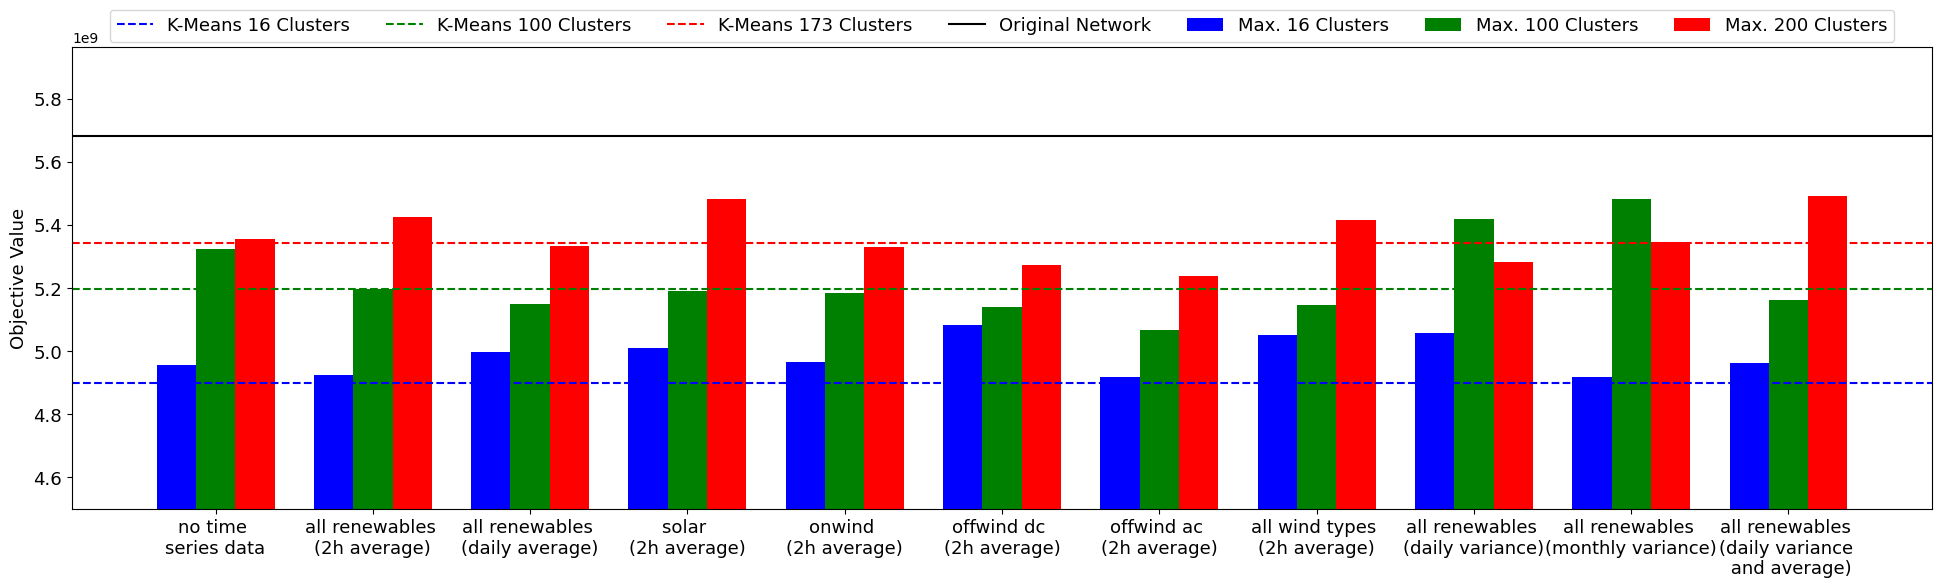

In [49]:
plot_objectives(list_16_EX1, list_100_EX1, list_200_EX1, n_opt, k_means_objectives)

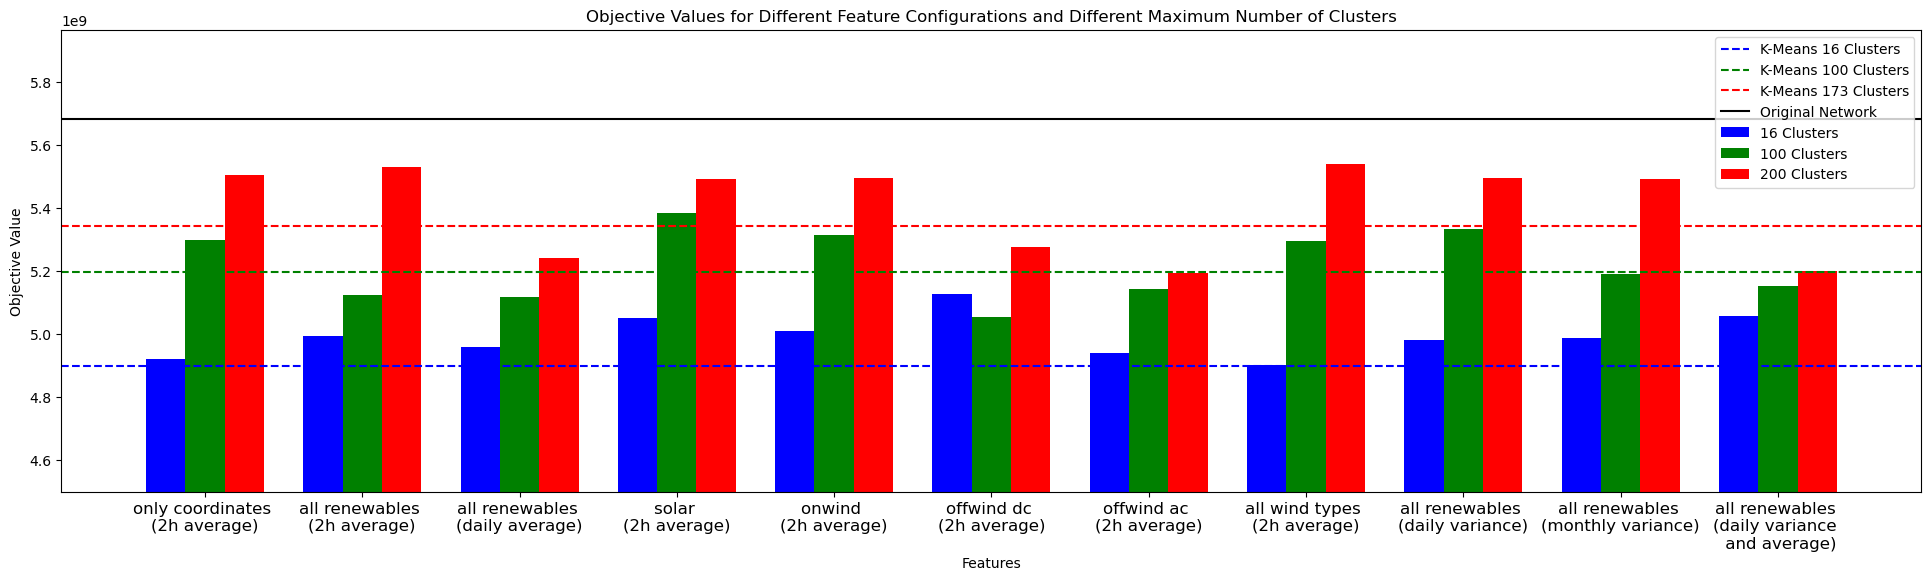

In [222]:
plot_objectives(list_16_EX2, list_100_EX2, list_200_EX2, n_opt, k_means_objectives)

## 1.3) Relative comparison of objective

In [51]:
# arrays for objective plots

# 16
# do an array [feature values (5 experiments) x different features]
objectives_16 = np.array([[only_coord_2h_16_EX1.objective, only_coord_2h_16_EX2.objective, only_coord_2h_16_EX3.objective, only_coord_2h_16_EX4.objective, only_coord_2h_16_EX5.objective],
                         [all_2h_16_EX1.objective, all_2h_16_EX2.objective, all_2h_16_EX3.objective, all_2h_16_EX4.objective, all_2h_16_EX5.objective],
                         [all_daily_average_16_EX1.objective, all_daily_average_16_EX2.objective, all_daily_average_16_EX3.objective, all_daily_average_16_EX4.objective, all_daily_average_16_EX5.objective],
                         [solar_2h_16_EX1.objective, solar_2h_16_EX2.objective, solar_2h_16_EX3.objective, solar_2h_16_EX4.objective, solar_2h_16_EX5.objective],
                         [onwind_2h_16_EX1.objective, onwind_2h_16_EX2.objective, onwind_2h_16_EX3.objective, onwind_2h_16_EX4.objective, onwind_2h_16_EX5.objective],
                         [offwind_dc_2h_16_EX1.objective, offwind_dc_2h_16_EX2.objective, offwind_dc_2h_16_EX3.objective, offwind_dc_2h_16_EX4.objective, offwind_dc_2h_16_EX5.objective],
                         [offwind_ac_2h_16_EX1.objective, offwind_ac_2h_16_EX2.objective, offwind_ac_2h_16_EX3.objective, offwind_ac_2h_16_EX4.objective, offwind_ac_2h_16_EX5.objective],
                         [wind_2h_16_EX1.objective, wind_2h_16_EX2.objective, wind_2h_16_EX3.objective, wind_2h_16_EX4.objective, wind_2h_16_EX5.objective],
                         [all_daily_var_16_EX1.objective, all_daily_var_16_EX2.objective, all_daily_var_16_EX3.objective, all_daily_var_16_EX4.objective, all_daily_var_16_EX5.objective],
                         [all_monthly_var_16_EX1.objective, all_monthly_var_16_EX2.objective, all_monthly_var_16_EX3.objective, all_monthly_var_16_EX4.objective, all_monthly_var_16_EX5.objective],
                         [all_daily_var_and_average_16_EX1.objective, all_daily_var_and_average_16_EX2.objective, all_daily_var_and_average_16_EX3.objective, all_daily_var_and_average_16_EX4.objective, all_daily_var_and_average_16_EX5.objective]])
                         

In [52]:
# 100 
objectives_100 = np.array([[only_coord_2h_100_EX1.objective, only_coord_2h_100_EX2.objective, only_coord_2h_100_EX3.objective, only_coord_2h_100_EX4.objective, only_coord_2h_100_EX5.objective],
                            [all_2h_100_EX1.objective, all_2h_100_EX2.objective, all_2h_100_EX3.objective, all_2h_100_EX4.objective, all_2h_100_EX5.objective],
                            [all_daily_average_100_EX1.objective, all_daily_average_100_EX2.objective, all_daily_average_100_EX3.objective, all_daily_average_100_EX4.objective, all_daily_average_100_EX5.objective],
                            [solar_2h_100_EX1.objective, solar_2h_100_EX2.objective, solar_2h_100_EX3.objective, solar_2h_100_EX4.objective, solar_2h_100_EX5.objective],
                            [onwind_2h_100_EX1.objective, onwind_2h_100_EX2.objective, onwind_2h_100_EX3.objective, onwind_2h_100_EX4.objective, onwind_2h_100_EX5.objective],
                            [offwind_dc_2h_100_EX1.objective, offwind_dc_2h_100_EX2.objective, offwind_dc_2h_100_EX3.objective, offwind_dc_2h_100_EX4.objective, offwind_dc_2h_100_EX5.objective],
                            [offwind_ac_2h_100_EX1.objective, offwind_ac_2h_100_EX2.objective, offwind_ac_2h_100_EX3.objective, offwind_ac_2h_100_EX4.objective, offwind_ac_2h_100_EX5.objective],
                            [wind_2h_100_EX1.objective, wind_2h_100_EX2.objective, wind_2h_100_EX3.objective, wind_2h_100_EX4.objective, wind_2h_100_EX5.objective],
                            [all_daily_var_100_EX1.objective, all_daily_var_100_EX2.objective, all_daily_var_100_EX3.objective, all_daily_var_100_EX4.objective, all_daily_var_100_EX5.objective],
                            [all_monthly_var_100_EX1.objective, all_monthly_var_100_EX2.objective, all_monthly_var_100_EX3.objective, all_monthly_var_100_EX4.objective, all_monthly_var_100_EX5.objective],
                            [all_daily_var_and_average_100_EX1.objective, all_daily_var_and_average_100_EX2.objective, all_daily_var_and_average_100_EX3.objective, all_daily_var_and_average_100_EX4.objective, all_daily_var_and_average_100_EX5.objective]])


In [53]:
# 200
objectives_200 = np.array([[only_coord_2h_200_EX1.objective, only_coord_2h_200_EX2.objective, only_coord_2h_200_EX3.objective, only_coord_2h_200_EX4.objective, only_coord_2h_200_EX5.objective],
                            [all_2h_200_EX1.objective, all_2h_200_EX2.objective, all_2h_200_EX3.objective, all_2h_200_EX4.objective, all_2h_200_EX5.objective],
                            [all_daily_average_100_EX1.objective, all_daily_average_100_EX2.objective, all_daily_average_100_EX3.objective, all_daily_average_100_EX4.objective, all_daily_average_100_EX5.objective],
                            [solar_2h_200_EX1.objective, solar_2h_200_EX2.objective, solar_2h_200_EX3.objective, solar_2h_200_EX4.objective, solar_2h_200_EX5.objective],
                            [onwind_2h_200_EX1.objective, onwind_2h_200_EX2.objective, onwind_2h_200_EX3.objective, onwind_2h_200_EX4.objective, onwind_2h_200_EX5.objective],
                            [offwind_dc_2h_200_EX1.objective, offwind_dc_2h_200_EX2.objective, offwind_dc_2h_200_EX3.objective, offwind_dc_2h_200_EX4.objective, offwind_dc_2h_200_EX5.objective],
                            [offwind_ac_2h_200_EX1.objective, offwind_ac_2h_200_EX2.objective, offwind_ac_2h_200_EX3.objective, offwind_ac_2h_200_EX4.objective, offwind_ac_2h_200_EX5.objective],
                            [wind_2h_100_EX1.objective, wind_2h_100_EX2.objective, wind_2h_100_EX3.objective, wind_2h_100_EX4.objective, wind_2h_100_EX5.objective],
                            [all_daily_var_200_EX1.objective, all_daily_var_200_EX2.objective, all_daily_var_200_EX3.objective, all_daily_var_200_EX4.objective, all_daily_var_200_EX5.objective],
                            [all_monthly_var_200_EX1.objective, all_monthly_var_200_EX2.objective, all_monthly_var_200_EX3.objective, all_monthly_var_200_EX4.objective, all_monthly_var_200_EX5.objective],
                            [all_daily_var_and_average_200_EX1.objective, all_daily_var_and_average_200_EX2.objective, all_daily_var_and_average_200_EX3.objective, all_daily_var_and_average_200_EX4.objective, all_daily_var_and_average_200_EX5.objective]])

In [98]:
# min - max of all renewables daily average 200 
print("Maximum difference for changing seed: ", (objectives_200[8].max() - objectives_200[8].min())/1e6, "million")

Maximum difference for changing seed:  372.8695622047939 million


4969259045.571711
[[-0.25251842 -0.97573595  2.02753081  0.47042368 -1.26970012]
 [-0.91549267  0.49707507  0.95542972 -0.58274201  0.29167417]
 [ 0.57569108 -0.20998644 -1.06960252  3.15430951  1.453178  ]
 [ 0.78712525  1.67536842  2.08218078  0.02804363  0.88298439]
 [-0.05080921  0.82808021  1.55121092  1.28950317 -0.66466777]
 [ 2.25741198  3.20110082  1.90793107  3.08078973  0.94558606]
 [-1.01230945 -0.58106844 -0.768403    4.60888091 -0.20472359]
 [ 1.6614471  -1.35735798  2.10968386  2.73553763 -1.28685258]
 [ 1.78817505  0.23251431 -0.31152036  0.96993948  3.3930478 ]
 [-1.01340138  0.39504695  2.38074057 -1.32245488 -1.44545414]
 [-0.14637476  1.80592115 -1.31217804  4.53976558 -1.29503992]]


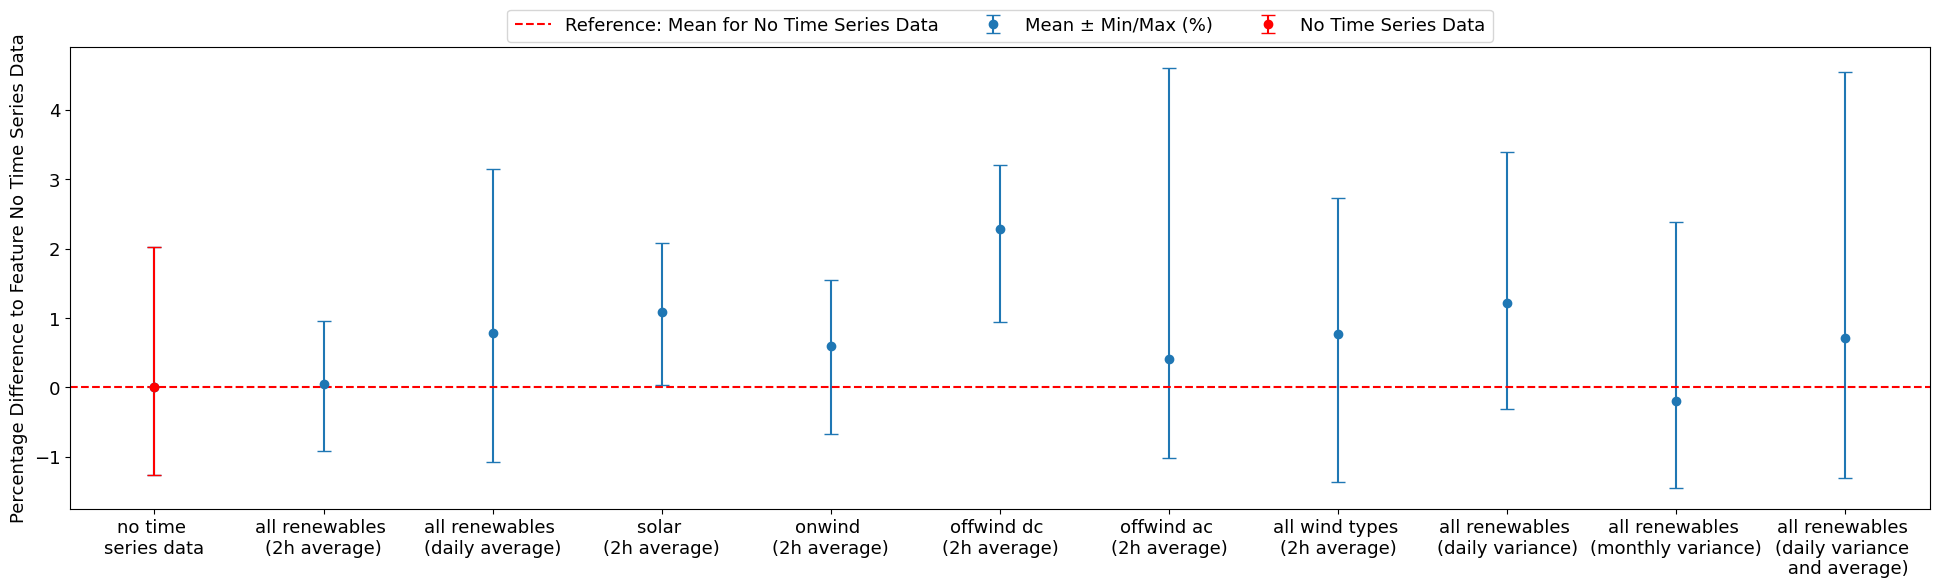

5292865625.145449
[[ 0.59401982  0.12578602 -1.50303131  0.39412471  0.38910075]
 [-1.83911865 -3.16364975 -3.33237084 -1.856955   -1.39449331]
 [-2.71896368 -3.27259325 -2.43026086 -3.68847615 -2.89298337]
 [-1.92028957  1.75623862 -1.29680369  1.05385572 -0.59539997]
 [-2.06533551  0.41770847 -2.83085216 -1.17886828 -2.11017134]
 [-2.89509894 -4.52183507 -3.74040557 -0.34972634  1.75104219]
 [-4.29829293 -2.82146277 -2.32548781 -2.58863741 -4.73664201]
 [-2.79854911  0.07685941 -2.35811216 -1.51160834 -1.77284644]
 [ 2.39519575  0.77475847 -2.67438099 -0.54729897 -2.94459319]
 [ 3.58899066 -1.89451544  1.36479241  3.5319703  -1.22194554]
 [-2.46834934 -2.64312932 -1.9342954  -2.09660302 -2.34182847]]


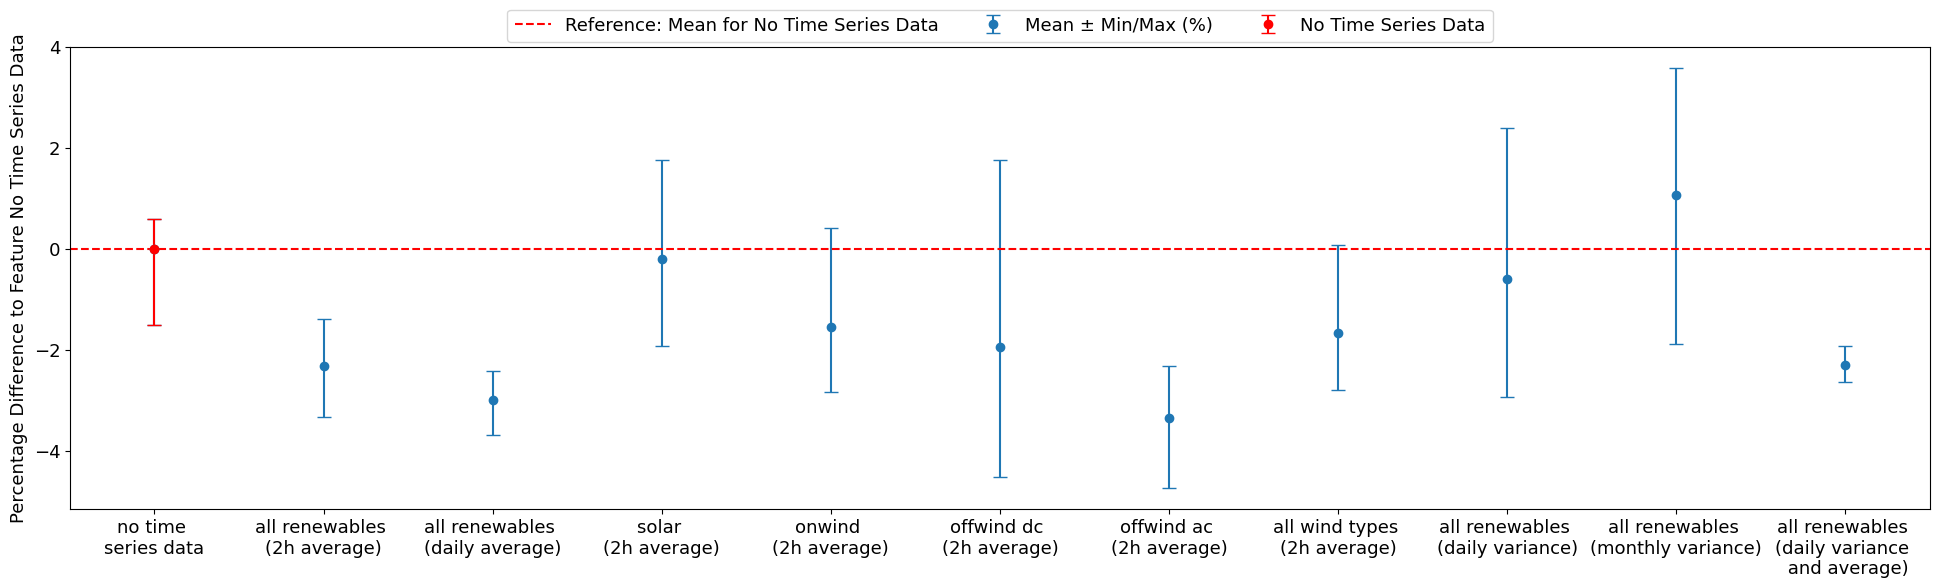

5338193494.861339
[[ 0.34117312  3.10727383 -1.04505646 -0.8166068  -1.5867837 ]
 [ 1.62988098  3.60906303  1.85855303  0.24988541  4.09484184]
 [-3.54500009 -4.09392865 -3.2587487  -4.50628019 -3.71754213]
 [ 2.67585337  2.86555125  4.0286975   2.0293932   4.17780775]
 [-0.12296195  2.93732217  2.35942673  3.0026221   1.70263703]
 [-1.19512093 -1.16242823  0.73549753  3.05351033  3.89746503]
 [-1.86007732 -2.71762023 -2.85822971 -1.78245834 -1.53322749]
 [-3.62390973 -0.77291699 -3.18721263 -2.34789668 -2.60691655]
 [-1.05175785  2.97289691 -3.69050344  3.29443561  2.8271391 ]
 [ 0.12953683  2.87384272  2.50639324  1.99919983  2.9138582 ]
 [ 2.89365328 -2.54533483  0.3195884   0.46538719  2.21074884]]


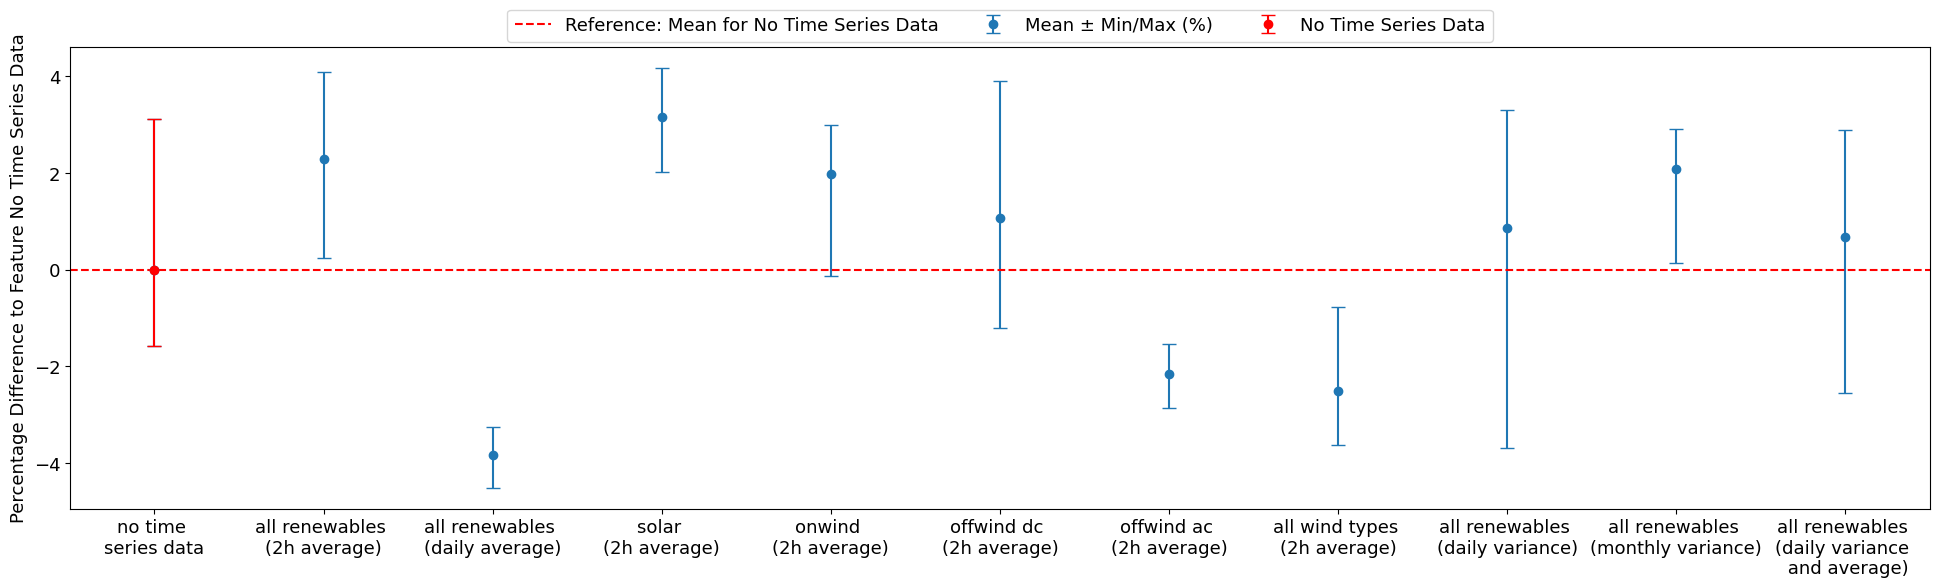

In [ ]:
def plot_feature_percentage_differences(data):
    """
    plots the mean and min/max percentage differences of features relative to feature 1's mean
    
    Args:
        data (numpy.ndarray): 2d array where each row represents a feature and columns represent experiment
    """
    
    # mean of feature 1 (no time sereis)
    mean_feature_1 = np.mean(data[0, :])
    #print(mean_feature_1)
    
    # percentage differences for all features (relative to f 1's mean)
    diffs = ((data - mean_feature_1) / mean_feature_1) * 100  # Convert to percentage
    #print(diffs)
    
    # mean, min, and max of differences
    means = np.mean(diffs, axis=1)
    mins = np.min(diffs, axis=1)
    maxs = np.max(diffs, axis=1)
    yerr_lower = means - mins  
    yerr_upper = maxs - means 
    
    plt.figure(figsize=(24, 6))
    feature_1_color = "red"
    
    plt.errorbar(range(1, 12), means, yerr=[yerr_lower, yerr_upper], fmt='o', capsize=5, label="Mean ± Min/Max (%)")
    
    # special color for f1
    plt.errorbar(1, means[0], yerr=[[yerr_lower[0]], [yerr_upper[0]]], fmt='o', capsize=5, color=feature_1_color, label="No Time Series Data")
    
    plt.axhline(0, color=feature_1_color, linestyle='--', label="Reference: Mean for No Time Series Data")  # Zero reference line
    feature_labels = ["no time \nseries data", "all renewables \n(2h average)", "all renewables \n(daily average)",
                      "solar \n(2h average)", "onwind \n(2h average)", "offwind dc \n(2h average)", "offwind ac \n(2h average)",
                      "all wind types \n(2h average)", "all renewables \n(daily variance)", "all renewables \n(monthly variance)",
                      "all renewables \n(daily variance \n and average)"]
    plt.xticks(ticks=range(1, 12), labels=feature_labels, rotation=0, size=13)
    plt.ylabel("Percentage Difference to Feature No Time Series Data", size=13)
    plt.yticks(size=13)
    
    # Legend in the upper center
    plt.legend(loc='upper center', prop={'size': 13}, ncol=3, bbox_to_anchor=(0.5, 1.1))
    
    # Show the plot
    plt.show()

# Plots for different cluster sizes
plot_feature_percentage_differences(objectives_16)
plot_feature_percentage_differences(objectives_100)
plot_feature_percentage_differences(objectives_200)


## 1.4) Plot Busmaps

In [3]:
# old function, dont need it like this in the end
"""fwarnings.filterwarnings("ignore", message='facecolor will have no effect as it has been defined as "never".')

def plot_clustered_grid_oneExperiment(test_data, optimized_network, original_network):
    """
    plots grid for different configs in the test_data dic
    three plots for each config:
    1. Original grid (unclustered)
    2. Cluster assignment based on softmax probabilities
    3. Clustered grid (after clustering with updated bus colors)
    """
    # set seeds
    np.random.seed(203)  
    random.seed(203)  
    torch.manual_seed(203)
    torch.cuda.manual_seed(203)
    torch.cuda.manual_seed_all(203) 
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 7), subplot_kw={"projection": ccrs.PlateCarree()})

    # loop through each experiment in the results
    cluster_assignment_softmax = test_data["cluster_assignment_softmax"]  # Softmax output for clustering

    # 1st Plot: Original Grid (Unclustered)
    #original_network.plot(ax=axes[0], boundaries=[5.5, 15.5, 46.5, 55.5], bus_sizes=0.008, link_widths=0.3, line_widths=0.3, 
    #                      title="Electric grid of Germany", geomap=True, color_geomap=True, 
    #                      branch_components=["Line", "Link"], line_colors="red", link_colors="green")
        
    # 2nd Plot: Cluster Assignment based on softmax probs
    # Assign clusters based on softmax outputs
    cluster_assignment = cluster_assignment_softmax.argmax(dim=1).numpy()
        
    # color palette for the clusters
    unique_clusters = np.unique(cluster_assignment)
    glasbey_palette = glasbey.create_palette(palette_size=len(unique_clusters))
    random.shuffle(glasbey_palette)  # Shuffle to ensure distinguishable colors for nearby clusters
        
    # map each cluster to a unique color
    bus_colors = {cluster: glasbey_palette[i % len(glasbey_palette)] for i, cluster in enumerate(unique_clusters)}
    original_network.buses['color'] = [bus_colors[cluster] for cluster in cluster_assignment]
        
    # plot buses with colors based on the cluster assignment
    original_network.plot(ax=axes[0], boundaries=[5.5, 15.5, 46.5, 55.5], bus_sizes=0.008, link_widths=0.3, line_widths=0.3, 
                            geomap=True, color_geomap=True, 
                           branch_components=["Line", "Link"], line_colors="red", link_colors="green", bus_colors=n.buses['color'])

    # 3rd Plot: Clustered Grid (After Clustering)
    # Reassign bus colors based on clustering result for `nc`
    optimized_network.buses['color'] = [bus_colors[int(cluster)] for cluster in optimized_network.buses.index]
    optimized_network.plot(ax=axes[1], boundaries=[5.5, 15.5, 46.5, 55.5], bus_sizes=0.008, link_widths=0.3, line_widths=0.3, 
              
              geomap=True, color_geomap=True, branch_components=["Line", "Link"], line_colors="red", link_colors="green", 
              bus_colors=optimized_network.buses['color'])
    #axes[1].text(0.5, -0.03, f"{len(unique_clusters)} clusters", transform=axes[1].transAxes, ha='center', va='top', fontsize=7)
        
    # Clean up 
    original_network.buses = n.buses.drop(columns=['color'])
    optimized_network.buses = optimized_network.buses.drop(columns=['color'])
    
    plt.tight_layout()
    plt.show()"""

In [4]:
warnings.filterwarnings("ignore", message='facecolor will have no effect as it has been defined as "never".')

def plot_clustered_grid_oneExperiment_seperate(test_data, optimized_network, original_network):
    """
    shows two separate plots to see which buses go where:
    1. original Grid with assigned clusters
    2. clustered grid with colours (After clustering with updated bus colors)

    Parameters:
    - test_data (dict): dictionary containing the test data for the experiment
    - optimized_network: optimized network after clustering
    - original_network: original network before clustering
    """
    # Set seeds for reproducibility
    np.random.seed(203)
    random.seed(203)
    torch.manual_seed(203)
    torch.cuda.manual_seed(203)
    torch.cuda.manual_seed_all(203)

    # Extract cluster assignments
    cluster_assignment_softmax = test_data["cluster_assignment_softmax"]
    cluster_assignment = cluster_assignment_softmax.argmax(dim=1).numpy()
    
    # Generate a color palette for clusters
    unique_clusters = np.unique(cluster_assignment)
    glasbey_palette = glasbey.create_palette(palette_size=len(unique_clusters))
    random.shuffle(glasbey_palette)
    
    # Map each cluster to a color
    bus_colors = {cluster: glasbey_palette[i % len(glasbey_palette)] for i, cluster in enumerate(unique_clusters)}
    original_network.buses['color'] = [bus_colors[cluster] for cluster in cluster_assignment]

    # 1. plot: Original Grid with Cluster Assignments ---
    fig1, ax1 = plt.subplots(figsize=(8, 4), subplot_kw={"projection": ccrs.PlateCarree()})
    original_network.plot(ax=ax1, boundaries=[5.5, 15.5, 46.5, 55.5], 
                          bus_sizes=0.008, link_widths=0.3, line_widths=0.3, 
                          geomap=True, color_geomap=True, 
                          branch_components=["Line", "Link"], line_colors="red", link_colors="green", 
                          bus_colors=original_network.buses['color'])
    plt.show()

    # 2. plot: Clustered Grid After aggregation
    fig2, ax2 = plt.subplots(figsize=(8, 4), subplot_kw={"projection": ccrs.PlateCarree()})
    optimized_network.buses['color'] = [bus_colors[int(cluster)] for cluster in optimized_network.buses.index]
    optimized_network.plot(ax=ax2, boundaries=[5.5, 15.5, 46.5, 55.5], 
                           bus_sizes=0.008, link_widths=0.3, line_widths=0.3, 
                           geomap=True, color_geomap=True, 
                           branch_components=["Line", "Link"], line_colors="red", link_colors="green", 
                           bus_colors=optimized_network.buses['color'])
    plt.show()

    # Clean up color column
    original_network.buses = original_network.buses.drop(columns=['color'])
    optimized_network.buses = optimized_network.buses.drop(columns=['color'])


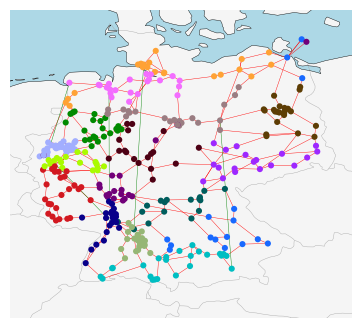

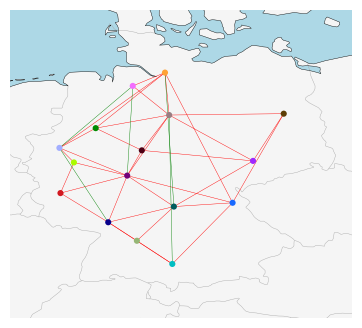

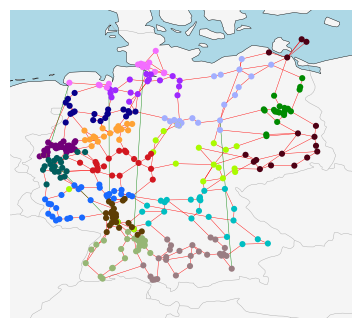

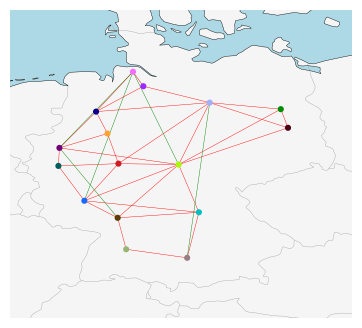

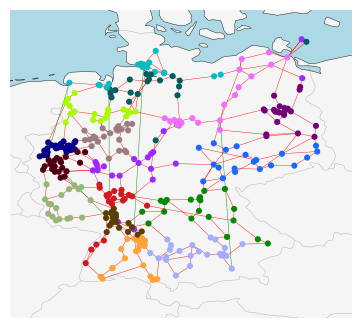

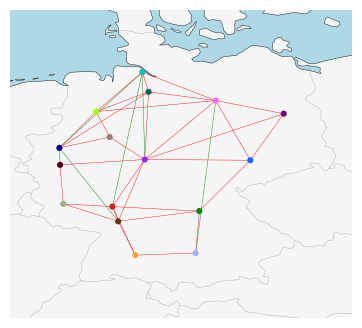

In [15]:
all_2h_16_EX1_training = pd.read_pickle("/Users/ninakirsch/Desktop/my_files_for_github/lr00001_16/cf_15000_16_EX1/training_data.pkl")["all"]
all_2h_16_EX1_testing = pd.read_pickle("/Users/ninakirsch/Desktop/my_files_for_github/lr00001_16/cf_15000_16_EX1/testing_data.pkl")["all"]
#plot_clustered_grid_oneExperiment(all_2h_16_EX1_testing, all_2h_16_EX1, n)
plot_clustered_grid_oneExperiment_seperate(all_2h_16_EX1_testing, all_2h_16_EX1, n)

all_2h_16_EX2_training = pd.read_pickle("/Users/ninakirsch/Desktop/my_files_for_github/lr00001_16/cf_15000_16_EX2/training_data.pkl")["all"]
all_2h_16_EX2_testing = pd.read_pickle("/Users/ninakirsch/Desktop/my_files_for_github/lr00001_16/cf_15000_16_EX2/testing_data.pkl")["all"]
#plot_clustered_grid_oneExperiment(all_2h_16_EX2_testing, all_2h_16_EX2, n)
plot_clustered_grid_oneExperiment_seperate(all_2h_16_EX2_testing, all_2h_16_EX2, n)

all_2h_16_EX3_training = pd.read_pickle("/Users/ninakirsch/Desktop/my_files_for_github/lr00001_16/cf_15000_16_EX3/training_data.pkl")["all"]
all_2h_16_EX3_testing = pd.read_pickle("/Users/ninakirsch/Desktop/my_files_for_github/lr00001_16/cf_15000_16_EX3/testing_data.pkl")["all"]
#plot_clustered_grid_oneExperiment(all_2h_16_EX3_testing, all_2h_16_EX3, n)
plot_clustered_grid_oneExperiment_seperate(all_2h_16_EX3_testing, all_2h_16_EX3, n)

In [ ]:
# same for daily average
all_daily_average_16_EX1_training = pd.read_pickle("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment1/daily_average/cf_16_EX1/training_data.pkl")["all"]
all_daily_average_16_EX1_testing = pd.read_pickle("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment1/daily_average/cf_16_EX1/testing_data.pkl")["all"]
plot_clustered_grid_oneExperiment(all_daily_average_16_EX1_testing, all_daily_average_16_EX1, n)

all_daily_average_16_EX2_training = pd.read_pickle("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment2/daily_average/cf_16_EX2/training_data.pkl")["all"]
all_daily_average_16_EX2_testing = pd.read_pickle("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment2/daily_average/cf_16_EX2/testing_data.pkl")["all"]
plot_clustered_grid_oneExperiment(all_daily_average_16_EX2_testing, all_daily_average_16_EX2, n)

all_daily_average_16_EX3_training = pd.read_pickle("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment3/daily_average/cf_16_EX3/training_data.pkl")["all"]
all_daily_average_16_EX3_testing = pd.read_pickle("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment3/daily_average/cf_16_EX3/testing_data.pkl")["all"]
plot_clustered_grid_oneExperiment(all_daily_average_16_EX3_testing, all_daily_average_16_EX3, n)

In [ ]:
# same for daily average
all_daily_average_200_EX1_training = pd.read_pickle("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment1/daily_average/cf_200_EX1/training_data.pkl")["all"]
all_daily_average_200_EX1_testing = pd.read_pickle("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment1/daily_average/cf_200_EX1/testing_data.pkl")["all"]
plot_clustered_grid_oneExperiment(all_daily_average_200_EX1_testing, all_daily_average_200_EX1, n)

/opt/miniconda3/envs/pypsa-eur/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


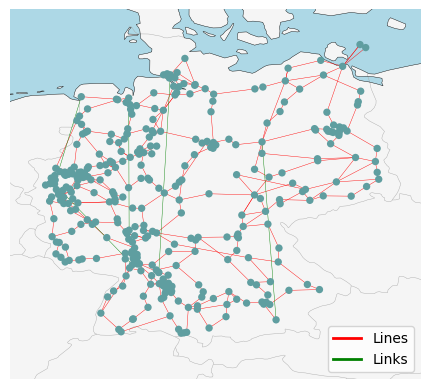

Number of buses in the original network:  339
Number of lines in the original network:  486
Number of links in the original network:  5


/opt/miniconda3/envs/pypsa-eur/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


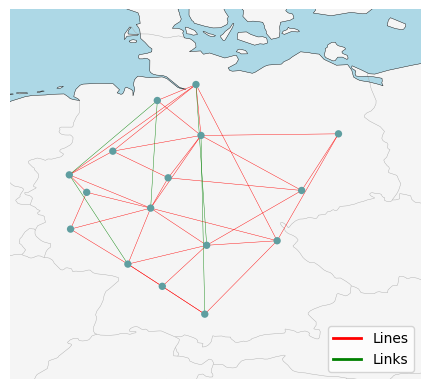

Number of buses in the reduced network:  16
Number of lines in the reduced network:  34
Number of links in the reduced network:  5


/opt/miniconda3/envs/pypsa-eur/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


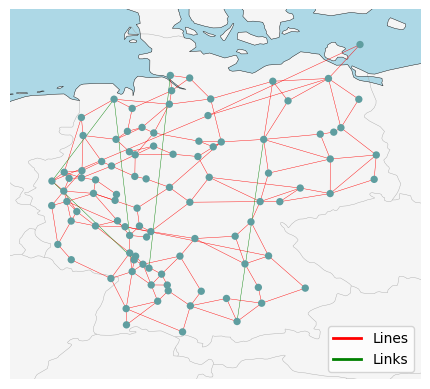

Number of buses in the reduced network:  98
Number of lines in the reduced network:  179
Number of links in the reduced network:  5


/opt/miniconda3/envs/pypsa-eur/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


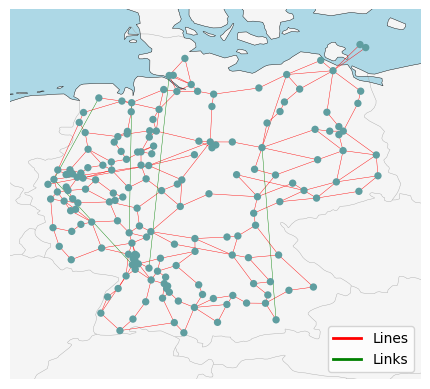

Number of buses in the reduced network:  177
Number of lines in the reduced network:  265
Number of links in the reduced network:  5


In [99]:
# plot original network
n.plot(boundaries=[5.5, 15.5, 46.5, 55.5], bus_sizes=0.008, link_widths=0.3, line_widths=0.3,
         geomap=True, color_geomap=True, branch_components=["Line", "Link"], line_colors="red", link_colors="green")
plt.legend(handles=[plt.Line2D([0], [0], color="red", lw=2, label="Lines"), plt.Line2D([0], [0], color="green", lw=2, label="Links")],loc="lower right")
plt.show()
print("Number of buses in the original network: ", len(n.buses))
print("Number of lines in the original network: ", len(n.lines))
print("Number of links in the original network: ", len(n.links))


# plot how reduced networks look like
all_2h_16_EX1.plot(boundaries=[5.5, 15.5, 46.5, 55.5], bus_sizes=0.008, link_widths=0.3, line_widths=0.3, 
                        geomap=True, color_geomap=True, 
                        branch_components=["Line", "Link"], line_colors="red", link_colors="green")
#plt.text(0.5, -0.03, "Maximum number of clusters: 16", transform=plt.gca().transAxes, ha='center', va='top', fontsize=7)
plt.legend(handles=[plt.Line2D([0], [0], color="red", lw=2, label="Lines"), plt.Line2D([0], [0], color="green", lw=2, label="Links")],loc="lower right")
plt.show()
# print number of buses and lines, links
print("Number of buses in the reduced network: ", len(all_2h_16_EX1.buses))
print("Number of lines in the reduced network: ", len(all_2h_16_EX1.lines))
print("Number of links in the reduced network: ", len(all_2h_16_EX1.links))


all_2h_100_EX1.plot(boundaries=[5.5, 15.5, 46.5, 55.5], bus_sizes=0.008, link_widths=0.3, line_widths=0.3, 
                     geomap=True, color_geomap=True, 
                        branch_components=["Line", "Link"], line_colors="red", link_colors="green")
plt.legend(handles=[plt.Line2D([0], [0], color="red", lw=2, label="Lines"), plt.Line2D([0], [0], color="green", lw=2, label="Links")],loc="lower right")  # Adjust as needed for the plotfontsize = 6)
#plt.text(0.5, -0.03, "Maximum number of clusters: 100", transform=plt.gca().transAxes, ha='center', va='top', fontsize=7)
plt.show()
print("Number of buses in the reduced network: ", len(all_2h_100_EX1.buses))
print("Number of lines in the reduced network: ", len(all_2h_100_EX1.lines))
print("Number of links in the reduced network: ", len(all_2h_100_EX1.links))

all_2h_200_EX1.plot(boundaries=[5.5, 15.5, 46.5, 55.5], bus_sizes=0.008, link_widths=0.3, line_widths=0.3, 
                         geomap=True, color_geomap=True, 
                        branch_components=["Line", "Link"], line_colors="red", link_colors="green")
plt.legend(handles=[plt.Line2D([0], [0], color="red", lw=2, label="Lines"), plt.Line2D([0], [0], color="green", lw=2, label="Links")],loc="lower right")
#plt.text(0.5, -0.03, "Maximum number of clusters: 200", transform=plt.gca().transAxes, ha='center', va='top', fontsize=7)
plt.show()
print("Number of buses in the reduced network: ", len(all_2h_200_EX1.buses))
print("Number of lines in the reduced network: ", len(all_2h_200_EX1.lines))
print("Number of links in the reduced network: ", len(all_2h_200_EX1.links))

In [ ]:
# k-means grids as comparison
opt_16_means.plot(boundaries=[5.5, 15.5, 46.5, 55.5], bus_sizes=0.008, link_widths=0.3, line_widths=0.3, 
                        title="Clustered grid", geomap=True, color_geomap=True, 
                        branch_components=["Line", "Link"], line_colors="red", link_colors="green")
plt.legend(handles=[plt.Line2D([0], [0], color="red", lw=2, label="Lines"), plt.Line2D([0], [0], color="green", lw=2, label="Links")],loc="lower right")  # Adjust a
plt.show()

opt_100_means.plot(boundaries=[5.5, 15.5, 46.5, 55.5], bus_sizes=0.008, link_widths=0.3, line_widths=0.3, 
                        title="Clustered grid", geomap=True, color_geomap=True, 
                        branch_components=["Line", "Link"], line_colors="red", link_colors="green")
plt.legend(handles=[plt.Line2D([0], [0], color="red", lw=2, label="Lines"), plt.Line2D([0], [0], color="green", lw=2, label="Links")],loc="lower right")  # Adjust a
plt.show()

opt_173_means.plot(boundaries=[5.5, 15.5, 46.5, 55.5], bus_sizes=0.008, link_widths=0.3, line_widths=0.3,
                        title="Clustered grid", geomap=True, color_geomap=True, 
                        branch_components=["Line", "Link"], line_colors="red", link_colors="green")
plt.legend(handles=[plt.Line2D([0], [0], color="red", lw=2, label="Lines"), plt.Line2D([0], [0], color="green", lw=2, label="Links")],loc="lower right")  # Adjust a
plt.show()

In [ ]:
"""network_folder = "/Users/ninakirsch/Desktop/my_files_for_github/lr00001_100/cn_15000_100_EX1" # 700 epochs
network_files = [f for f in os.listdir(network_folder) if f.endswith('.h5')]
clustered_networks = {} # clustered_networks dict will contains the clustered, optimize PyPSA networks
for network_file in network_files: 
    network_file_hdf5 = os.path.join(network_folder, network_file) # Generate the full file path
    network = pypsa.Network() # Reload the network from the HDF5 file
    network.import_from_hdf5(network_file_hdf5)     
    network_file = network_file.replace(".h5", "") # replace h5 in the name with empty
    clustered_networks[network_file] = network # Add the network to the dictionary with the filename as the key
    print(f"Loaded network from {network_file_hdf5}")"""
    

## 1.5) Loss curves of clustering process 
### 1.5.1) Total loss

In [68]:
def plot_loss_curves(results, colormap=plt.cm.tab20):
    num_colors = len(results)

    # array of colors from the colormap
    colors = [colormap(i / num_colors) for i in range(num_colors)]
    
    fig = plt.figure(figsize=(20, 10))

    # loop through each experiment and plot its loss curve with unique color
    idx = 0
    for key, result in results.items():
        epoch_losses = result["epoch_losses"]
        label = f"Features: {' '.join(result['carriers'])}, Time series data: {result['include_time']}"

        # select color from the colormap
        color = colors[idx % len(colors)]
      
        plt.plot(range(len(epoch_losses)), epoch_losses, label=label, color=color)
        idx += 1


    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("Loss", fontsize=14)
    plt.title("Loss Curves for Clustering Accoring to Different Features (each 2h resolution of capacity factor)", fontsize=16)
    plt.legend(title="Features", fontsize=7, loc='upper right')
    plt.grid(True) 
    plt.tight_layout()  
    plt.show()

In [ ]:
def plot_loss_curves_hyperparameters(results, colormap=plt.cm.tab20):

    num_colors = len(results)

    colors = [colormap(i / num_colors) for i in range(num_colors)]

    fig = plt.figure(figsize=(20, 10))

    idx = 0
    for key, result in results.items():
        epoch_losses = result["all"]["epoch_losses"]
        label = f"{key}"
        color = colors[idx % len(colors)]
        plt.plot(range(len(epoch_losses)), epoch_losses, label=label, color=color)
        idx += 1

    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("Loss", fontsize=14)
    plt.title("Training Loss for 2h, all renewables, learning rate = 0.001", fontsize=16)
    plt.legend(title="Maximum number of clusters", fontsize=14, loc='upper right')
    plt.grid(True)  
    plt.tight_layout() 
    plt.show()

#### higher learning rate (0.001) to show the spiking problem

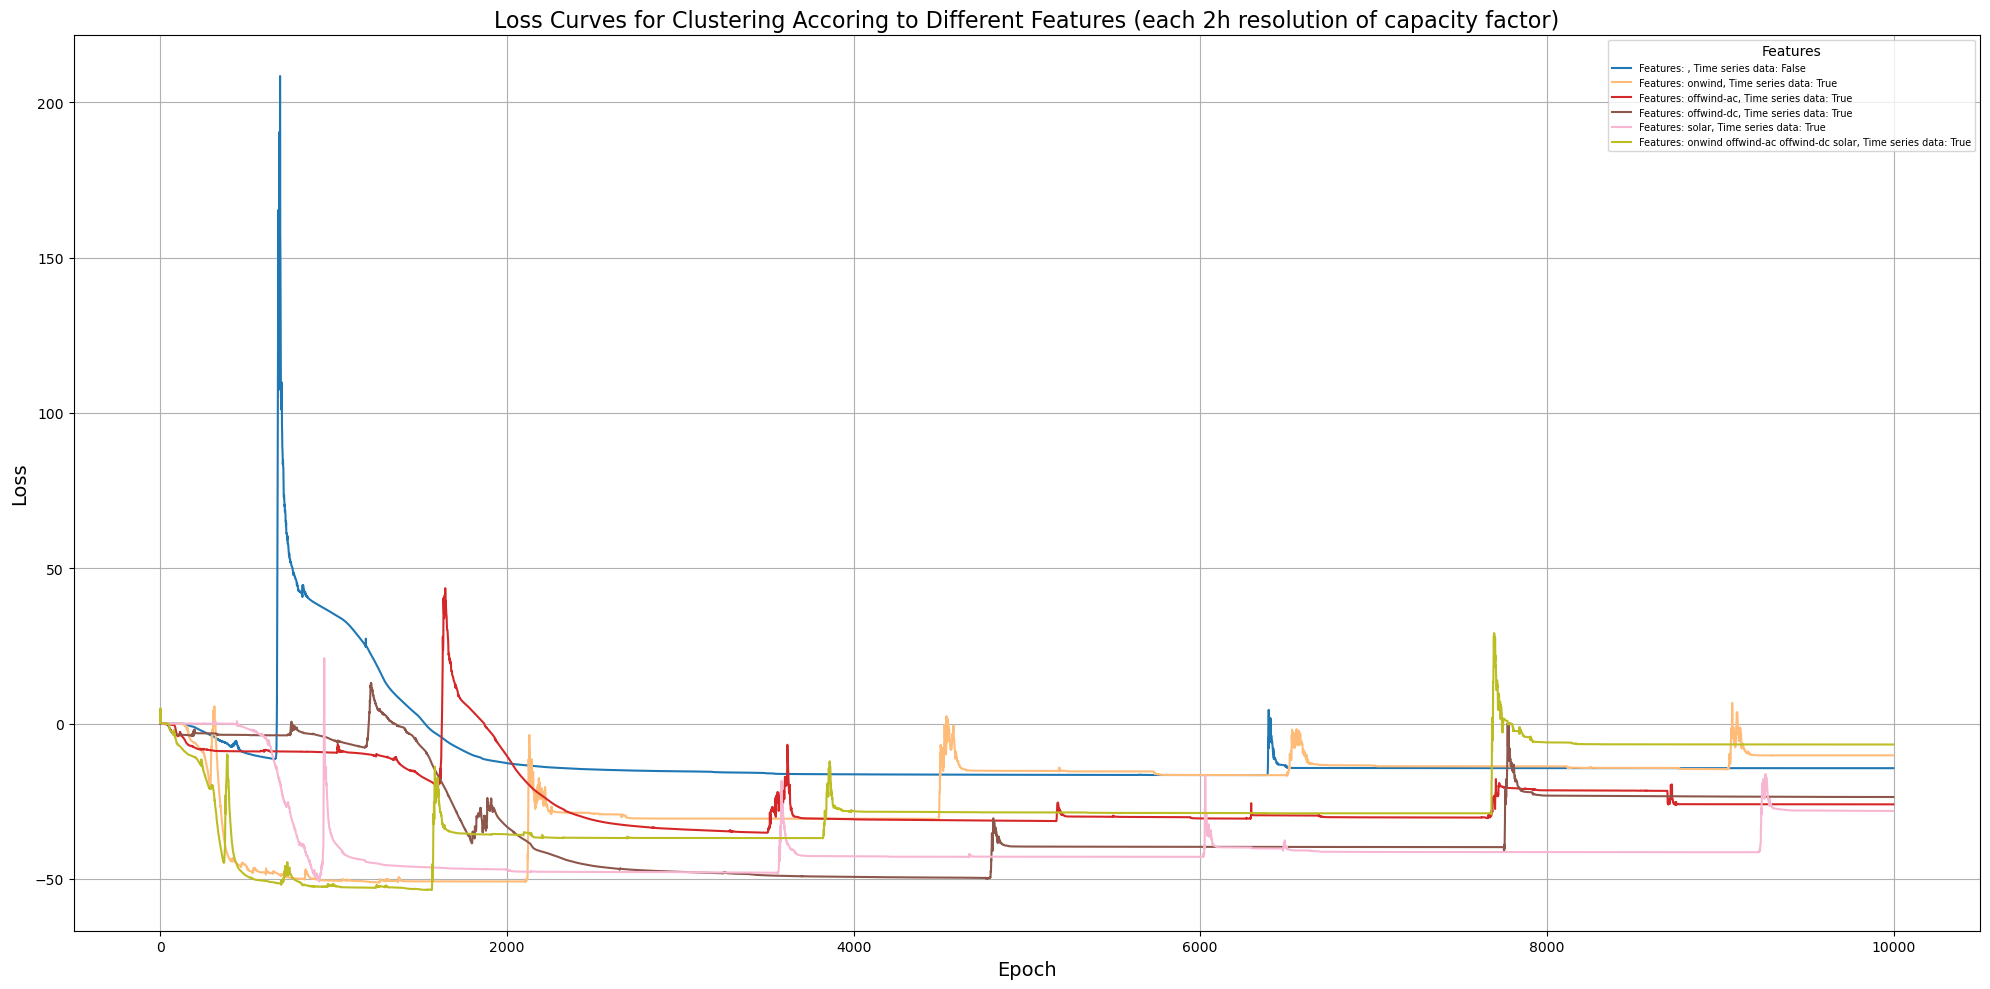

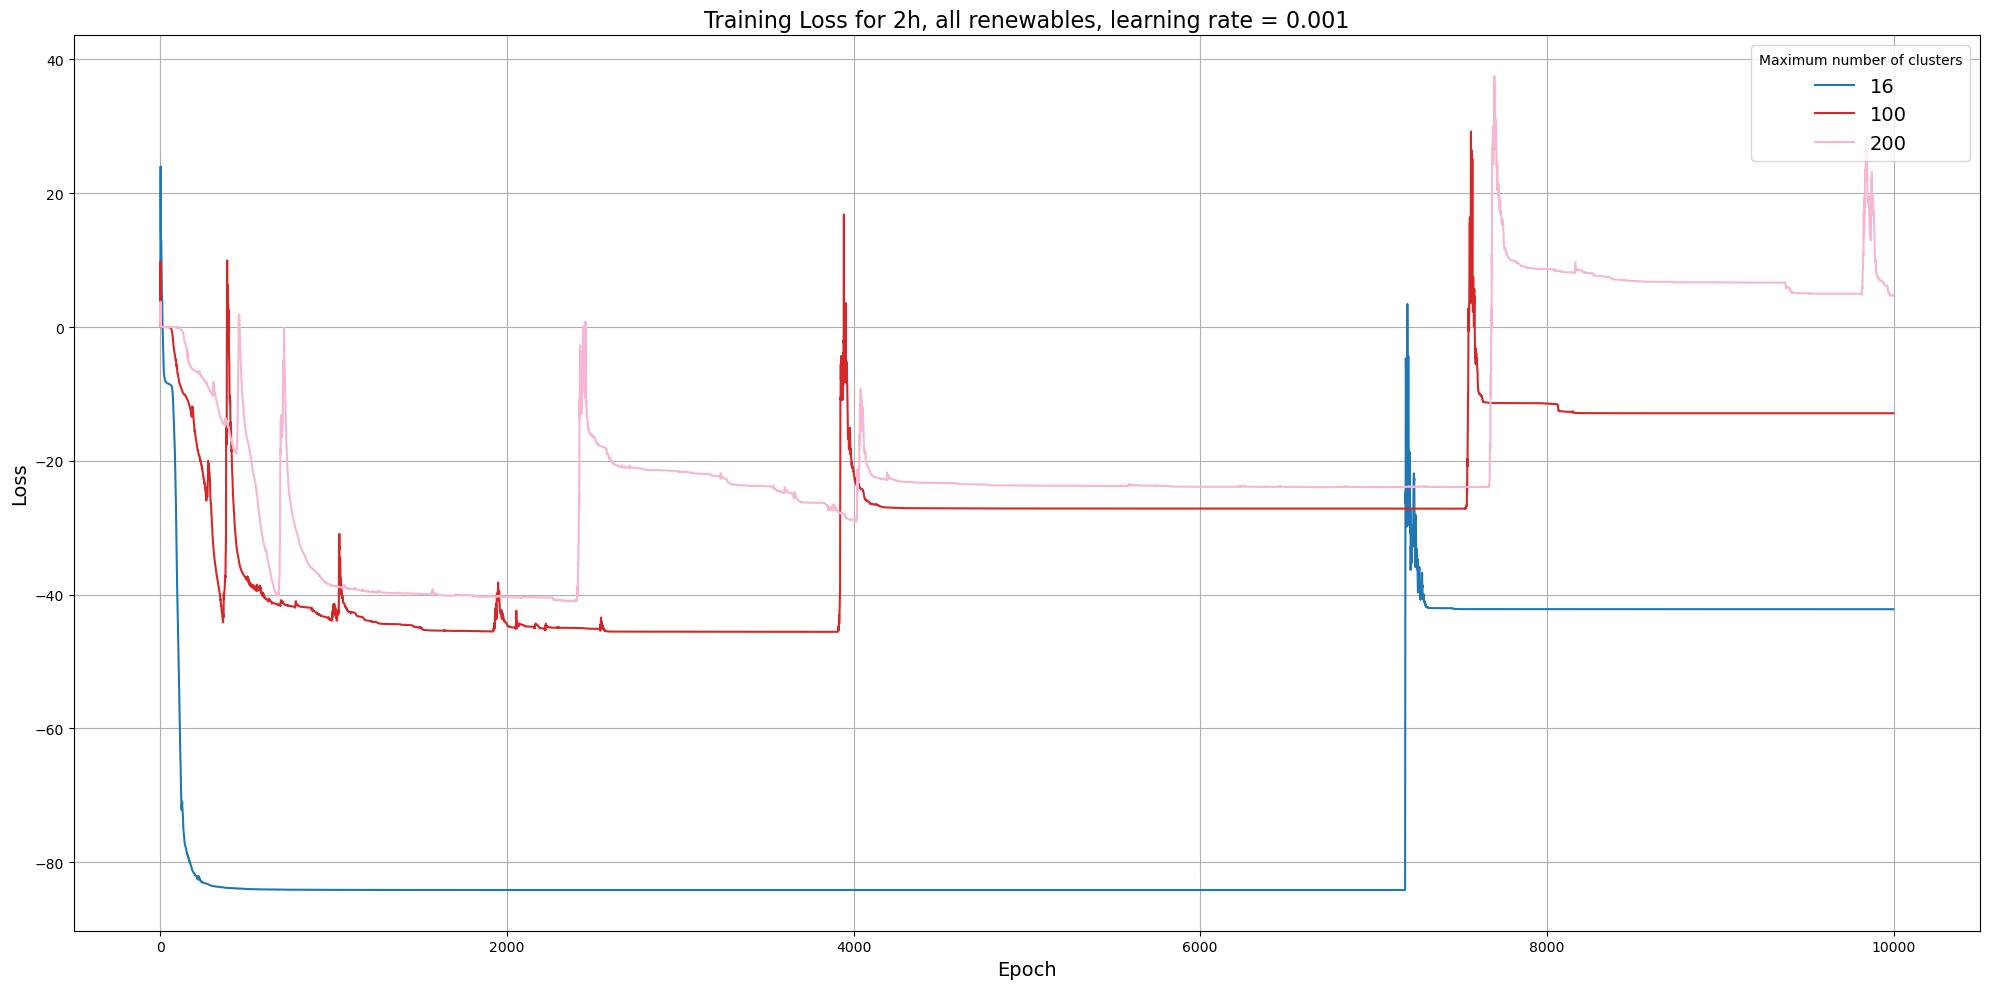

In [315]:
### Examples that learning rate of 0.001 is too high and spikes appear, why we set it lower
# learning rate 0.001
# for different features but to 100 clusters: the spikes make stoppoing training at a specific epoch not reasonable 
plot_loss_curves(higher_lr_100)


# for fearues "all renewables" and 16, 100, 200 clusters
all_001_16  = pd.read_pickle("/Users/ninakirsch/Desktop/my_files_for_github/lr001_hyperparameters/training_16_001.pkl")
all_001_100 = pd.read_pickle("/Users/ninakirsch/Desktop/my_files_for_github/lr001_hyperparameters/training_100_001.pkl")
all_001_200 = pd.read_pickle("/Users/ninakirsch/Desktop/my_files_for_github/lr001_hyperparameters/training_200_001.pkl")
# one dictionary to plot loss curves
lr_001 = {"16": all_001_16, "100": all_001_100, "200": all_001_200}
plot_loss_curves_hyperparameters(lr_001)

#### loss curves for lower and used learning rate 0.0001 

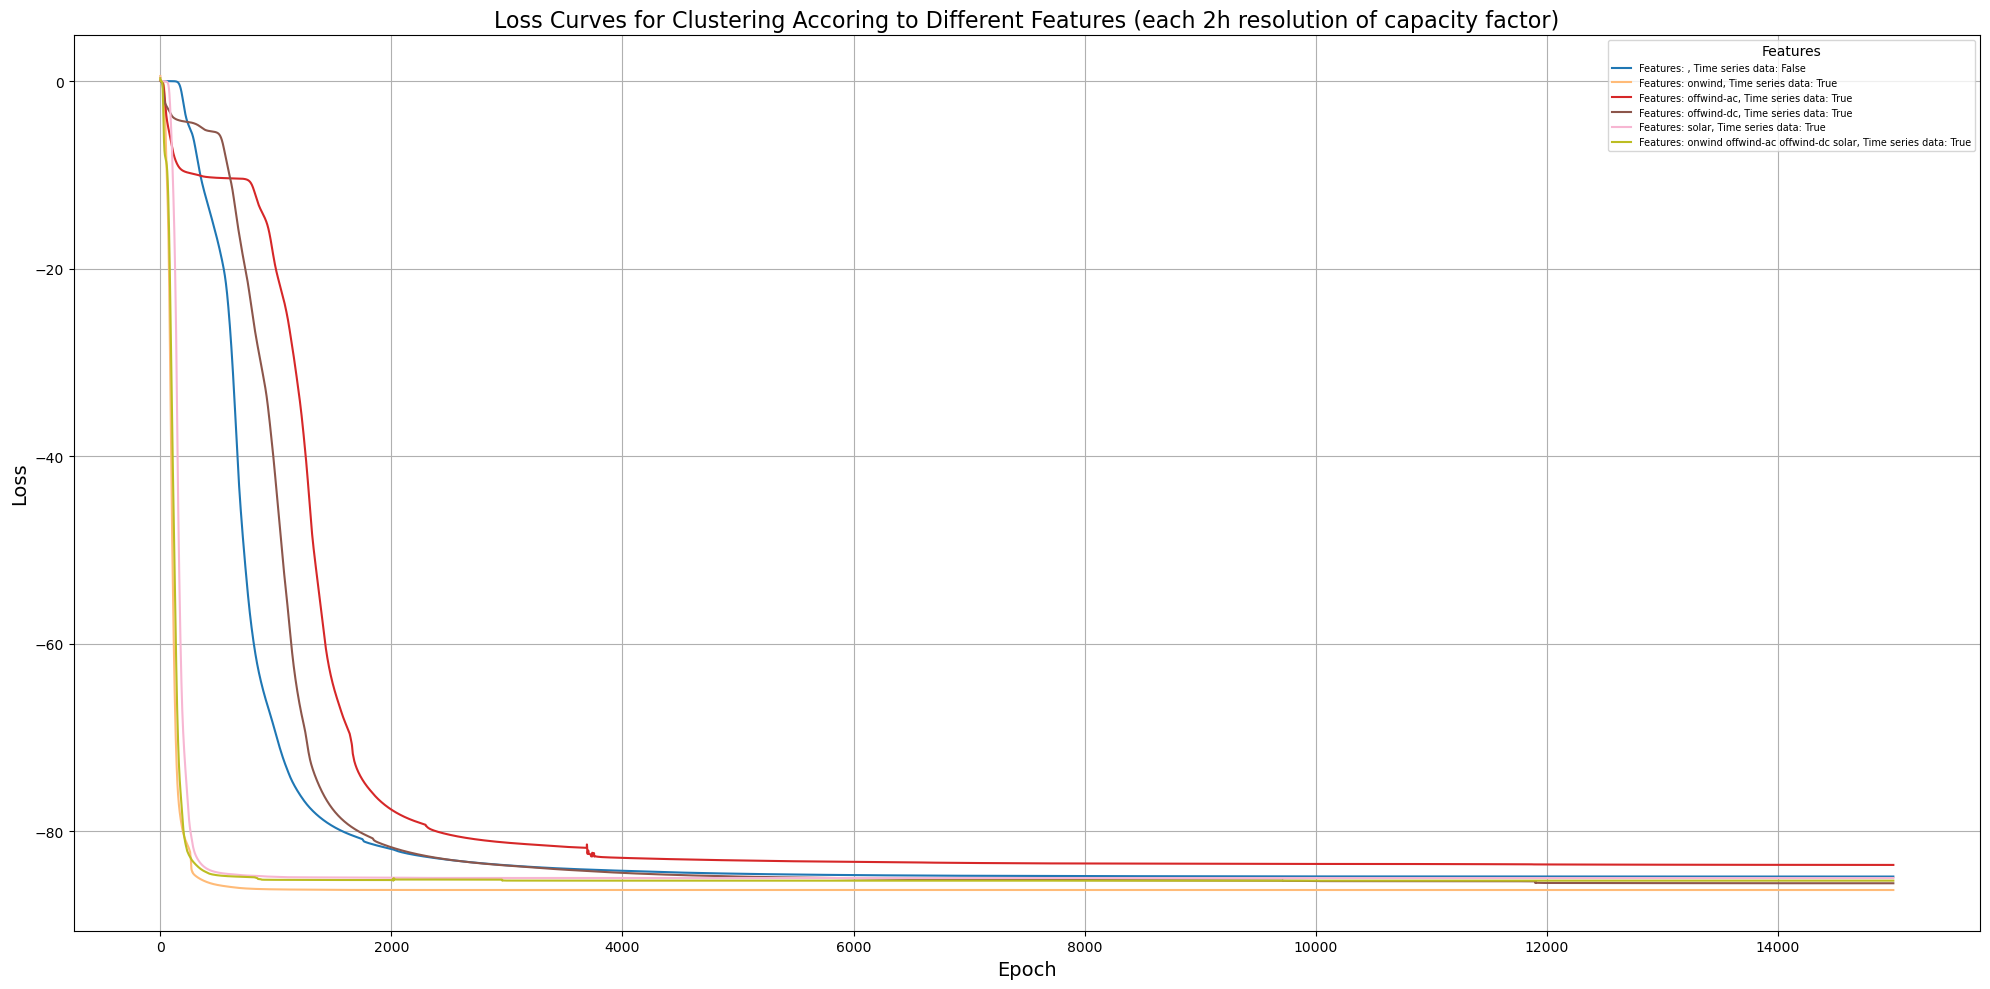

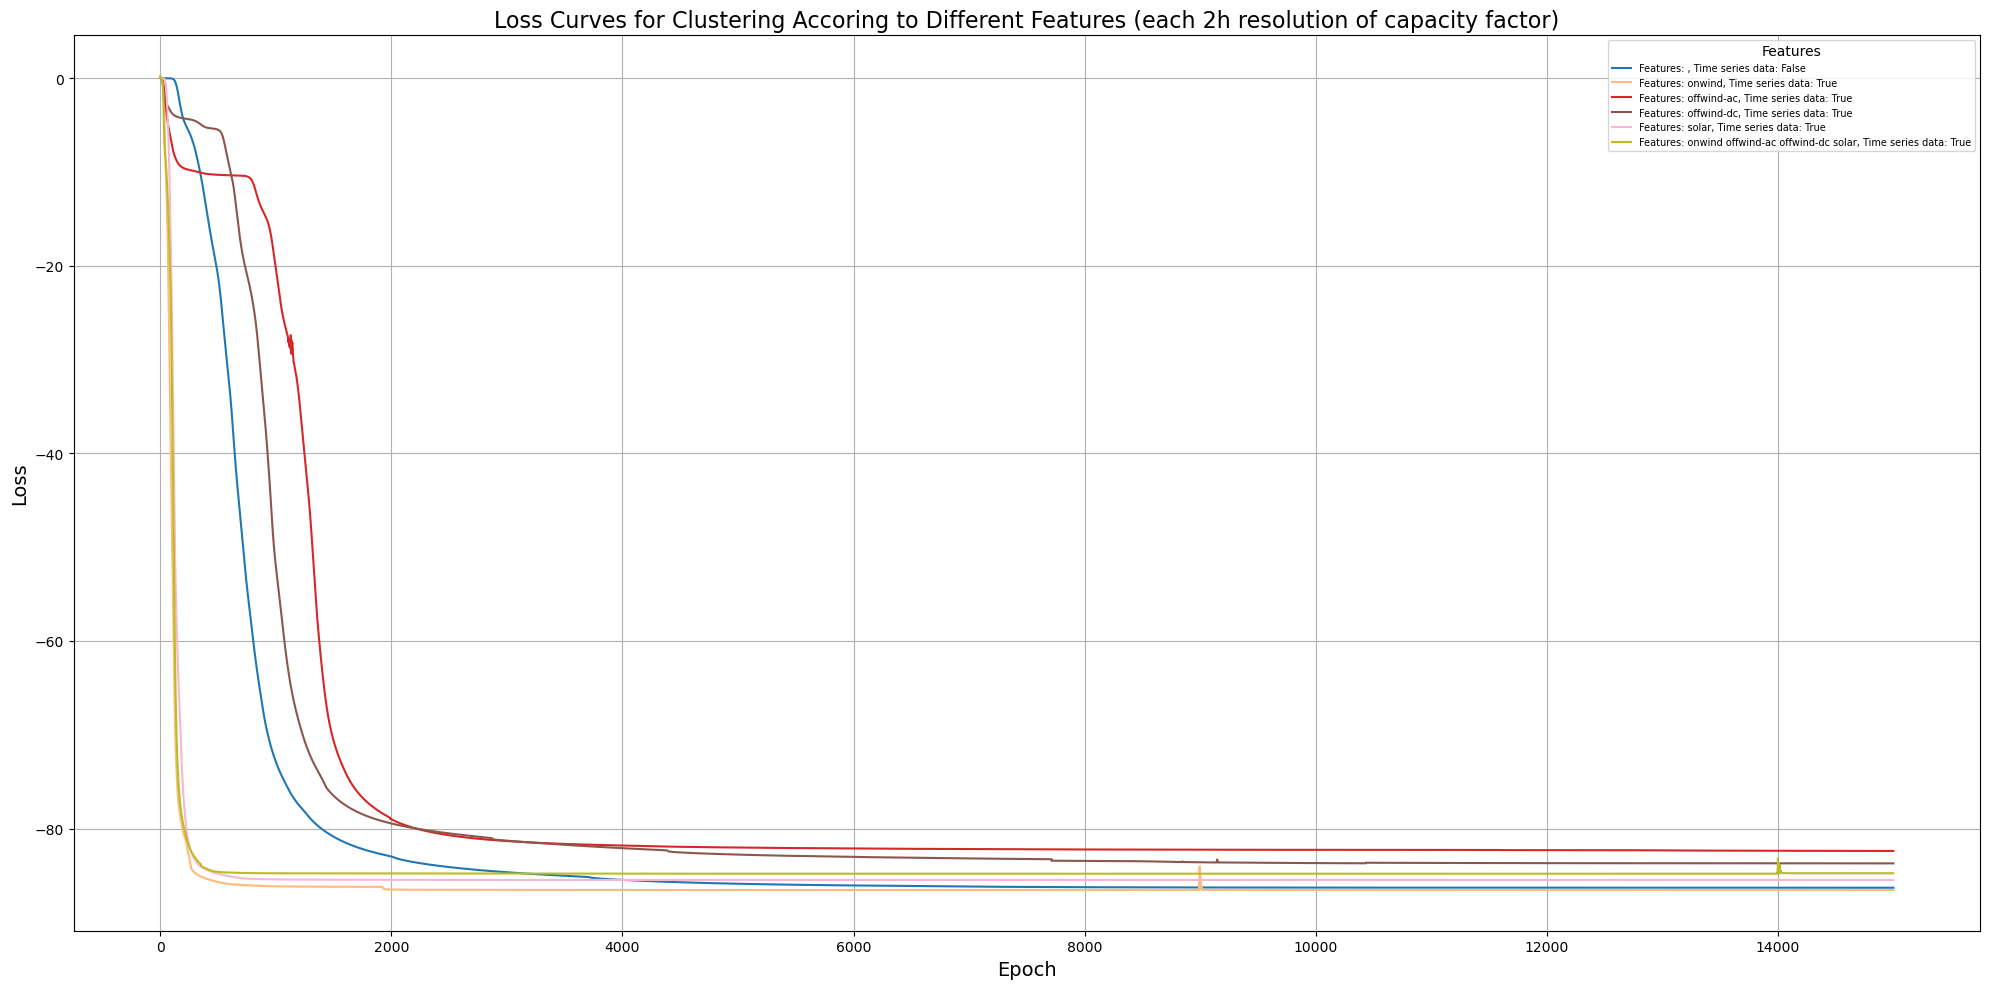

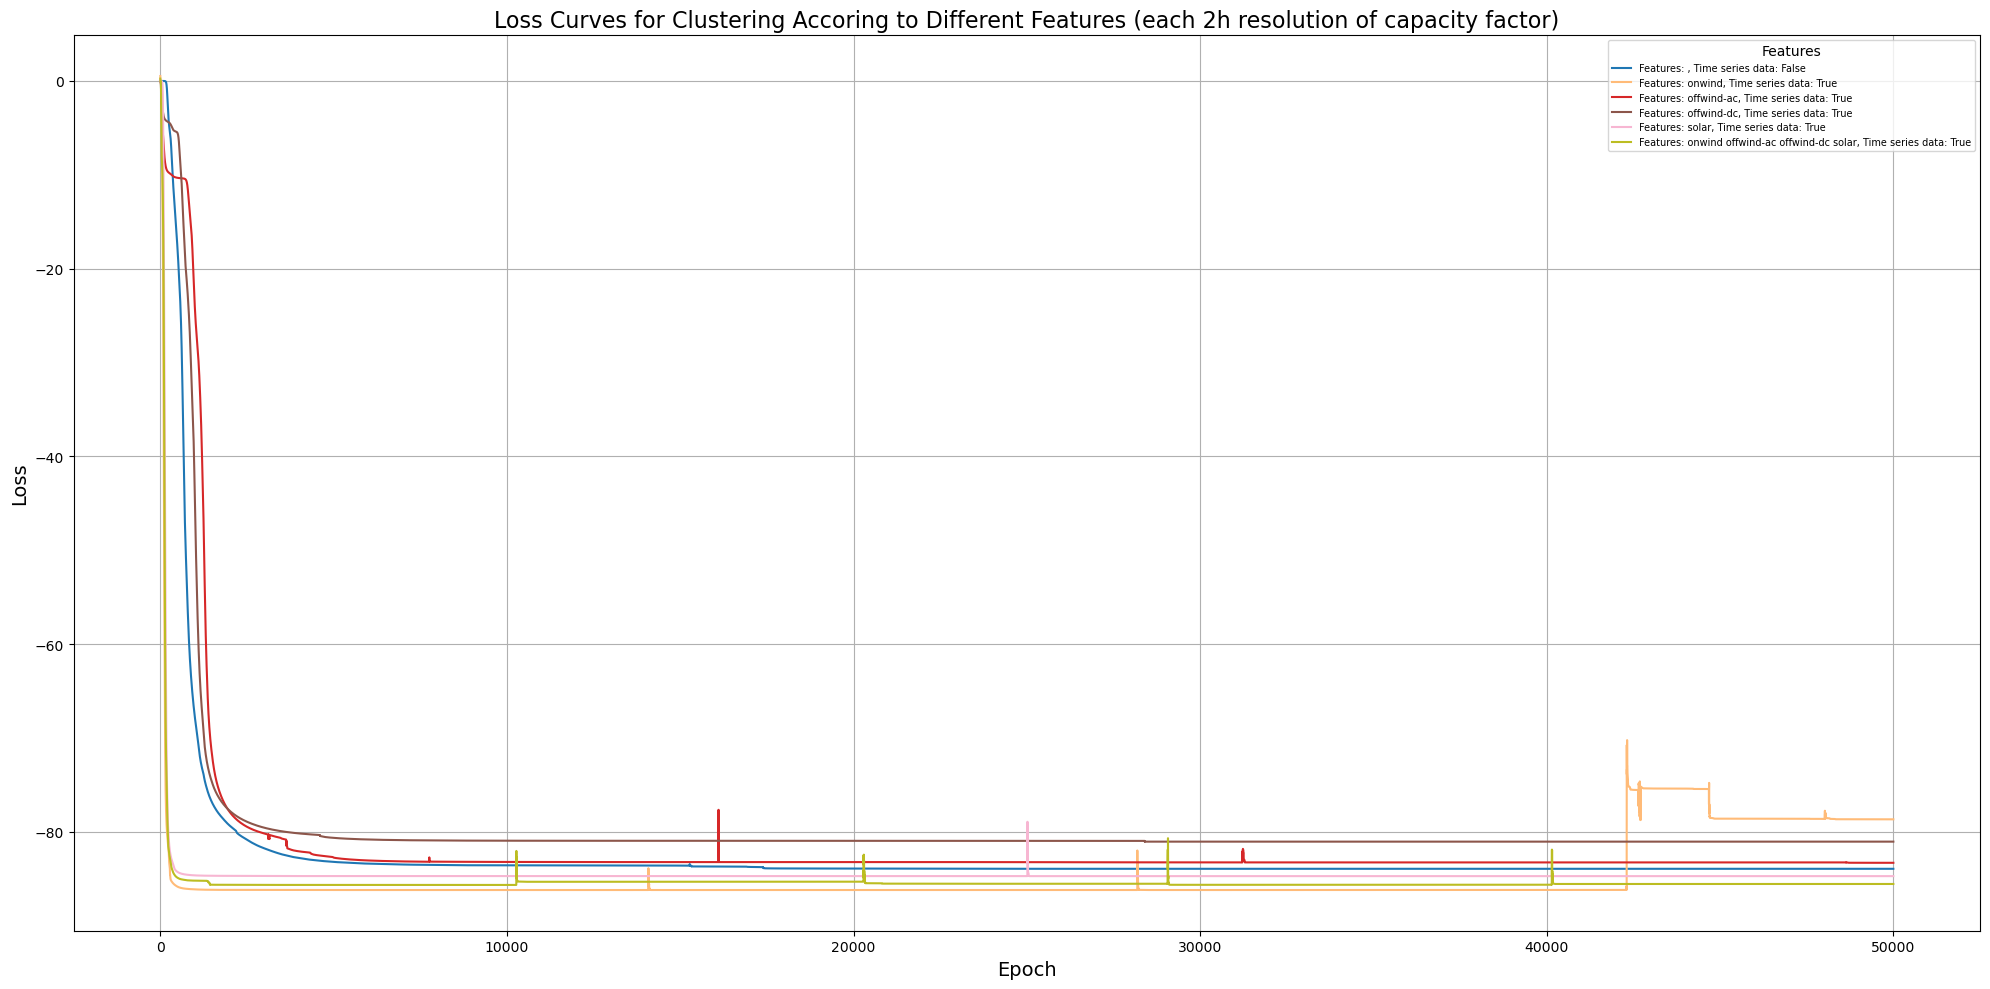

In [ ]:
# 16 clusters
# loss curves for 16 clusters and different features to show that model learns well with chosen hyperparas
# (for 2h capacity factors, some different fetures configurations)
train_dic_16_EX1 = pd.read_pickle("/Users/ninakirsch/Desktop/my_files_for_github/lr00001_16/cf_15000_16_EX1/training_data.pkl")
train_dic_16_EX2 = pd.read_pickle("/Users/ninakirsch/Desktop/my_files_for_github/lr00001_16/cf_15000_16_EX2/training_data.pkl")
plot_loss_curves(train_dic_16_EX1)
plot_loss_curves(train_dic_16_EX2)

# for more epochs
train_dic_16_50000 = pd.read_pickle("/Users/ninakirsch/Desktop/my_files_for_github/lr00001_16/cf_50000e_16cl_0.0001/training_data.pkl")
plot_loss_curves(train_dic_16_50000)

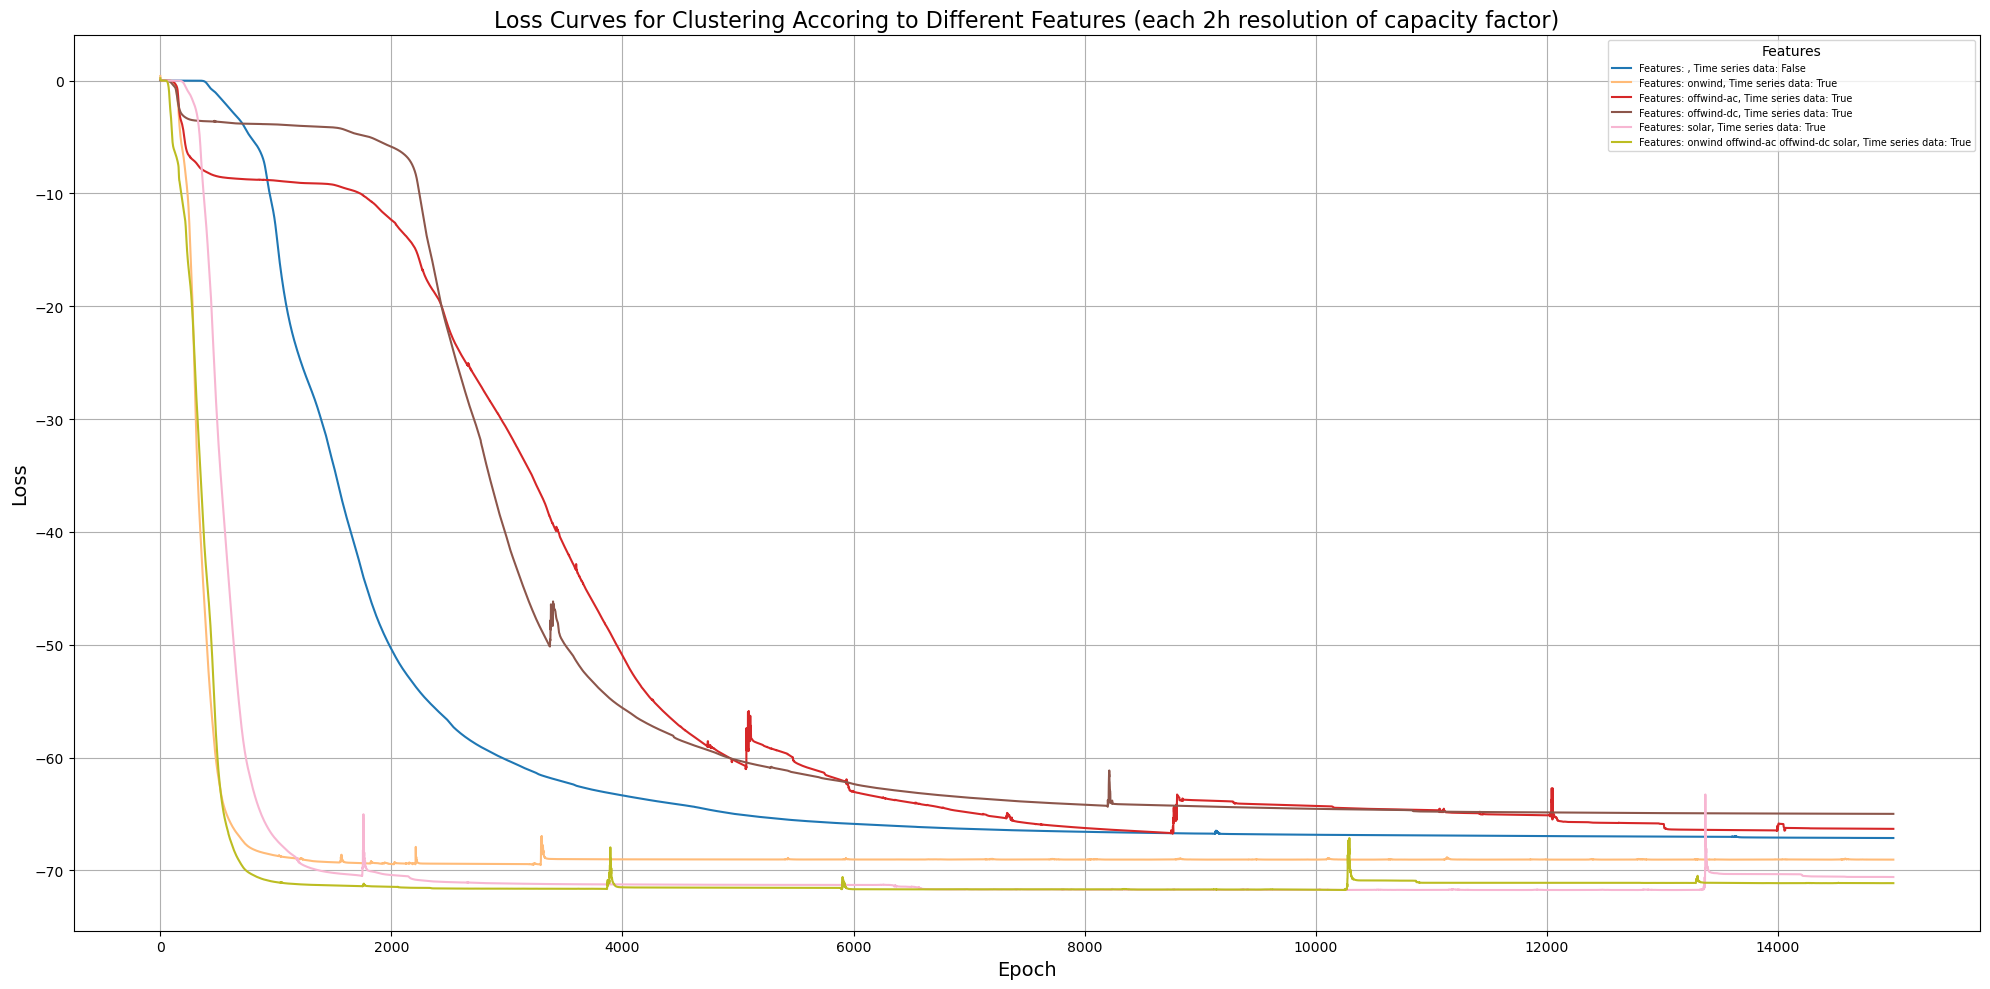

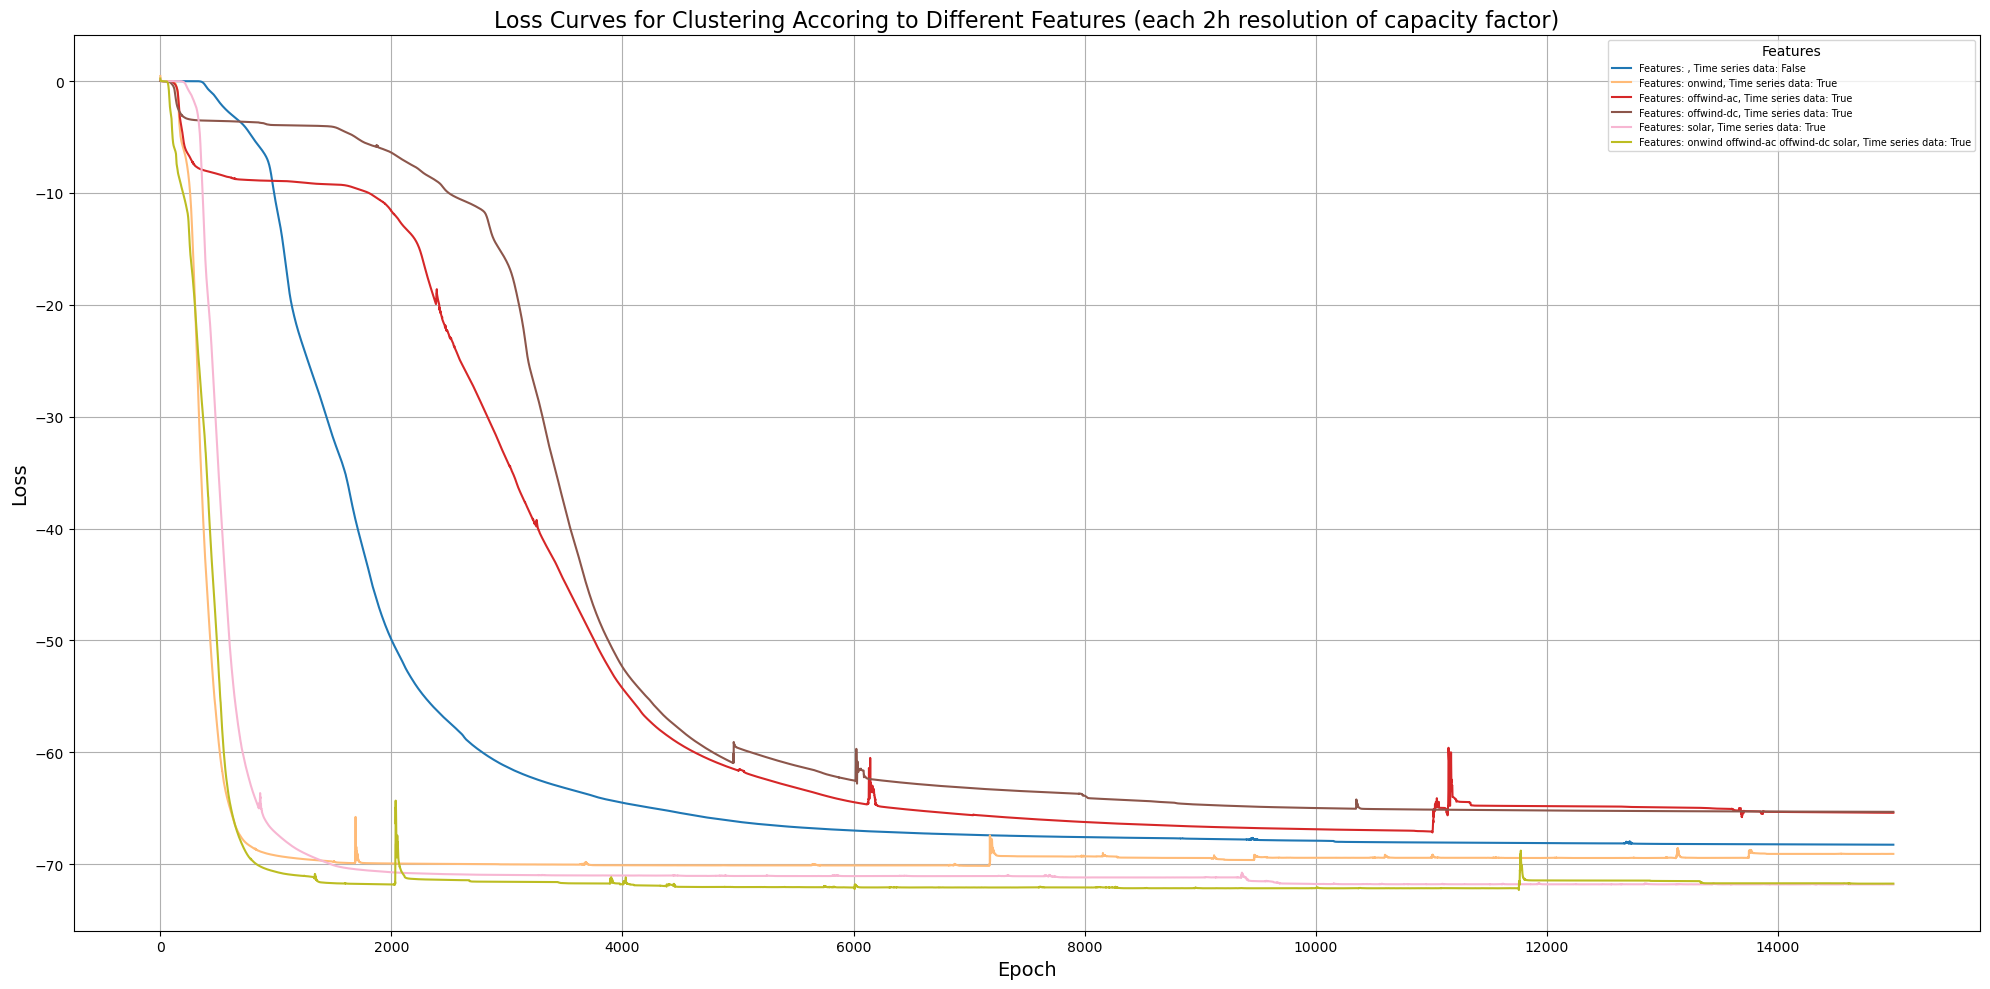

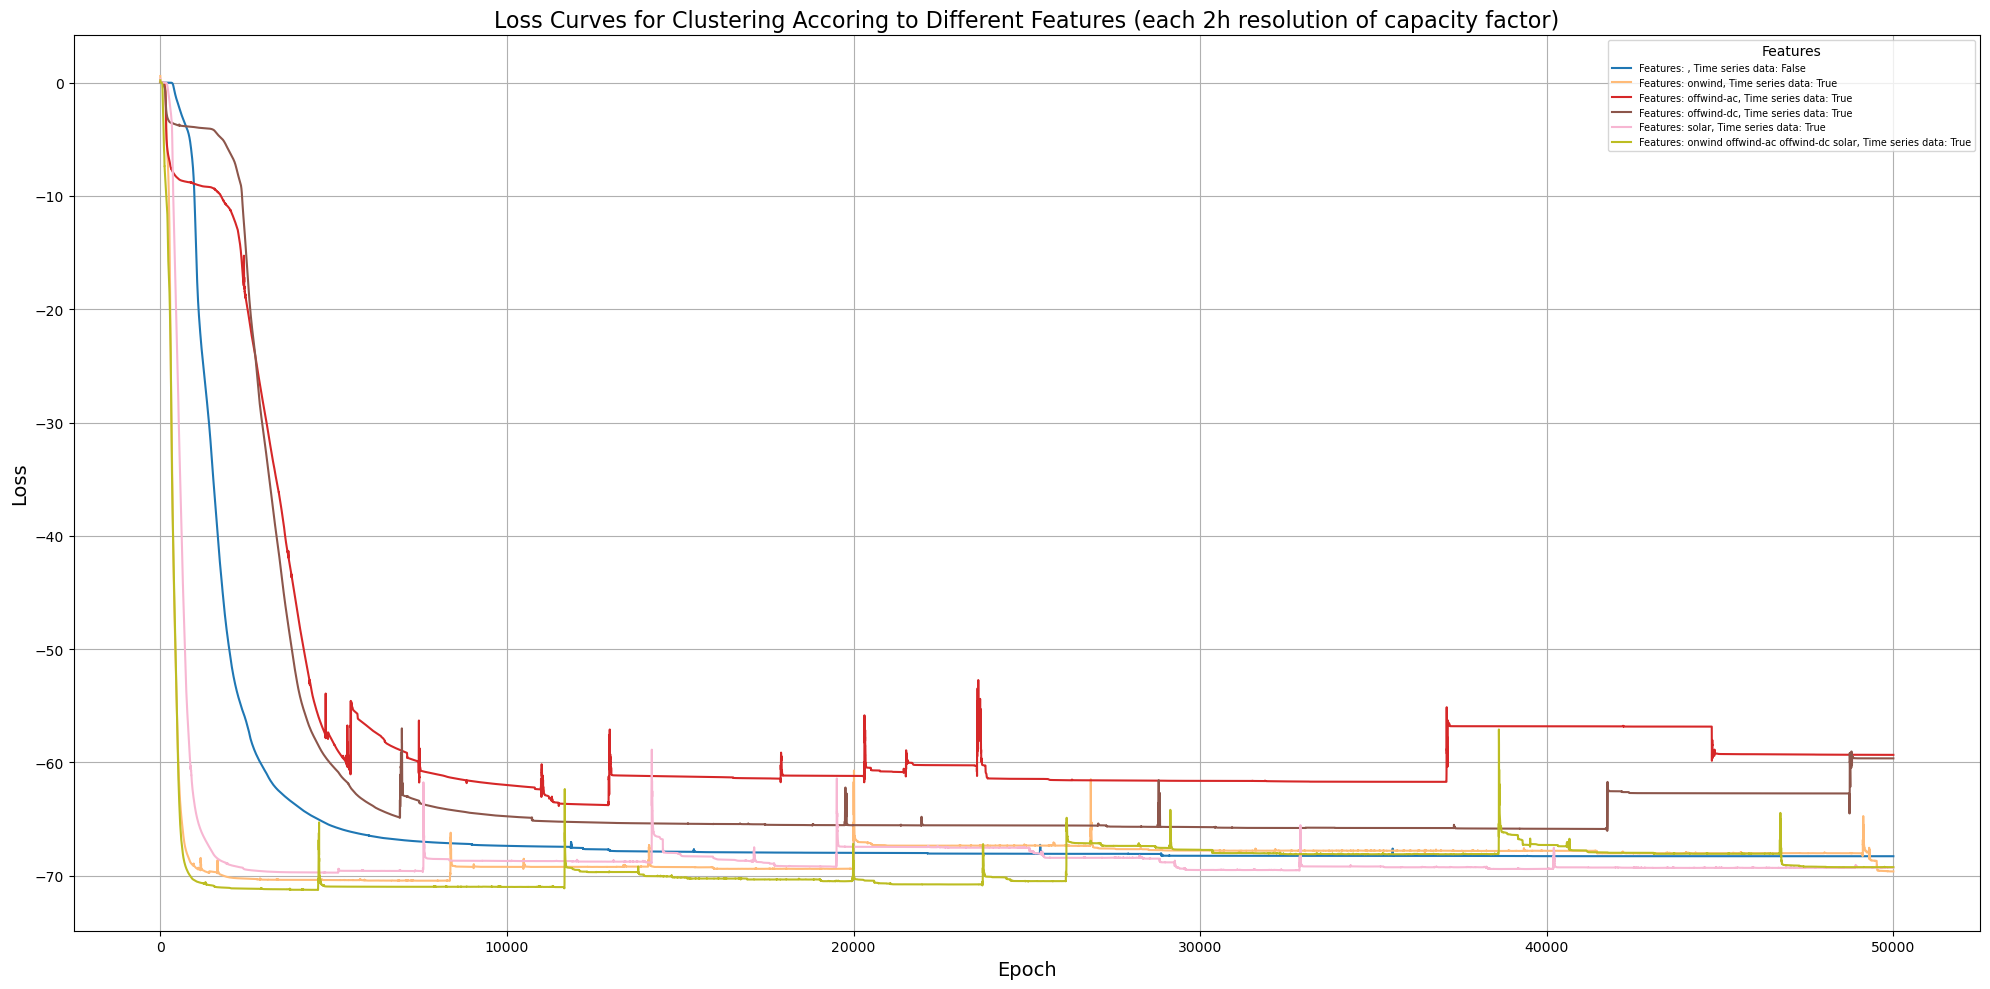

In [69]:
# 100

# loss curves for 100 clusters and different features to show that model learns well with chosen hyperparas
train_dic_100_EX1 = pd.read_pickle("/Users/ninakirsch/Desktop/my_files_for_github/lr00001_100/cf_15000_100_EX1/training_data.pkl")
train_dic_100_EX2 = pd.read_pickle("/Users/ninakirsch/Desktop/my_files_for_github/lr00001_100/cf_15000_100_EX2/training_data.pkl")
plot_loss_curves(train_dic_100_EX1)
plot_loss_curves(train_dic_100_EX2)

# for more epochs to show when to stop training
train_dic_100_50000 = pd.read_pickle("/Users/ninakirsch/Desktop/my_files_for_github/lr00001_100/cf_50000e_100cl_0.0001/training_data.pkl")

plot_loss_curves(train_dic_100_50000)

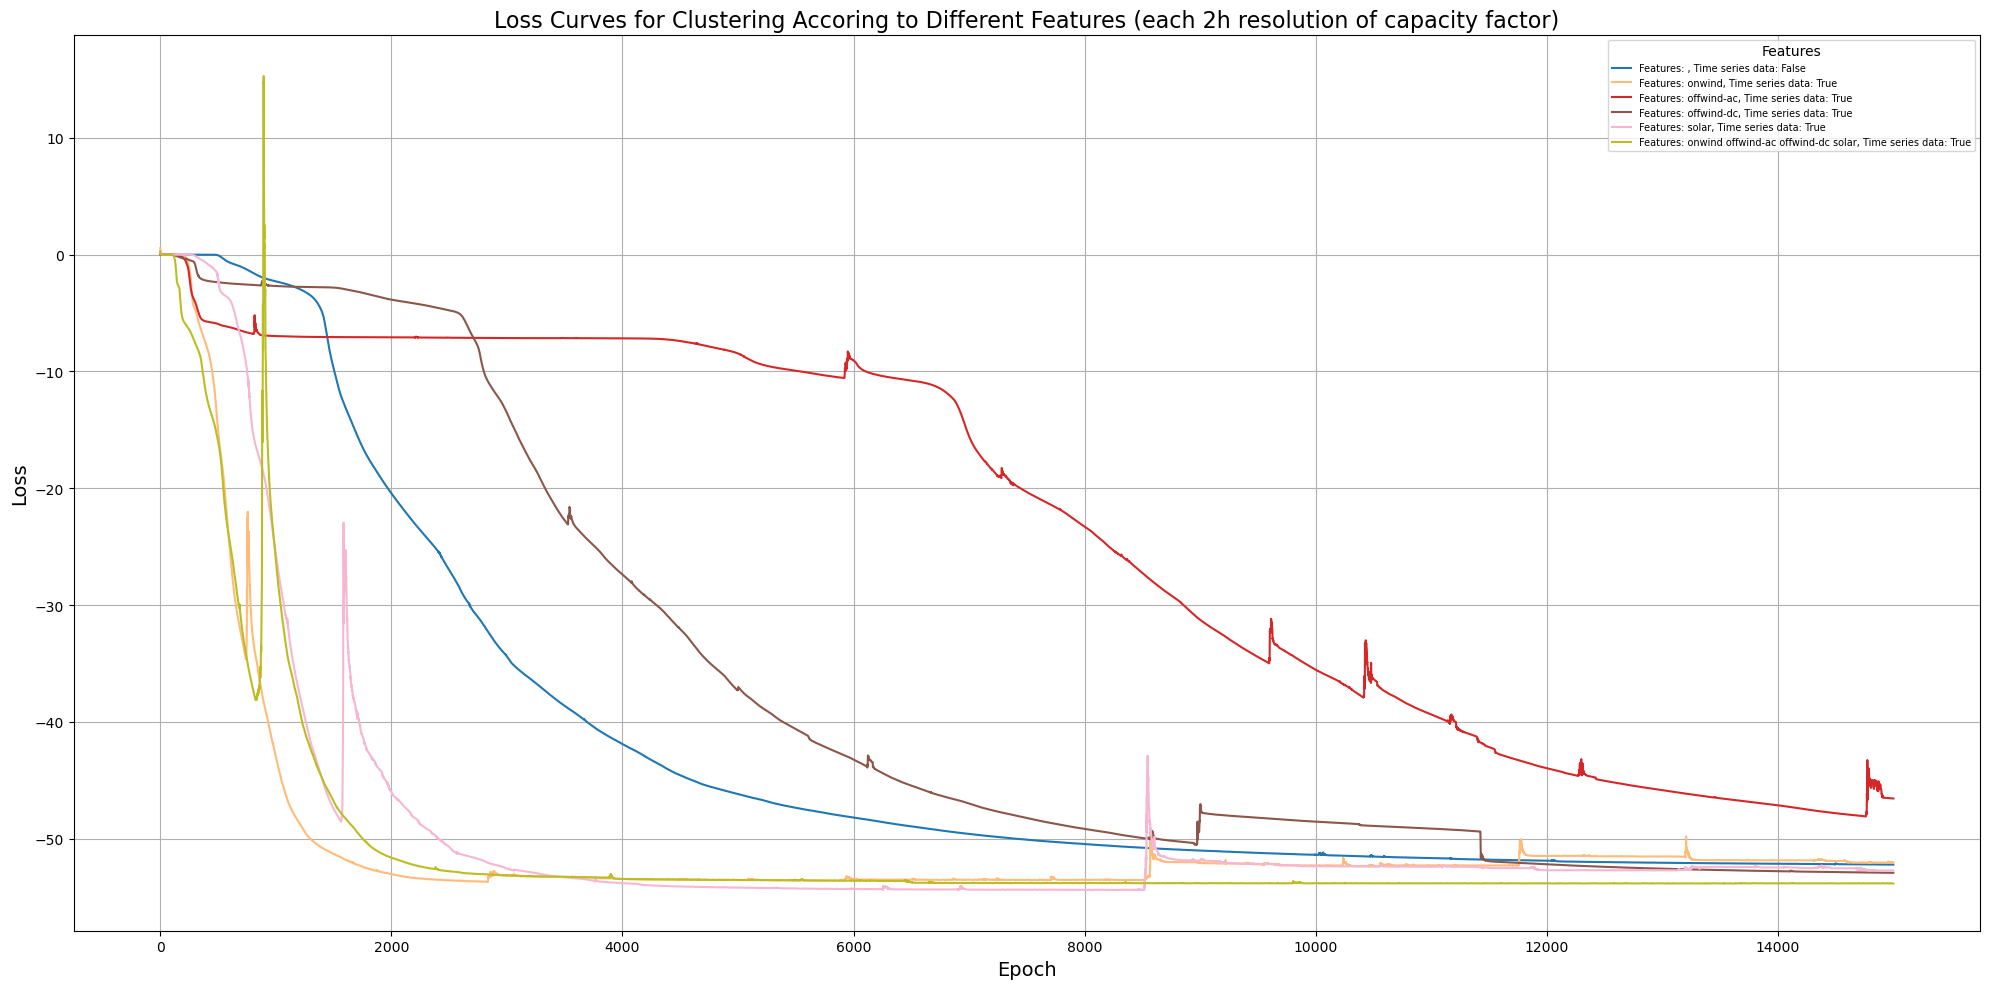

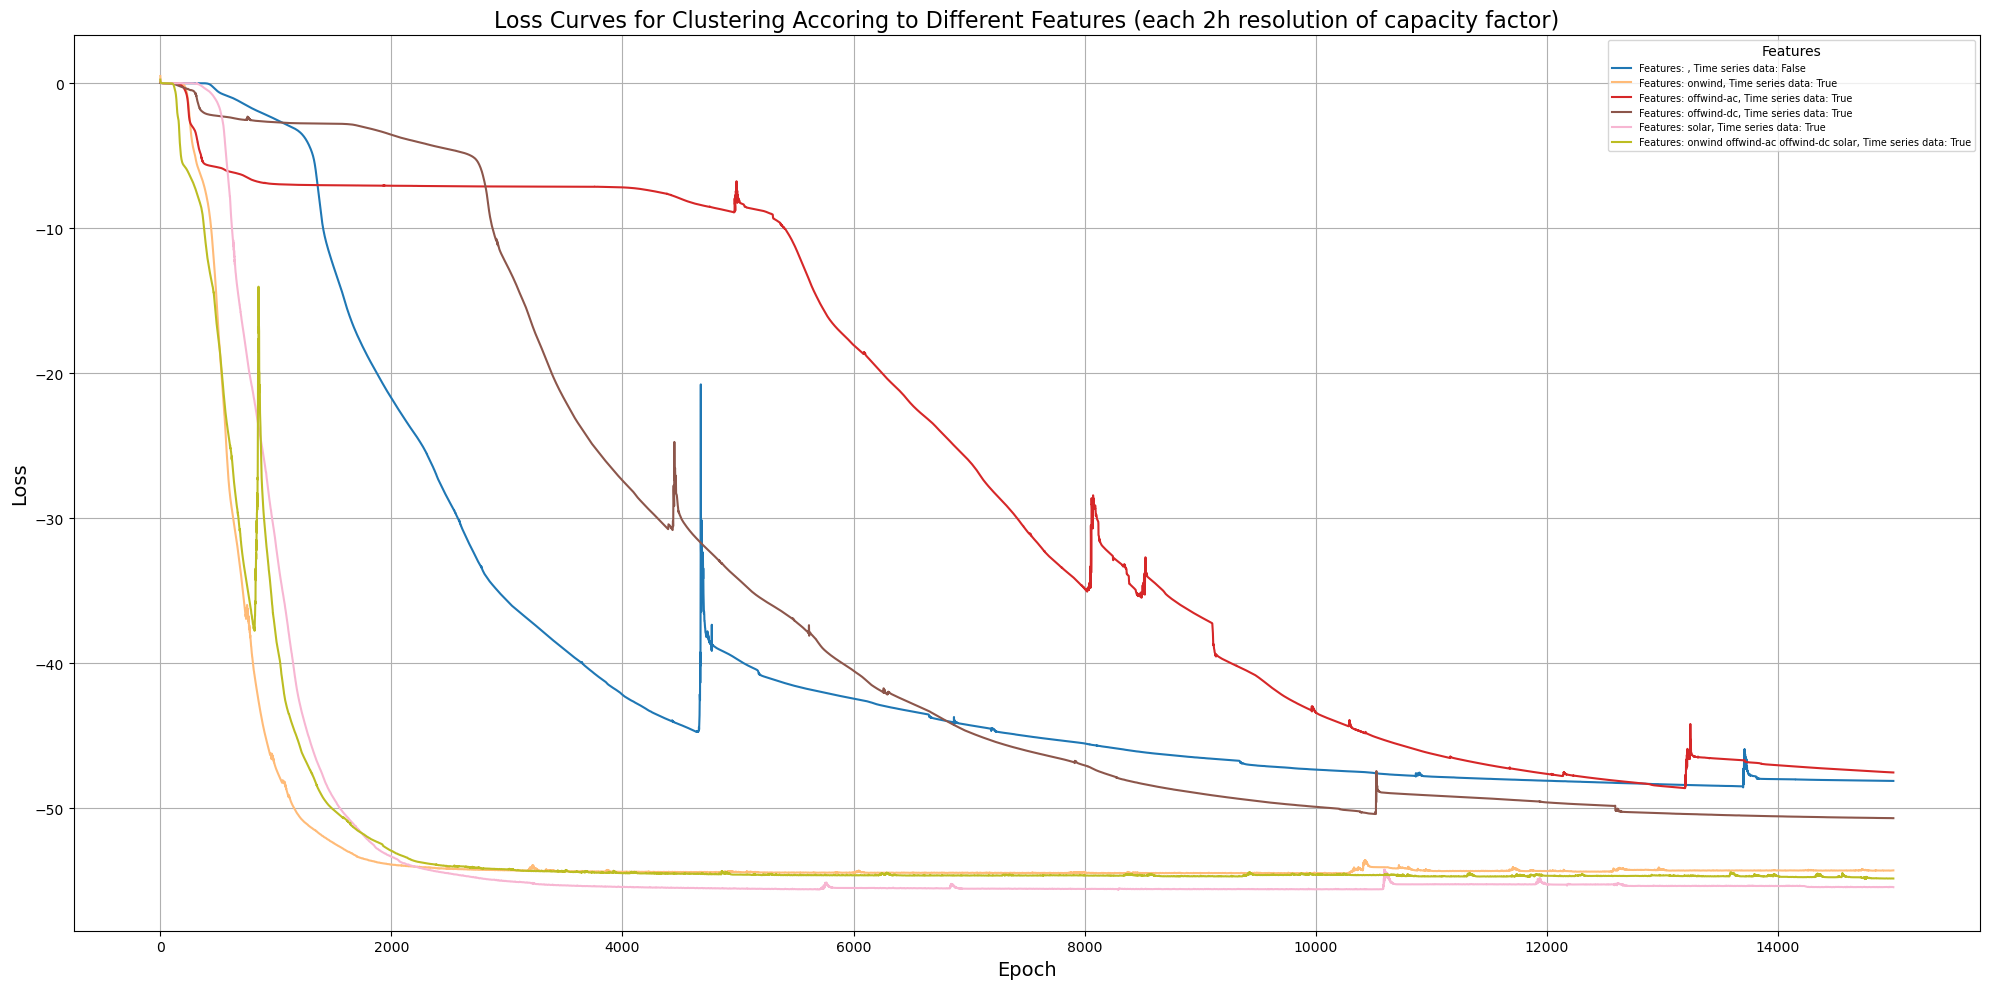

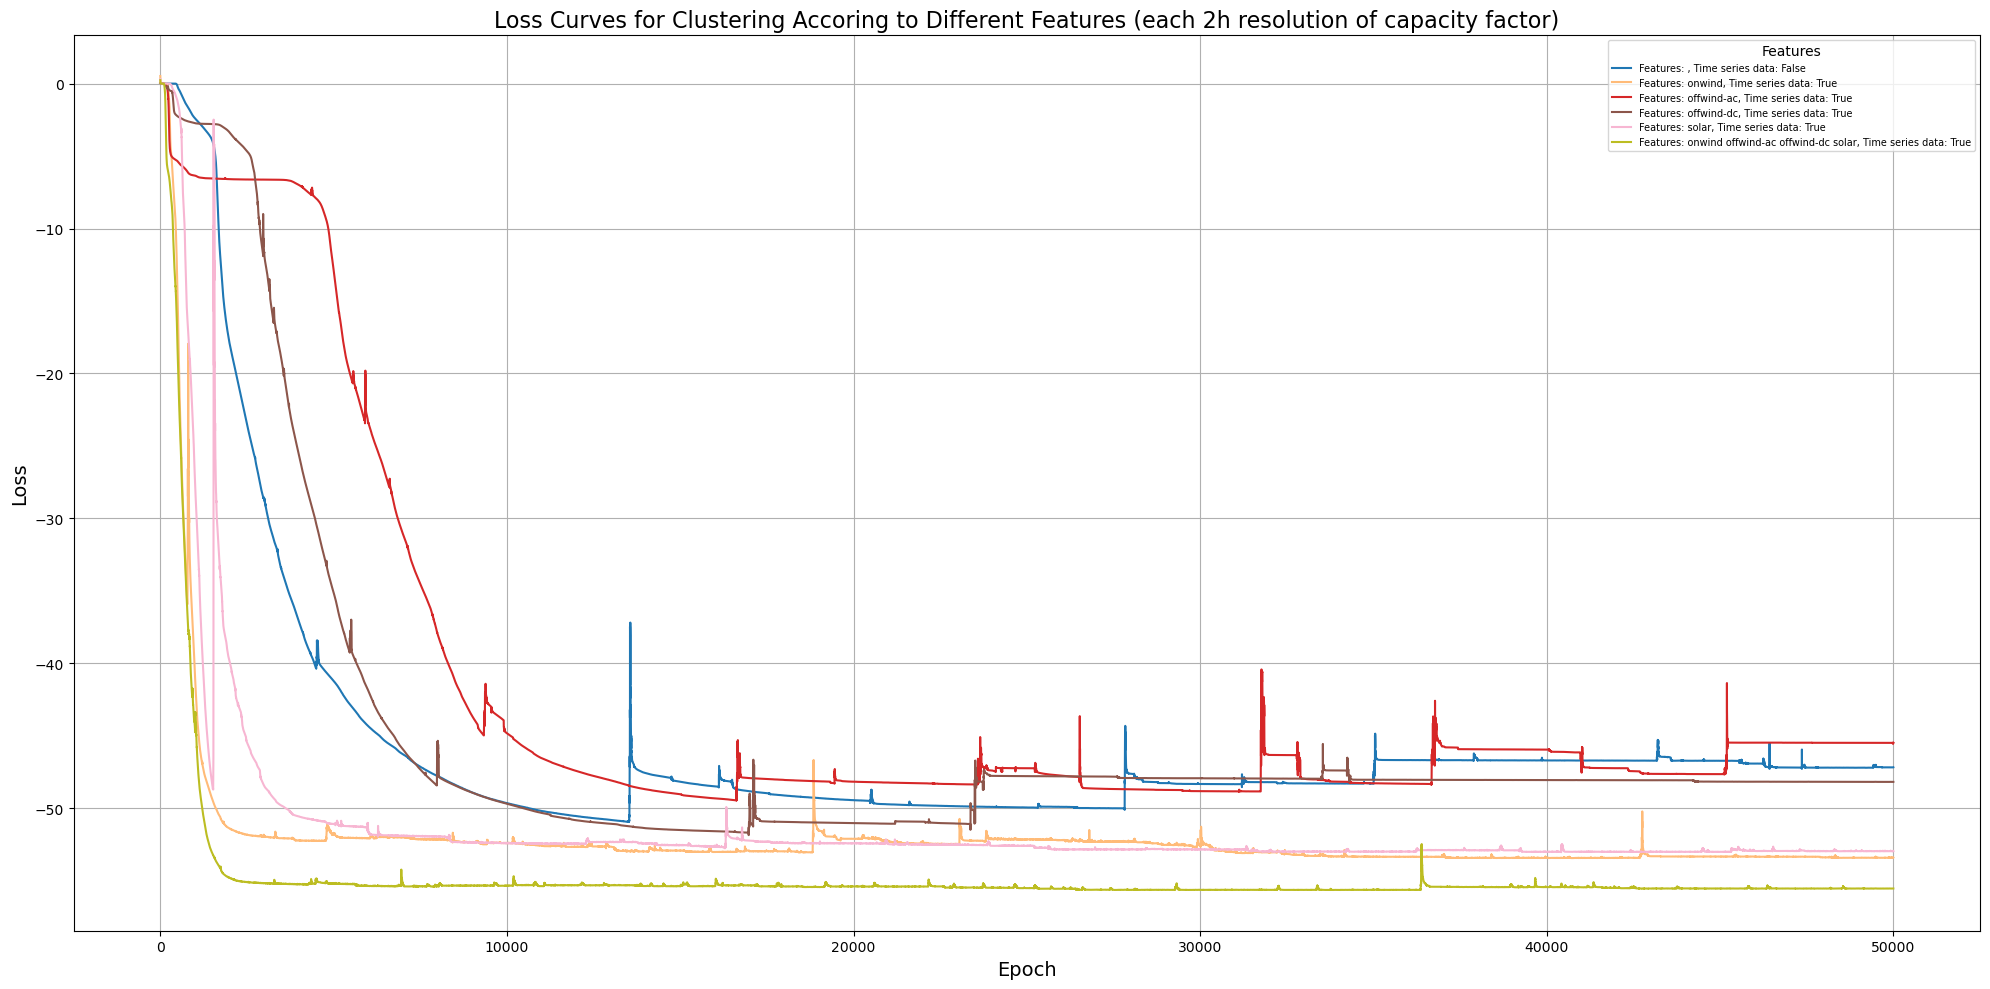

In [378]:
# 200

# loss curves for 200 clusters and different features to show that model learns well with chosen hyperparas
train_dic_200_EX1 = pd.read_pickle("/Users/ninakirsch/Desktop/my_files_for_github/lr00001_200/cf_15000_200_EX1/training_data.pkl")
train_dic_200_EX2 = pd.read_pickle("/Users/ninakirsch/Desktop/my_files_for_github/lr00001_200/cf_15000_200_EX2/training_data.pkl")
plot_loss_curves(train_dic_200_EX1)
plot_loss_curves(train_dic_200_EX2)

# for more epochs to show when to stop training
train_dic_200_50000 = pd.read_pickle("/Users/ninakirsch/Desktop/my_files_for_github/lr00001_200/cf_50000e_200cl_0.0001/training_data.pkl")
plot_loss_curves(train_dic_200_50000)

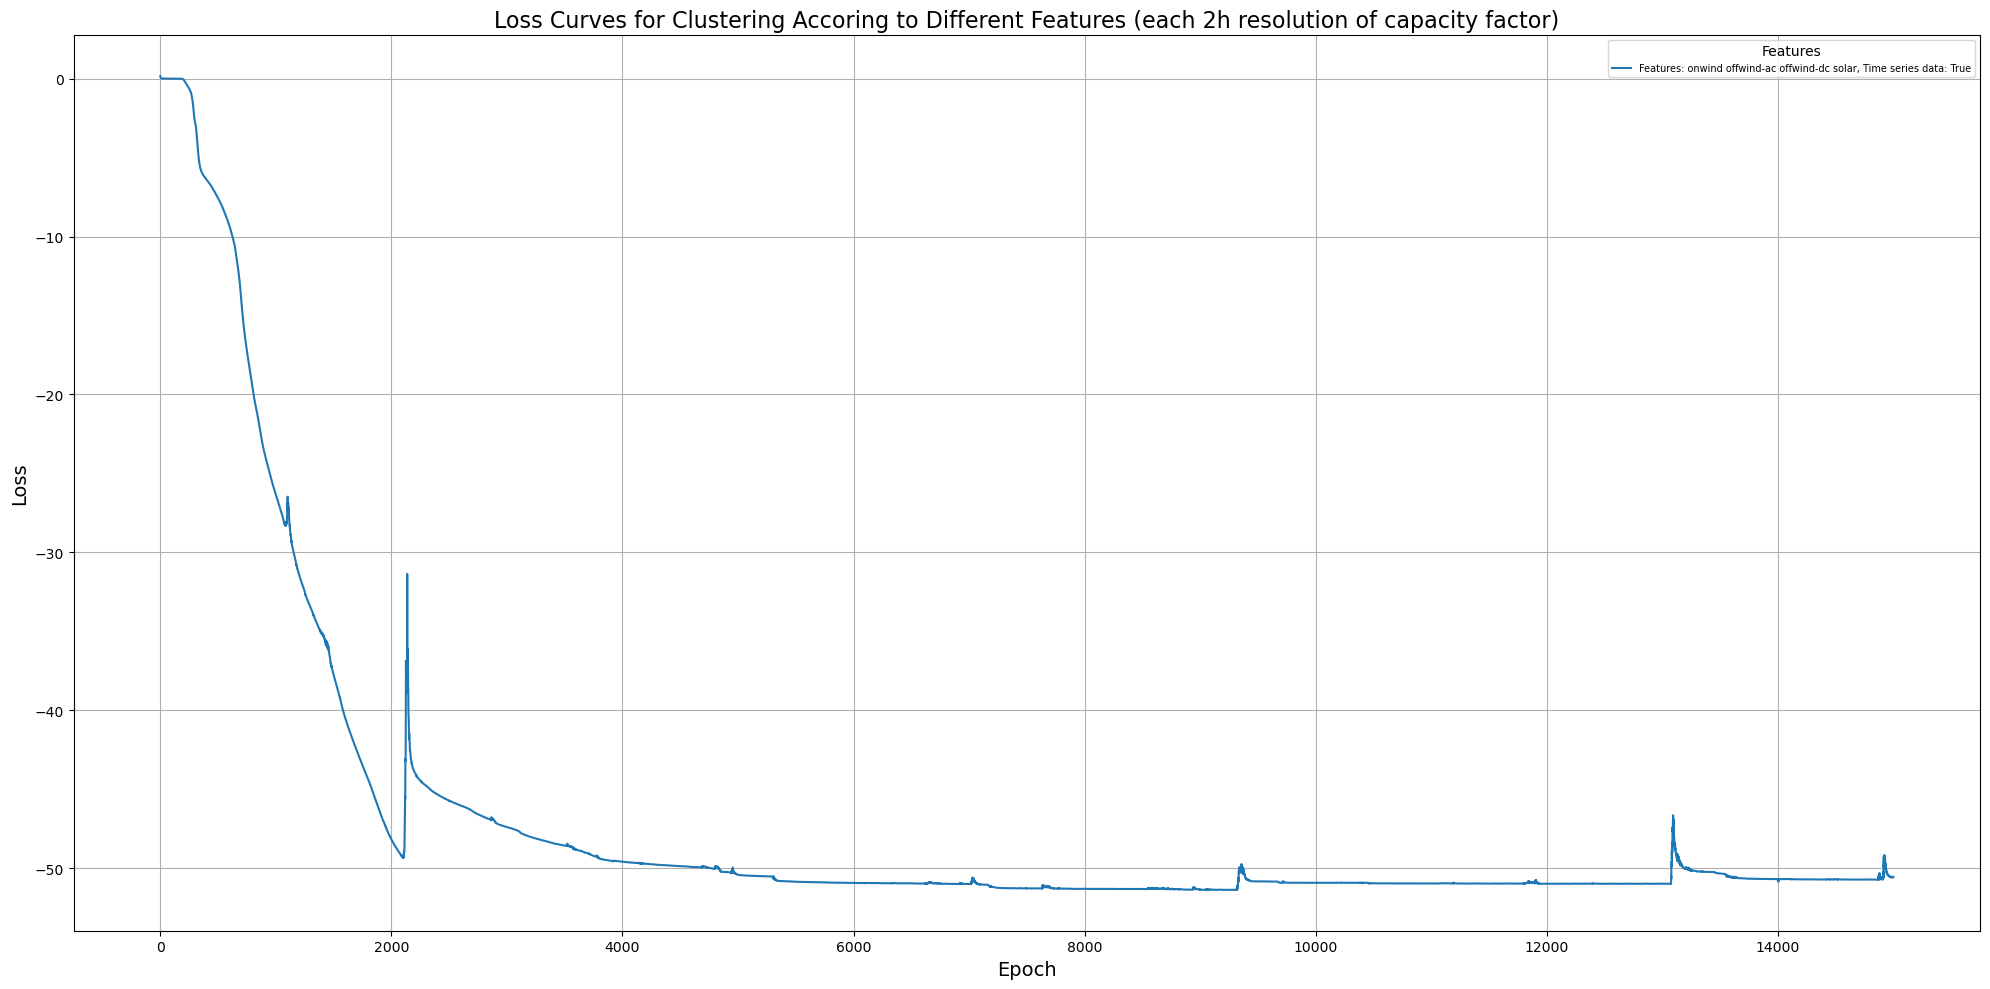

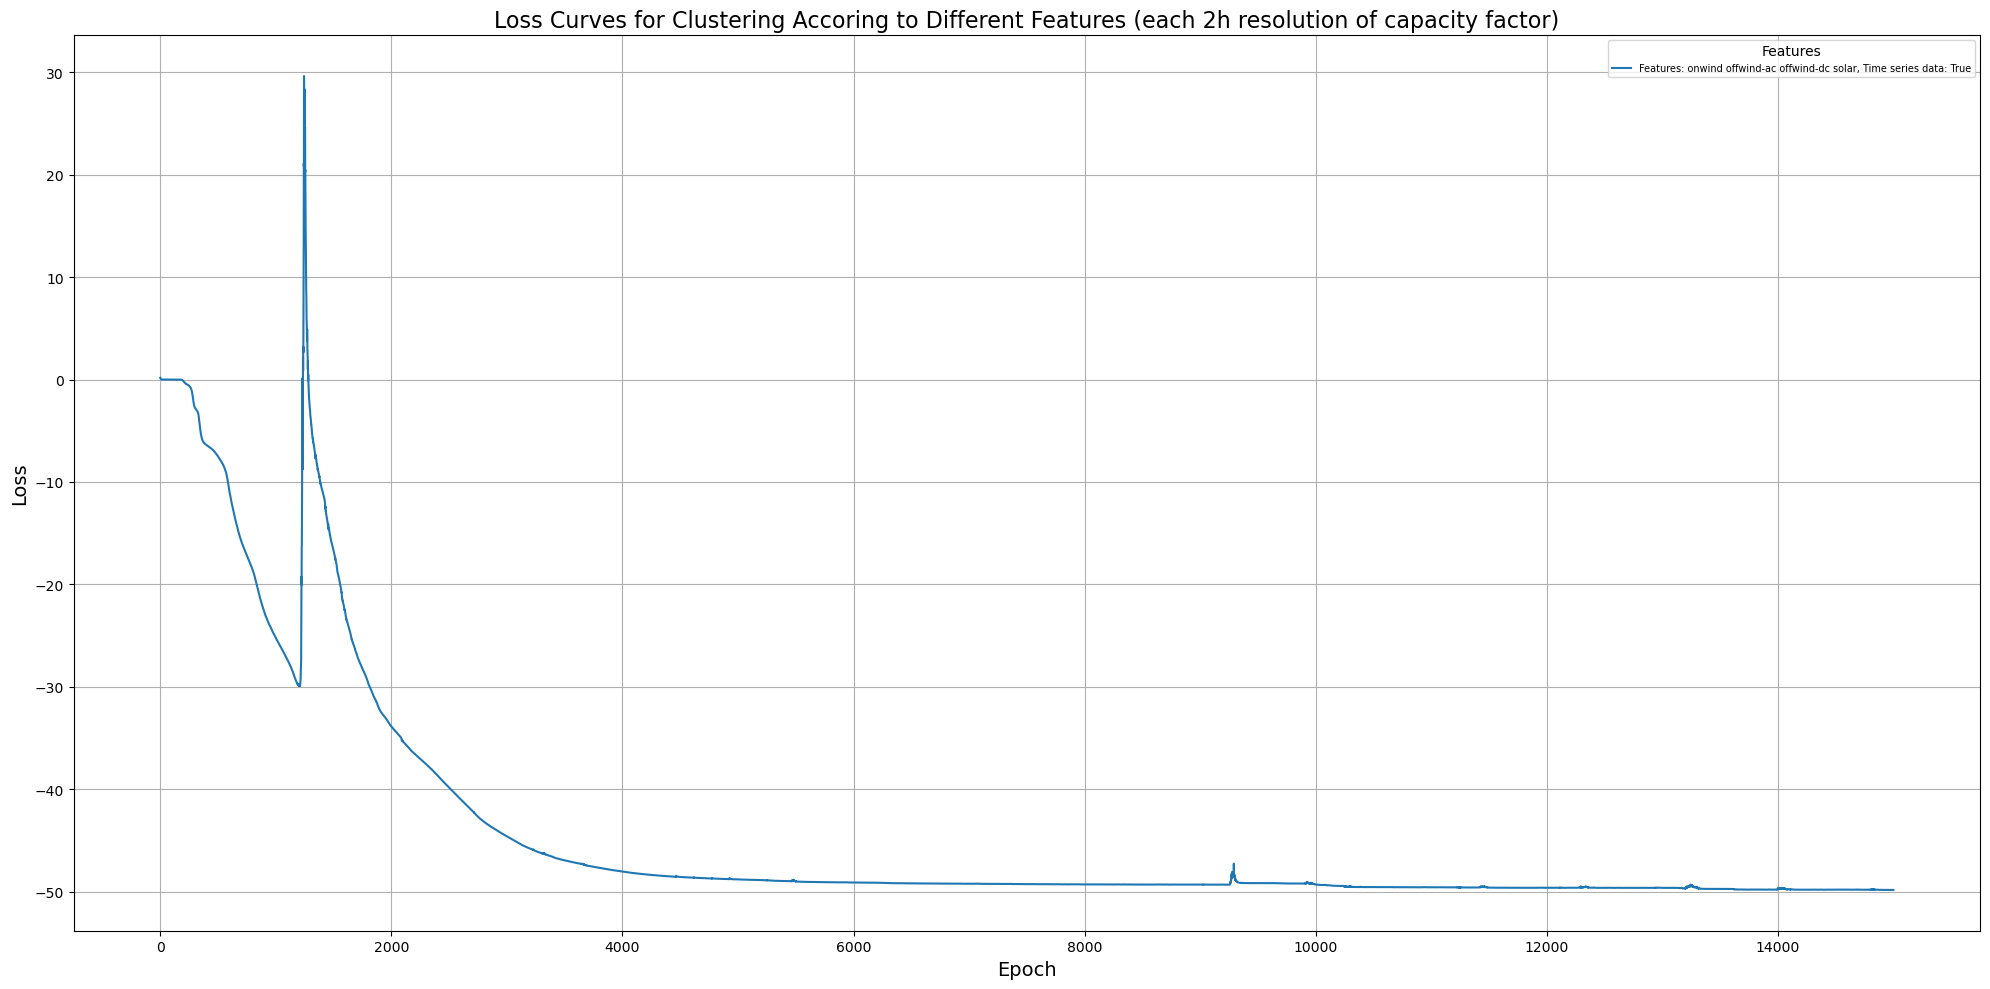

In [316]:
# some other feature
plot_loss_curves(pd.read_pickle("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment1/daily_average/cf_200_EX1/training_data.pkl"))
plot_loss_curves(pd.read_pickle("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment2/daily_average/cf_200_EX2/training_data.pkl"))

### 1.5.2) Spectral and cluster loss

In [21]:
# function for plotting both losses 
def plot_spectral_and_cluster_loss(training_data, colormap=plt.cm.tab20):
    num_colors = len(training_data)

    colors = [colormap(i / num_colors) for i in range(num_colors)]
    
    fig = plt.figure(figsize=(12, 8))

    idx = 0
    for key, result in training_data.items():
        spectral_losses = result["spectral_losses"]
        cluster_losses = result["cluster_losses"]
        label = f"Features: {' '.join(result['carriers'])}, Time series data = {result['include_time']}"

        color = colors[idx % len(colors)]
        
        plt.plot(range(len(spectral_losses)), spectral_losses, label=label, color=color)
        plt.plot(range(len(cluster_losses)), cluster_losses, label=label, color=color, linestyle='dashed')
        idx += 1


    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("Loss", fontsize=14)
    
    plt.title("Loss Curves for Spectral and Cluster Loss", fontsize=16)
    
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    
    # legend that says that solid lines are spectral loss and dashed lines are cluster loss
    legend2 = plt.legend(loc = "upper left", title="Loss Type", fontsize=10, labels=["Spectral Loss", "Cluster Loss"], title_fontsize=10)
    plt.legend(by_label.values(), by_label.keys(), title="Features", fontsize=10, loc='upper right')
    plt.gca().add_artist(legend2)
    
    plt.grid(True)  
    plt.tight_layout() 

    plt.show()     

In [ ]:
plot_spectral_and_cluster_loss(train_dic_100_EX1)

## 1.6) Performance of DMoN: Achieved losses

In [76]:
# 2h 16 clusters 
all_2h_16_EX1_testing = pd.read_pickle("/Users/ninakirsch/Desktop/my_files_for_github/lr00001_16/cf_15000_16_EX1/testing_data.pkl")["all"]
all_2h_16_EX2_testing = pd.read_pickle("/Users/ninakirsch/Desktop/my_files_for_github/lr00001_16/cf_15000_16_EX2/testing_data.pkl")["all"]
all_2h_16_EX3_testing = pd.read_pickle("/Users/ninakirsch/Desktop/my_files_for_github/lr00001_16/cf_15000_16_EX3/testing_data.pkl")["all"]
all_2h_16_EX4_testing = pd.read_pickle("/Users/ninakirsch/Desktop/my_files_for_github/lr00001_16/cf_15000_16_EX4/testing_data.pkl")["all"]
all_2h_16_EX5_testing = pd.read_pickle("/Users/ninakirsch/Desktop/my_files_for_github/lr00001_16/cf_15000_16_EX5/testing_data.pkl")["all"]
list_2h_all_16 = [all_2h_16_EX1_testing, all_2h_16_EX2_testing, all_2h_16_EX3_testing, all_2h_16_EX4_testing, all_2h_16_EX5_testing]

# 2h 100 clusters
all_2h_100_EX1_testing = pd.read_pickle("/Users/ninakirsch/Desktop/my_files_for_github/lr00001_100/cf_15000_100_EX1/testing_data.pkl")["all"]
all_2h_100_EX2_testing = pd.read_pickle("/Users/ninakirsch/Desktop/my_files_for_github/lr00001_100/cf_15000_100_EX2/testing_data.pkl")["all"]
all_2h_100_EX3_testing = pd.read_pickle("/Users/ninakirsch/Desktop/my_files_for_github/lr00001_100/cf_15000_100_EX3/testing_data.pkl")["all"]
all_2h_100_EX4_testing = pd.read_pickle("/Users/ninakirsch/Desktop/my_files_for_github/lr00001_100/cf_15000_100_EX4/testing_data.pkl")["all"]
all_2h_100_EX5_testing = pd.read_pickle("/Users/ninakirsch/Desktop/my_files_for_github/lr00001_100/cf_15000_100_EX5/testing_data.pkl")["all"]
list_2h_all_100 = [all_2h_100_EX1_testing, all_2h_100_EX2_testing, all_2h_100_EX3_testing, all_2h_100_EX4_testing, all_2h_100_EX5_testing]

# 2h 200 clusters
all_2h_200_EX1_testing = pd.read_pickle("/Users/ninakirsch/Desktop/my_files_for_github/lr00001_200/cf_15000_200_EX1/testing_data.pkl")["all"]
all_2h_200_EX2_testing = pd.read_pickle("/Users/ninakirsch/Desktop/my_files_for_github/lr00001_200/cf_15000_200_EX2/testing_data.pkl")["all"]
all_2h_200_EX3_testing = pd.read_pickle("/Users/ninakirsch/Desktop/my_files_for_github/lr00001_200/cf_15000_200_EX3/testing_data.pkl")["all"]
all_2h_200_EX4_testing = pd.read_pickle("/Users/ninakirsch/Desktop/my_files_for_github/lr00001_200/cf_15000_200_EX4/testing_data.pkl")["all"]
all_2h_200_EX5_testing = pd.read_pickle("/Users/ninakirsch/Desktop/my_files_for_github/lr00001_200/cf_15000_200_EX5/testing_data.pkl")["all"]
list_2h_all_200 = [all_2h_200_EX1_testing, all_2h_200_EX2_testing, all_2h_200_EX3_testing, all_2h_200_EX4_testing, all_2h_200_EX5_testing]

In [77]:
# for daily variance
# 16 clusters
all_daily_average_16_EX1_testing = pd.read_pickle("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment1/daily_average/cf_16_EX1/testing_data.pkl")["all"]
all_daily_average_16_EX2_testing = pd.read_pickle("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment2/daily_average/cf_16_EX2/testing_data.pkl")["all"]
all_daily_average_16_EX3_testing = pd.read_pickle("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment3/daily_average/cf_16_EX3/testing_data.pkl")["all"]
all_daily_average_16_EX4_testing = pd.read_pickle("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment4/daily_average/cf_16_EX4/testing_data.pkl")["all"]
all_daily_average_16_EX5_testing = pd.read_pickle("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment5/daily_average/cf_16_EX5/testing_data.pkl")["all"]

list_daily_average_16 = [all_daily_average_16_EX1_testing, all_daily_average_16_EX2_testing, all_daily_average_16_EX3_testing, all_daily_average_16_EX4_testing, all_daily_average_16_EX5_testing]

# 100 
all_daily_average_100_EX1_testing = pd.read_pickle("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment1/daily_average/cf_100_EX1/testing_data.pkl")["all"]
all_daily_average_100_EX2_testing = pd.read_pickle("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment2/daily_average/cf_100_EX2/testing_data.pkl")["all"]
all_daily_average_100_EX3_testing = pd.read_pickle("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment3/daily_average/cf_100_EX3/testing_data.pkl")["all"]
all_daily_average_100_EX4_testing = pd.read_pickle("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment4/daily_average/cf_100_EX4/testing_data.pkl")["all"]
all_daily_average_100_EX5_testing = pd.read_pickle("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment5/daily_average/cf_100_EX5/testing_data.pkl")["all"]
list_daily_average_100 = [all_daily_average_100_EX1_testing, all_daily_average_100_EX2_testing, all_daily_average_100_EX3_testing, all_daily_average_100_EX4_testing, all_daily_average_100_EX5_testing]

# 200 
all_daily_average_200_EX1_testing = pd.read_pickle("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment1/daily_average/cf_200_EX1/testing_data.pkl")["all"]
all_daily_average_200_EX2_testing = pd.read_pickle("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment2/daily_average/cf_200_EX2/testing_data.pkl")["all"]
all_daily_average_200_EX3_testing = pd.read_pickle("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment3/daily_average/cf_200_EX3/testing_data.pkl")["all"]
all_daily_average_200_EX4_testing = pd.read_pickle("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment4/daily_average/cf_200_EX4/testing_data.pkl")["all"]
all_daily_average_200_EX5_testing = pd.read_pickle("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment5/daily_average/cf_200_EX5/testing_data.pkl")["all"]
list_daily_average_200 = [all_daily_average_200_EX1_testing, all_daily_average_200_EX2_testing, all_daily_average_200_EX3_testing, all_daily_average_200_EX4_testing, all_daily_average_200_EX5_testing]

In [74]:
# for daily variance and avergae
# 16 clusters
all_daily_var_and_average_16_EX1_testing = pd.read_pickle("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment1/daily_varianceAndAverage/cf_16_EX1/testing_data.pkl")["all"]
all_daily_var_and_average_16_EX2_testing = pd.read_pickle("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment2/daily_varianceAndAverage/cf_16_EX2/testing_data.pkl")["all"]
all_daily_var_and_average_16_EX3_testing = pd.read_pickle("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment3/daily_varianceAndAverage/cf_16_EX3/testing_data.pkl")["all"]
all_daily_var_and_average_16_EX4_testing = pd.read_pickle("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment4/daily_varianceAndAverage/cf_16_EX4/testing_data.pkl")["all"]
all_daily_var_and_average_16_EX5_testing = pd.read_pickle("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment5/daily_varianceAndAverage/cf_16_EX5/testing_data.pkl")["all"]
list_daily_var_and_average_16 = [all_daily_var_and_average_16_EX1_testing, all_daily_var_and_average_16_EX2_testing, all_daily_var_and_average_16_EX3_testing, all_daily_var_and_average_16_EX4_testing, all_daily_var_and_average_16_EX5_testing]

# 100
all_daily_var_and_average_100_EX1_testing = pd.read_pickle("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment1/daily_varianceAndAverage/cf_100_EX1/testing_data.pkl")["all"]
all_daily_var_and_average_100_EX2_testing = pd.read_pickle("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment2/daily_varianceAndAverage/cf_100_EX2/testing_data.pkl")["all"]
all_daily_var_and_average_100_EX3_testing = pd.read_pickle("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment3/daily_varianceAndAverage/cf_100_EX3/testing_data.pkl")["all"]
all_daily_var_and_average_100_EX4_testing = pd.read_pickle("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment4/daily_varianceAndAverage/cf_100_EX4/testing_data.pkl")["all"]
all_daily_var_and_average_100_EX5_testing = pd.read_pickle("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment5/daily_varianceAndAverage/cf_100_EX5/testing_data.pkl")["all"]
list_daily_var_and_average_100 = [all_daily_var_and_average_100_EX1_testing, all_daily_var_and_average_100_EX2_testing, all_daily_var_and_average_100_EX3_testing, all_daily_var_and_average_100_EX4_testing, all_daily_var_and_average_100_EX5_testing]

# 200
all_daily_var_and_average_200_EX1_testing = pd.read_pickle("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment1/daily_varianceAndAverage/cf_200_EX1/testing_data.pkl")["all"]
all_daily_var_and_average_200_EX2_testing = pd.read_pickle("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment2/daily_varianceAndAverage/cf_200_EX2/testing_data.pkl")["all"]
all_daily_var_and_average_200_EX3_testing = pd.read_pickle("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment3/daily_varianceAndAverage/cf_200_EX3/testing_data.pkl")["all"]
all_daily_var_and_average_200_EX4_testing = pd.read_pickle("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment4/daily_varianceAndAverage/cf_200_EX4/testing_data.pkl")["all"]
all_daily_var_and_average_200_EX5_testing = pd.read_pickle("/Users/ninakirsch/Desktop/my_files_for_github/script_for_abgabe/experiment5/daily_varianceAndAverage/cf_200_EX5/testing_data.pkl")["all"]
list_daily_var_and_average_200 = [all_daily_var_and_average_200_EX1_testing, all_daily_var_and_average_200_EX2_testing, all_daily_var_and_average_200_EX3_testing, all_daily_var_and_average_200_EX4_testing, all_daily_var_and_average_200_EX5_testing]


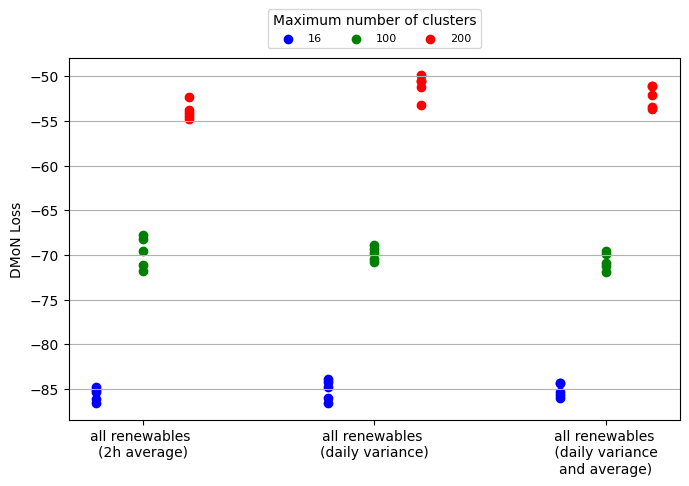

In [84]:
losses_16_avg = [dic["loss"] for dic in list_2h_all_16]
losses_100_avg = [dic["loss"] for dic in list_2h_all_100]
losses_200_avg = [dic["loss"] for dic in list_2h_all_200]

losses_16_var = [dic["loss"] for dic in list_daily_average_16]
losses_100_var = [dic["loss"] for dic in list_daily_average_100]
losses_200_var = [dic["loss"] for dic in list_daily_average_200]

losses_16_avgVar = [dic["loss"] for dic in list_daily_var_and_average_16]
losses_100_avgVar = [dic["loss"] for dic in list_daily_var_and_average_100]
losses_200_avgVar = [dic["loss"] for dic in list_daily_var_and_average_200]


fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter([1] * len(losses_16_avg), losses_16_avg, c="blue", label="16")
ax.scatter([1.1] * len(losses_100_avg), losses_100_avg, c="green", label="100")
ax.scatter([1.2] * len(losses_200_avg), losses_200_avg, c="red", label="200")

ax.scatter([1.5] * len(losses_16_var), losses_16_var, c="blue")
ax.scatter([1.6] * len(losses_100_var), losses_100_var, c="green")
ax.scatter([1.7] * len(losses_200_var), losses_200_var, c="red")

ax.scatter([2] * len(losses_16_avgVar), losses_16_avgVar, c="blue")
ax.scatter([2.1] * len(losses_100_avgVar), losses_100_avgVar, c="green")
ax.scatter([2.2] * len(losses_200_avgVar), losses_200_avgVar, c="red")


ax.set_ylabel("DMoN Loss", fontsize=10)
ax.tick_params(axis='y', labelsize=10)


ax.set_xticks([1.1, 1.6, 2.1])
ax.set_xticklabels(["all renewables \n(2h average)", "all renewables \n(daily variance)", "all renewables \n (daily variance \nand average)"], fontsize=10)
ax.yaxis.grid(True)

ax.legend(loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.15), title="Maximum number of clusters", fontsize=8)
#ax.legend(title="Maximum number of cluster", fontsize=10, loc='lower right')

#ax.set_title("Loss vs. Cluster Size for Different Feature Groups")

plt.tight_layout()
plt.show()


# !!! Here: start of things that are not included in thesis in the end and were used before to understand results and to try out

older things, that show that achieved losses are similar

In [36]:
# solar features: dataframe for loss, spectral loss and cluster loss in test data
df_loss_16_solar = pd.DataFrame(index = ["EX1", "EX2", "EX3", "EX4", "EX5"],
                          data = {"Loss": [test_dic_16_EX1["solar"]["loss"], test_dic_16_EX2["solar"]["loss"], test_dic_16_EX3["solar"]["loss"], test_dic_16_EX4["solar"]["loss"], test_dic_16_EX5["solar"]["loss"]],
                                    "Spectral Loss": [test_dic_16_EX1["solar"]["spectral_loss"], test_dic_16_EX2["solar"]["spectral_loss"], test_dic_16_EX3["solar"]["spectral_loss"], test_dic_16_EX4["solar"]["spectral_loss"], test_dic_16_EX5["solar"]["spectral_loss"]],
                                    "Cluster Loss": [test_dic_16_EX1["solar"]["cluster_loss"], test_dic_16_EX2["solar"]["cluster_loss"], test_dic_16_EX3["solar"]["cluster_loss"], test_dic_16_EX4["solar"]["cluster_loss"], test_dic_16_EX5["solar"]["cluster_loss"]]})
df_loss_16_solar

,Loss,Spectral Loss,Cluster Loss
EX1,-84.984955,-86.532486,1.547527
EX2,-85.479042,-86.908073,1.429033
EX3,-86.776726,-87.167671,0.390947
EX4,-85.418633,-86.022751,0.604117
EX5,-85.151459,-86.562416,1.410961


In [80]:
df_loss_16__onwind = pd.DataFrame(index = ["EX1", "EX2", "EX3", "EX4", "EX5"],
                            data = {"Loss": [test_dic_16_EX1["onwind"]["loss"], test_dic_16_EX2["onwind"]["loss"], test_dic_16_EX3["onwind"]["loss"], test_dic_16_EX4["onwind"]["loss"], test_dic_16_EX5["onwind"]["loss"]],
                                        "Spectral Loss": [test_dic_16_EX1["onwind"]["spectral_loss"], test_dic_16_EX2["onwind"]["spectral_loss"], test_dic_16_EX3["onwind"]["spectral_loss"], test_dic_16_EX4["onwind"]["spectral_loss"], test_dic_16_EX5["onwind"]["spectral_loss"]],
                                        "Cluster Loss": [test_dic_16_EX1["onwind"]["cluster_loss"], test_dic_16_EX2["onwind"]["cluster_loss"], test_dic_16_EX3["onwind"]["cluster_loss"], test_dic_16_EX4["onwind"]["cluster_loss"], test_dic_16_EX5["onwind"]["cluster_loss"]]})
df_loss_16__onwind.round(2)

,Loss,Spectral Loss,Cluster Loss
EX1,-86.27,-87.25,0.98
EX2,-86.55,-87.19,0.64
EX3,-86.65,-87.26,0.61
EX4,-86.81,-87.54,0.73
EX5,-85.46,-86.33,0.86


100

In [74]:
# all: 
df_loss_100_all = pd.DataFrame(index = ["EX1", "EX2", "EX3", "EX4", "EX5"],
                           data = {"Loss": [test_dic_100_EX1["all"]["loss"], test_dic_100_EX2["all"]["loss"], test_dic_100_EX3["all"]["loss"], test_dic_100_EX4["all"]["loss"], test_dic_100_EX5["all"]["loss"]],
                                   "Spectral Loss": [test_dic_100_EX1["all"]["spectral_loss"], test_dic_100_EX2["all"]["spectral_loss"], test_dic_100_EX3["all"]["spectral_loss"], test_dic_100_EX4["all"]["spectral_loss"], test_dic_100_EX5["all"]["spectral_loss"]],
                                   "Cluster Loss": [test_dic_100_EX1["all"]["cluster_loss"], test_dic_100_EX2["all"]["cluster_loss"], test_dic_100_EX3["all"]["cluster_loss"], test_dic_100_EX4["all"]["cluster_loss"], test_dic_100_EX5["all"]["cluster_loss"]]})
df_loss_100_all.round(2)

,Loss,Spectral Loss,Cluster Loss
EX1,-71.14,-78.11,6.97
EX2,-71.74,-77.56,5.82
EX3,-67.79,-78.31,10.52
EX4,-68.20,-74.58,6.39
EX5,-69.50,-77.86,8.36


In [75]:
# onwind:
df_loss_100_onwind = pd.DataFrame(index = ["EX1", "EX2", "EX3", "EX4", "EX5"],
                           data = {"Loss": [test_dic_100_EX1["onwind"]["loss"], test_dic_100_EX2["onwind"]["loss"], test_dic_100_EX3["onwind"]["loss"], test_dic_100_EX4["onwind"]["loss"], test_dic_100_EX5["onwind"]["loss"]],
                                   "Spectral Loss": [test_dic_100_EX1["onwind"]["spectral_loss"], test_dic_100_EX2["onwind"]["spectral_loss"], test_dic_100_EX3["onwind"]["spectral_loss"], test_dic_100_EX4["onwind"]["spectral_loss"], test_dic_100_EX5["onwind"]["spectral_loss"]],
                                   "Cluster Loss": [test_dic_100_EX1["onwind"]["cluster_loss"], test_dic_100_EX2["onwind"]["cluster_loss"], test_dic_100_EX3["onwind"]["cluster_loss"], test_dic_100_EX4["onwind"]["cluster_loss"], test_dic_100_EX5["onwind"]["cluster_loss"]]})
df_loss_100_onwind.round(2)

,Loss,Spectral Loss,Cluster Loss
EX1,-69.05,-77.16,8.11
EX2,-69.08,-77.56,8.48
EX3,-67.76,-77.32,9.55
EX4,-69.02,-77.59,8.58
EX5,-69.22,-77.04,7.82


In [76]:
df_loss_only_coordinates = pd.DataFrame(index = ["EX1", "EX2", "EX3", "EX4", "EX5"],
                            data = {"Loss": [test_dic_100_EX1["only_coordinates"]["loss"], test_dic_100_EX2["only_coordinates"]["loss"], test_dic_100_EX3["only_coordinates"]["loss"], test_dic_100_EX4["only_coordinates"]["loss"], test_dic_100_EX5["only_coordinates"]["loss"]],
                                      "Spectral Loss": [test_dic_100_EX1["only_coordinates"]["spectral_loss"], test_dic_100_EX2["only_coordinates"]["spectral_loss"], test_dic_100_EX3["only_coordinates"]["spectral_loss"], test_dic_100_EX4["only_coordinates"]["spectral_loss"], test_dic_100_EX5["only_coordinates"]["spectral_loss"]],
                                      "Cluster Loss": [test_dic_100_EX1["only_coordinates"]["cluster_loss"], test_dic_100_EX2["only_coordinates"]["cluster_loss"], test_dic_100_EX3["only_coordinates"]["cluster_loss"], test_dic_100_EX4["only_coordinates"]["cluster_loss"], test_dic_100_EX5["only_coordinates"]["cluster_loss"]]})
df_loss_only_coordinates.round(2)

,Loss,Spectral Loss,Cluster Loss
EX1,-67.14,-74.14,7.01
EX2,-68.26,-74.07,5.81
EX3,-67.42,-73.62,6.20
EX4,-68.35,-74.38,6.03
EX5,-68.37,-74.33,5.96


200



In [78]:
df_loss_200_all = pd.DataFrame(index = ["EX1", "EX2", "EX3", "EX4", "EX5"],
                            data = {"Loss": [test_dic_200_EX1["all"]["loss"], test_dic_200_EX2["all"]["loss"], test_dic_200_EX3["all"]["loss"], test_dic_200_EX4["all"]["loss"], test_dic_200_EX5["all"]["loss"]],
                                      "Spectral Loss": [test_dic_200_EX1["all"]["spectral_loss"], test_dic_200_EX2["all"]["spectral_loss"], test_dic_200_EX3["all"]["spectral_loss"], test_dic_200_EX4["all"]["spectral_loss"], test_dic_200_EX5["all"]["spectral_loss"]],
                                      "Cluster Loss": [test_dic_200_EX1["all"]["cluster_loss"], test_dic_200_EX2["all"]["cluster_loss"], test_dic_200_EX3["all"]["cluster_loss"], test_dic_200_EX4["all"]["cluster_loss"], test_dic_200_EX5["all"]["cluster_loss"]]})
df_loss_200_all.round(2)

,Loss,Spectral Loss,Cluster Loss
EX1,-53.83,-65.54,11.71
EX2,-54.85,-65.03,10.19
EX3,-54.48,-65.08,10.60
EX4,-52.39,-67.12,14.74
EX5,-54.14,-65.77,11.63


In [41]:
df_loss_200_offwind_ac = pd.DataFrame(index = ["EX1", "EX2", "EX3", "EX4", "EX5"],
                            data = {"Loss": [test_dic_200_EX1["offwind_ac"]["loss"], test_dic_200_EX2["offwind_ac"]["loss"], test_dic_200_EX3["offwind_ac"]["loss"], test_dic_200_EX4["offwind_ac"]["loss"], test_dic_200_EX5["offwind_ac"]["loss"]],
                                      "Spectral Loss": [test_dic_200_EX1["offwind_ac"]["spectral_loss"], test_dic_200_EX2["offwind_ac"]["spectral_loss"], test_dic_200_EX3["offwind_ac"]["spectral_loss"], test_dic_200_EX4["offwind_ac"]["spectral_loss"], test_dic_200_EX5["offwind_ac"]["spectral_loss"]],
                                      "Cluster Loss": [test_dic_200_EX1["offwind_ac"]["cluster_loss"], test_dic_200_EX2["offwind_ac"]["cluster_loss"], test_dic_200_EX3["offwind_ac"]["cluster_loss"], test_dic_200_EX4["offwind_ac"]["cluster_loss"], test_dic_200_EX5["offwind_ac"]["cluster_loss"]]})
df_loss_200_offwind_ac

,Loss,Spectral Loss,Cluster Loss
EX1,-46.551586,-58.851707,12.300121
EX2,-47.535629,-60.626011,13.090384
EX3,-47.549492,-59.589214,12.039721
EX4,-45.182945,-57.775642,12.592697
EX5,-46.560829,-60.679333,14.118505


In [79]:
df_loss_200_onwind = pd.DataFrame(index = ["EX1", "EX2", "EX3", "EX4", "EX5"],
                            data = {"Loss": [test_dic_200_EX1["onwind"]["loss"], test_dic_200_EX2["onwind"]["loss"], test_dic_200_EX3["onwind"]["loss"], test_dic_200_EX4["onwind"]["loss"], test_dic_200_EX5["onwind"]["loss"]],
                                      "Spectral Loss": [test_dic_200_EX1["onwind"]["spectral_loss"], test_dic_200_EX2["onwind"]["spectral_loss"], test_dic_200_EX3["onwind"]["spectral_loss"], test_dic_200_EX4["onwind"]["spectral_loss"], test_dic_200_EX5["onwind"]["spectral_loss"]],
                                      "Cluster Loss": [test_dic_200_EX1["onwind"]["cluster_loss"], test_dic_200_EX2["onwind"]["cluster_loss"], test_dic_200_EX3["onwind"]["cluster_loss"], test_dic_200_EX4["onwind"]["cluster_loss"], test_dic_200_EX5["onwind"]["cluster_loss"]]})
df_loss_200_onwind.round(2)
                                   

,Loss,Spectral Loss,Cluster Loss
EX1,-52.03,-65.98,13.95
EX2,-54.29,-64.66,10.37
EX3,-51.46,-66.47,15.01
EX4,-53.70,-65.16,11.46
EX5,-53.56,-65.14,11.58


### Modularity: Measurement for cluster quality; spectral modularity is relaxation to approximate high modularity based on mathematical decomposition

In [17]:
from collections import defaultdict

# calculate modularity for a single experiment
def calculate_modularity(n, data, busmap, mapping):
    cluster_dict = busmap.to_dict() # Convert given busmap to a dictionary
    
    G = nx.Graph() # Create a graph from the network
    for (u, v), w in zip(data.edge_index.t().tolist(), data.edge_attr):
        G.add_edge(u, v, weight=w)
    
    partition = defaultdict(list) # Convert cluster assignment to a partition (list {clustername: [nodes that belong to this cluster, ...]}, {cl, []}, ...), use mapping to convert node names to bus IDs
    for node, cluster in cluster_dict.items():
        partition[cluster].append(int(mapping[node])) 

    partition = list(partition.values()) # get rid of keys, only keep values and partitions [[partition for cluster 1, partition cl 2, ...]]

    modularity = nx.algorithms.community.modularity(G, partition, weight="weight") # Calculate modularity
    return modularity[0]

# get the modularity, spectral modularity, and cluster loss for each experiment and return them in a dictionary
def get_modularities_and_clusterLosses(n, training_results, testing_results):
    results = {}
    for key, result in training_results.items():
        data = result["data"]
        busmap = testing_results[key]["busmap"]
        mapping = testing_results[key]["mapping"]
        
        modularity = calculate_modularity(n, data, busmap, mapping)
        spectral_modularity = testing_results[key]["spectral_loss"] / -100
        cluster_loss = testing_results[key]["cluster_loss"] / 100
        
        results[key] = {
            "modularity": modularity,
            "spectral_modularity": spectral_modularity,
            "cluster_loss": cluster_loss
        }
    return results

# plot the modularity and cluster loss in one plot 
def plot_modularity_cluster_loss(all_modularities):
    fig, ax = plt.subplots(figsize=(12, 6))
    
    x = np.arange(len(all_modularities))
    ax.plot(x, [result["modularity"] for result in all_modularities.values()], label="Modularity", marker='o')
    ax.plot(x, [result["spectral_modularity"] for result in all_modularities.values()], label="Spectral Modularity", marker='o')
    ax.plot(x, [result["cluster_loss"] for result in all_modularities.values()], label="Cluster Loss", marker='o')
    
    ax.set_xticks(x)
    ax.set_xticklabels([key.replace("_", " ") for key in all_modularities.keys()], rotation=45, ha='right')
    ax.set_xlabel("Features", fontsize=14)
    ax.set_ylabel("Value", fontsize=14)
    ax.set_title("Modularity, Spectral Modularity, and Cluster Loss", fontsize=16)
    ax.legend(fontsize=12)
    ax.grid(True)
    
    plt.tight_layout()
    plt.show()

In [19]:
calculate_modularity(n_opt, all_2h_16_EX1_training["data"], all_2h_16_EX1_testing["busmap"], all_2h_16_EX1_testing["mapping"])

tensor(0.8614, dtype=torch.float64)

16

In [ ]:
plot_modularity_cluster_loss(get_modularities_and_clusterLosses(n, train_dic_16_EX1, test_dic_16_EX1))
#plot_modularity_cluster_loss(get_modularities_and_clusterLosses(n, train_dic_100_EX2, test_dic_100_EX2))
#plot_modularity_cluster_loss(get_modularities_and_clusterLosses(n, train_dic_200_EX2, test_dic_200_EX2))

100

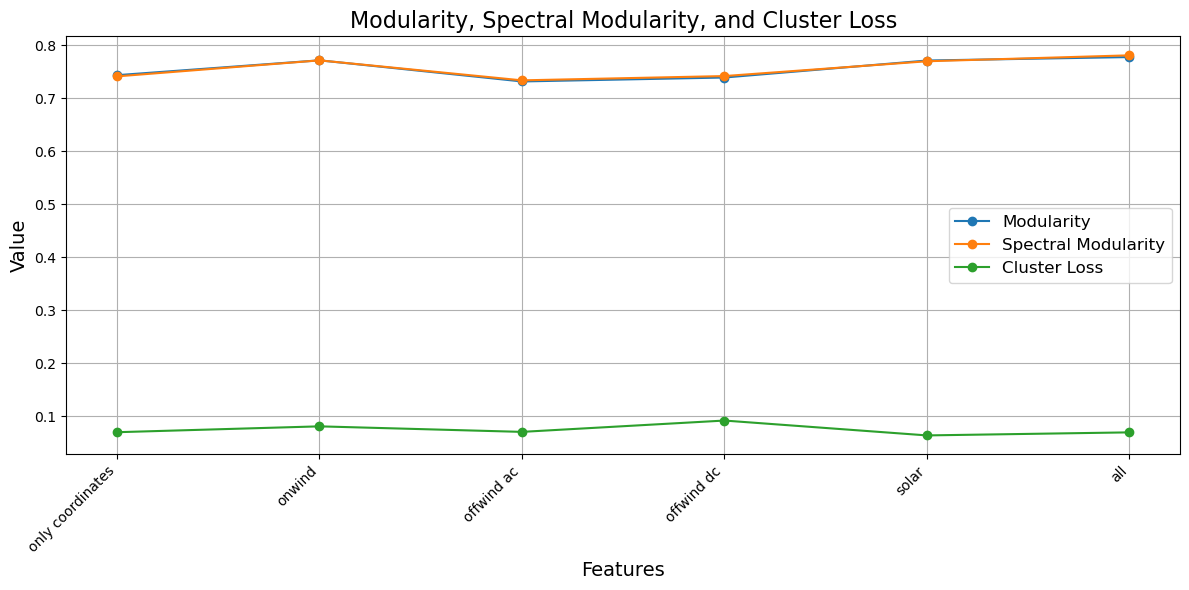

In [211]:
plot_modularity_cluster_loss(get_modularities_and_clusterLosses(n, train_dic_100_EX1, test_dic_100_EX1))
#plot_modularity_cluster_loss(get_modularities_and_clusterLosses(n, train_dic_200_EX1, test_dic_200_EX1))

200 

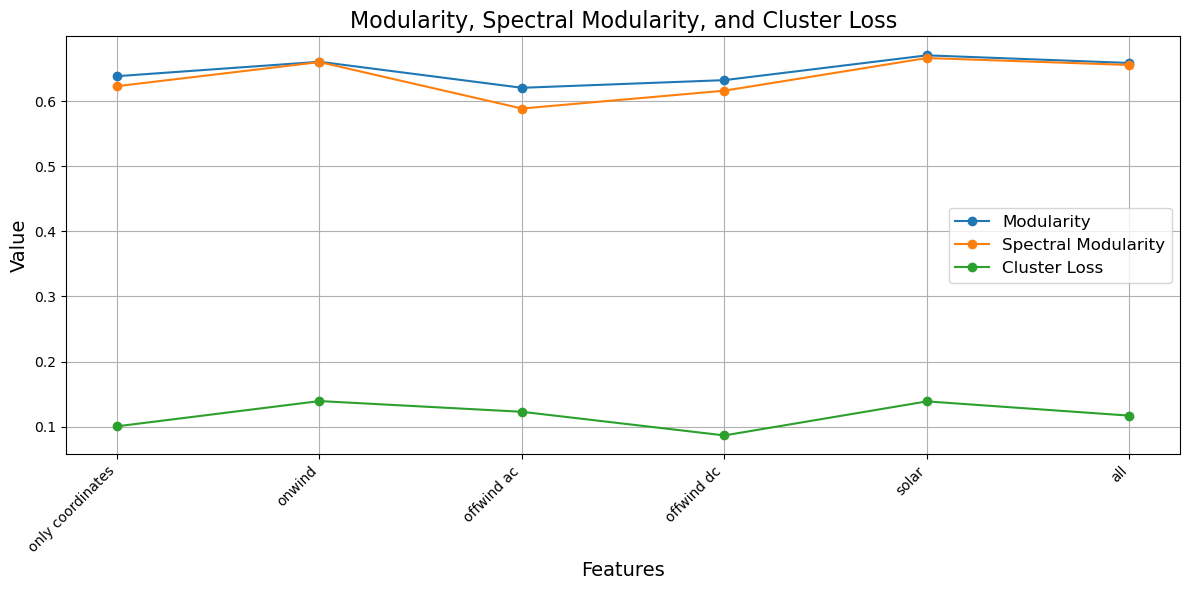

In [212]:
plot_modularity_cluster_loss(get_modularities_and_clusterLosses(n, train_dic_200_EX1, test_dic_200_EX1))

# 2) Comparison on objective

#### 16 cl

In [56]:
# dataframe for the objective values for all experiments, 16 clusters, experiments are the columns and features are the rows
obj_df_16cl = pd.DataFrame({"16_EX1": obj_16_EX1, "16_EX2": obj_16_EX2, "16_EX3": obj_16_EX3, "16_EX4": obj_16_EX4, "16_EX5": obj_16_EX5})
(obj_df_16cl / 1e9).round(2)

,16_EX1,16_EX2,16_EX3,16_EX4,16_EX5
only_coordinates_optimized.h5,4.96,4.92,5.07,4.99,4.91
solar_optimized.h5,5.01,5.05,5.07,4.97,5.01
all_optimized.h5,4.92,4.99,5.02,4.94,4.98
onwind_optimized.h5,4.97,5.01,5.05,5.03,4.94
offwind_ac_optimized.h5,4.92,4.94,4.93,5.20,4.96
offwind_dc_optimized.h5,5.08,5.13,5.06,5.12,5.02


In [57]:
# print max - min of each row
(obj_df_16cl.max(axis=1) - obj_df_16cl.min(axis=1)).round(2)

only_coordinates_optimized.h5    1.638479e+08
solar_optimized.h5               1.020754e+08
all_optimized.h5                 9.297098e+07
onwind_optimized.h5              1.101128e+08
offwind_ac_optimized.h5          2.793315e+08
offwind_dc_optimized.h5          1.120824e+08
dtype: float64

#### 100 cl ! different number of clusters !

In [59]:
# dataframe for the objective values for all experiments, 16 clusters, experiments are the columns and features are the rows
obj_df_100cl = pd.DataFrame({"100_EX1": obj_100_EX1, "100_EX2": obj_100_EX2, "100_EX3": obj_100_EX3, "100_EX4": obj_100_EX4, "100_EX5": obj_100_EX5})
(obj_df_100cl / 1e9).round(2)
# print average of all experiments

,100_EX1,100_EX2,100_EX3,100_EX4,100_EX5
only_coordinates_optimized.h5,5.32,5.30,5.21,5.31,5.31
solar_optimized.h5,5.19,5.39,5.22,5.35,NaN
all_optimized.h5,5.20,5.13,5.12,5.19,5.22
onwind_optimized.h5,5.18,5.31,5.14,5.23,NaN
offwind_ac_optimized.h5,5.07,5.14,5.17,5.16,5.04
offwind_dc_optimized.h5,5.14,5.05,5.09,5.27,5.39


In [61]:
(obj_df_100cl.max(axis=1) - obj_df_100cl.min(axis=1)).round(2)

only_coordinates_optimized.h5    1.109941e+08
solar_optimized.h5               1.945937e+08
all_optimized.h5                 1.025693e+08
onwind_optimized.h5              1.719419e+08
offwind_ac_optimized.h5          1.276192e+08
offwind_dc_optimized.h5          3.320150e+08
dtype: float64

#### 200 cl !different cluster sizes!

In [177]:
# dataframe for the objective values for all experiments, 16 clusters, experiments are the columns and features are the rows
obj_df_200cl = pd.DataFrame({"200_EX1": obj_200_EX1, "200_EX2": obj_200_EX2, "200_EX3": obj_200_EX3, "200_EX4": obj_200_EX4, "200_EX5": obj_200_EX5})
(obj_df_200cl / 1e9).round(2)
# print average of all experiments

,200_EX1,200_EX2,200_EX3,200_EX4,200_EX5
only_coordinates_optimized.h5,5.36,5.50,5.28,5.29,5.25
solar_optimized.h5,5.48,5.49,5.55,5.45,NaN
all_optimized.h5,5.43,5.53,5.44,5.35,5.56
onwind_optimized.h5,5.33,5.49,5.46,5.50,5.43
offwind_ac_optimized.h5,5.24,5.19,5.19,5.24,5.26
offwind_dc_optimized.h5,5.27,5.28,5.38,5.50,5.55


## 2.2) Plot of objectives of different optimized networks

In [39]:
import matplotlib.pyplot as plt

def plot_optimized_networks(dictionary_cl_nets_objectives, opt_n_objective, opt_k_means_objective):
    plt.figure(figsize=(5, 4))

    baseline = 4e9  # Baseline value for the y-axis

    # Sort the dictionary by keys alphabetically (for later comparison)
    sorted_keys = sorted(dictionary_cl_nets_objectives.keys())
    sorted_values = [dictionary_cl_nets_objectives[key] for key in sorted_keys]
    adjusted_values = [value - baseline for value in sorted_values]

    bars = plt.bar(sorted_keys, adjusted_values, color='lightblue', bottom=baseline)

    # Add the objective value as text above each bar
    for bar in bars:
        yval = bar.get_height()  + baseline
        plt.text(bar.get_x() + bar.get_width() / 2, yval * 1.01, f'{yval / 1e9:.2f}', 
                 ha='center', va='bottom', fontsize=6)

    def format_label(label):
        label = label.replace("optimized", "").replace(".h5", " ").replace("_", " ")
        return label
    short_labels = [format_label(key) for key in sorted_keys]
    plt.xticks(ticks=range(len(short_labels)), labels=short_labels, rotation=40, fontsize=6)

    # Add reference lines for original and k-means network objectives
    # adjust the bars so that they start at the y value 4 billion €
    plt.axhline(opt_n_objective, color='red', linestyle='--', 
                label=f"Original Network \n{opt_n_objective:.2e}")
    plt.axhline(opt_k_means_objective, color='green', linestyle='--', 
                label=f"K-Means \n{opt_k_means_objective:.2e}")


    plt.xlabel('Features used for clustering', fontsize=6)
    plt.ylabel('Objective Value', fontsize=6)
    plt.title('Objective Values for Optimized Networks in billion €', fontsize=7)
    plt.legend(fontsize=5)
    plt.tight_layout()
    plt.show()


#### 16 cl differences

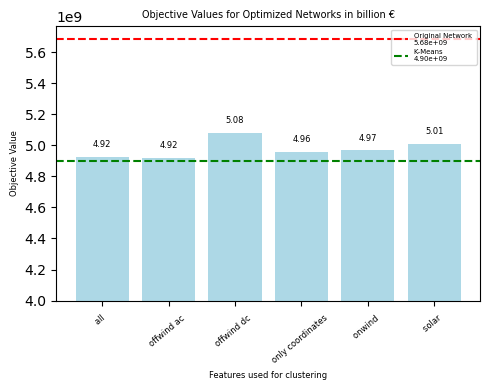

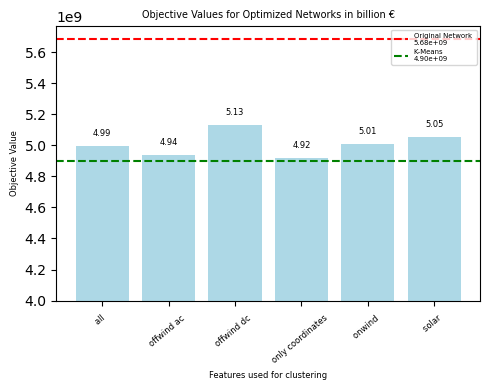

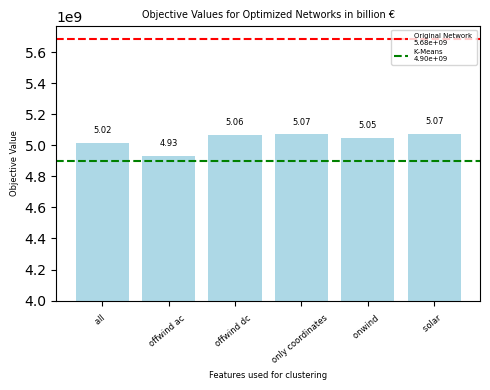

In [173]:
plot_optimized_networks(obj_16_EX1, n_opt.objective, opt_16_means.objective)
plot_optimized_networks(obj_16_EX2, n_opt.objective, opt_16_means.objective)
plot_optimized_networks(obj_16_EX3, n_opt.objective, opt_16_means.objective)
#plot_optimized_networks(obj_16_EX4, n_opt.objective, opt_16_means.objective)
#plot_optimized_networks(obj_16_EX5, n_opt.objective, opt_16_means.objective)

100 cl

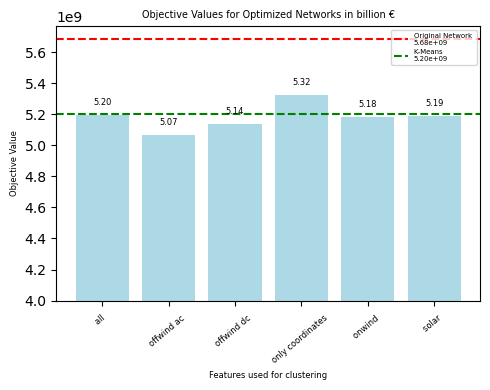

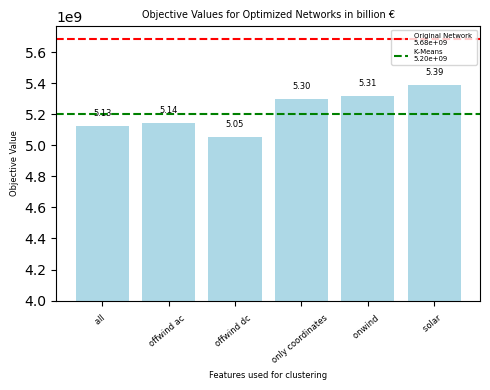

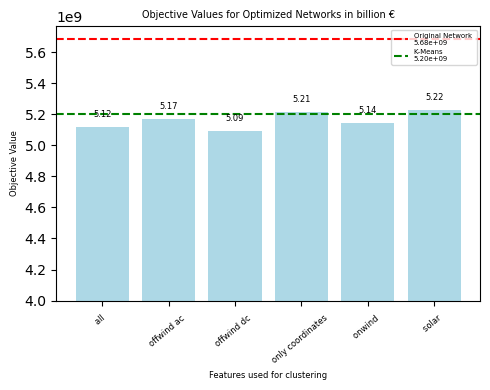

In [174]:
plot_optimized_networks(obj_100_EX1, n_opt.objective, opt_100_means.objective)
plot_optimized_networks(obj_100_EX2, n_opt.objective, opt_100_means.objective)
plot_optimized_networks(obj_100_EX3, n_opt.objective, opt_100_means.objective)
#plot_optimized_networks(obj_100_EX4, n_opt.objective, opt_100_means.objective)
#plot_optimized_networks(obj_100_EX5, n_opt.objective, opt_100_means.objective)

# 2.3) Show how objective is calculated 

In [85]:
# function from Fabian Hofmann (pypsa developer)
# "after optimizing, the network has now an additional attribute objective_constant 
# which reflects the capital cost of already existing infrastructure in the network referring to p_nom 
# and s_nom values for all extendable components" (https://pypsa.readthedocs.io/en/latest/references/release-notes.html).
def calculate_objective_constant(network):
    nom_attr = pypsa.descriptors.nominal_attrs.items() # get nominal attributes
    constant = 0
    extendable_indices = {} # store the extendable indices
    for c, attr in nom_attr: # Loop through each component and attribute
        ext_i = pypsa.descriptors.get_extendable_i(network, c) # Get indices of extendable (during optimization) components (not all are set to True in _extandable!)
        if len(ext_i) == 0: # Skip if no extendable components are found
            continue
        extendable_indices[c] = ext_i
        if c in network.passive_branch_components: # Check if the component is a passive branch component
            attr += '_min' 
        constant += network.df(c)[attr][ext_i] @ network.df(c).capital_cost[ext_i] # Calculate the constant costs by multiplying the attribute with the capital cost
    return (constant, extendable_indices)

print(calculate_objective_constant(n_opt)[0])
print(n_opt.objective_constant) 

# extract extendable generator components and print their carriers
print("extandable carriers", set(n_opt.generators.carrier[n_opt.generators.p_nom_extendable == True].values))
print(set(n_opt.storage_units.carrier[n_opt.storage_units.p_nom_extendable == True].values))
print( set(n_opt.links.carrier[n_opt.links.p_nom_extendable == True].values))
print(set(n_opt.lines.carrier[n_opt.lines.s_nom_extendable == True].values))
print(set(n_opt.stores.carrier[n_opt.stores.e_nom_extendable == True].values))

9897267042.350103
9897267042.350105
extandable carriers {'OCGT', 'offwind-ac', 'offwind-dc', 'solar', 'onwind'}
set()
set()
set()
set()


In [128]:
# function from https://groups.google.com/g/pypsa/c/k45-oXGqWGQ
def calculate_capital_costs(network):

    # Combine branch and one-port components (e.g., lines, links, generators, loads etc.)
    components = network.branch_components | network.one_port_components
    total_capital_costs = []

    for component in components:
        try:
            # Calculate capital costs: nominal attribute * capital cost
            cost = network.df(component).eval(f"{pypsa.descriptors.nominal_attrs[component]} * capital_cost")
            total_capital_costs.append(cost)
        except (KeyError, AttributeError):
            # Skip components without capital_cost or nominal attributes
            pass

    # combine into single value
    return pd.concat(total_capital_costs).sum() / 1e9  

# Example usage
#print(pypsa.descriptors.nominal_attrs)
#print(calculate_capital_costs(opt_n), "billion euros")
#print(opt_n.statistics.installed_capex().sum() / 1e9)

In [69]:
# rebuilt the objective function by hand to understand the cost function
def calculate_cost_function(network):
    time_weights = network.snapshot_weightings["objective"].values  # `w_t`
    total_cost = 0 
    total_capital_cost = 0
    total_operational_cost = 0

    # capital expenditure of already built components of the network
    gen_capital_cost = sum(network.generators["capital_cost"] * network.generators["p_nom"])
    storage_capital_cost = sum(network.storage_units["capital_cost"] * network.storage_units["p_nom"])
    line_capital_cost = sum(network.lines["capital_cost"] * network.lines["s_nom"])
    total_capital_cost = gen_capital_cost + storage_capital_cost + line_capital_cost
    print("Capital expenditure of already built components of the network by hand:", total_capital_cost/1e6)
    print("Capital expenditure of already built components of the network by pypsa:", network.statistics.installed_capex().sum()/1e6)
    # == calculate_capital_costs(opt_n)
    
    # capital expenditure of optimized components 
    gen_capital_cost_opt = sum(network.generators["capital_cost"] * network.generators["p_nom_opt"])
    storage_capital_cost_opt = sum(network.storage_units["capital_cost"] * network.storage_units["p_nom_opt"])
    line_capital_cost_opt = sum(network.lines["capital_cost"] * network.lines["s_nom_opt"])
    total_capital_cost_opt = gen_capital_cost_opt + storage_capital_cost_opt + line_capital_cost_opt
    print("Capital expenditure of optimized components of the network by hand:", total_capital_cost_opt/1e6)
    print("Capital expenditure of optimized components of the network by pypsa:", network.statistics.capex().sum()/1e6)
    
    # difference between capital expenditure of optimized and already built components
    print("Difference between capital expenditure of optimized and already built components by hand:", (total_capital_cost_opt-total_capital_cost)/1e6)
    print("Difference between capital expenditure of optimized and already built components by pypsa:", network.statistics.expanded_capex().sum()/1e6)

    # operational costs 
    gen_operational_cost = sum((network.generators_t["p"].values * network.generators["marginal_cost"].values).sum(axis=1) * time_weights)
    storage_operational_cost = sum((network.storage_units_t["p_dispatch"].values * network.storage_units["marginal_cost"].values).sum(axis=1)* time_weights)
    total_operational_cost = gen_operational_cost + storage_operational_cost
    print("Storage operational cost:", storage_operational_cost)
    print("Operational costs by hand:", total_operational_cost/1e6)
    print("Operational costs by pypsa:", network.statistics.opex(aggregate_time="sum").sum()/1e6)

    # startup and shutdown costs for generators (if available)
    startup_costs = sum((network.generators_t["status"] * network.generators["start_up_cost"]).sum(axis=1) * time_weights)
    shutdown_costs = sum((network.generators_t["status"] * network.generators["shut_down_cost"]).sum(axis=1) * time_weights)
    
    # constant costs only for extendable components (this value is used in the optimization)
    by_hand_objective_constant = calculate_objective_constant(network)[0]
    print("Objective constant by hand:", by_hand_objective_constant/1e6)
    print("Objective constant by pypsa:", network.objective_constant/1e6)


    # cost for expanding the network, only for extendable components
    by_hand_objective = (total_operational_cost + (total_capital_cost_opt-total_capital_cost)) 
    print("Objective by hand:", by_hand_objective/1e6)
    print("Objective by pypsa:", network.objective/1e6)
    print()
    
    # Add all costs together
    total_cost = total_capital_cost_opt + total_operational_cost + startup_costs + shutdown_costs
    # by pypsa
    print("Total System Cost by hand:", total_cost/1e6)
    print("Total System Cost by pypsa:", network.statistics.opex(aggregate_time="sum").sum()/1e6 + network.statistics.capex().sum()/1e6)
    
    # Return all components as a dictionary
    return {
        "Capital Expenditure of Existing Components": total_capital_cost/1e6,
        "Capital Expenditure of Optimized Components": total_capital_cost_opt/1e6,
        "Expanding costs" : (total_capital_cost_opt-total_capital_cost)/1e6,
        "Operational Cost": total_operational_cost/1e6,
        "Objective": network.objective/1e6,
        "Total System Cost": total_cost/1e6,
        "Objective Constant": by_hand_objective_constant/1e6
    }

def costs_df(obj_dict, obj_n, obj_k_means):
    costs_dict = {}
    
    # Calculate costs for the original and k-means networks
    original_network_costs = calculate_cost_function(obj_n)
    costs_dict['Original Network'] = original_network_costs
    k_means_costs = calculate_cost_function(obj_k_means)
    costs_dict['K Means Network'] = k_means_costs
    
    # Calculate costs for the DMoN clustered networks
    for key, network in obj_dict.items():
        name = key.replace(".h5", "").replace("_", " ").replace("optimized", "")
        costs_dict[name] = calculate_cost_function(network)
    costs_df = pd.DataFrame(costs_dict).T.round(2)
    
    # Calculate relative costs
    relative_costs_df = (costs_df - costs_df.loc["Original Network"]) / costs_df.loc["Original Network"] * 100 
    relative_costs_df = relative_costs_df.round(2)
    
    return costs_df, relative_costs_df

In [70]:
abosolute_costs, relative_costs = costs_df(optimized_networks_16_EX1, n_opt, opt_16_means)

Capital expenditure of already built components of the network by hand: 29702.667611636374
Capital expenditure of already built components of the network by pypsa: 29702.667611636367
Capital expenditure of optimized components of the network by hand: 29764.155101830223
Capital expenditure of optimized components of the network by pypsa: 29764.15510183021
Difference between capital expenditure of optimized and already built components by hand: 61.487490193847655
Difference between capital expenditure of optimized and already built components by pypsa: 61.487490193840145
Storage operational cost: 0.0
Operational costs by hand: 5620.080647609485
Operational costs by pypsa: 5620.0806476094795
Objective constant by hand: 9897.267042350104
Objective constant by pypsa: 9897.267042350106
Objective by hand: 5681.568137803332
Objective by pypsa: 5681.568143550326

Total System Cost by hand: 35384.23574943971
Total System Cost by pypsa: 35384.235749439686
Capital expenditure of already built comp

In [71]:
print("in / 1e6")
abosolute_costs

in / 1e6


,Capital Expenditure of Existing Components,Capital Expenditure of Optimized Components,Expanding costs,Operational Cost,Objective,Total System Cost,Objective Constant
Original Network,29702.67,29764.16,61.49,5620.08,5681.57,35384.24,9897.27
K Means Network,29324.65,29324.83,0.18,4898.87,4899.06,34223.70,9897.27
only coordinates,29204.05,29204.18,0.13,4956.57,4956.71,34160.75,9897.27
solar,29102.72,29102.73,0.01,5008.36,5008.37,34111.10,9897.27
all,29305.06,29305.15,0.09,4923.66,4923.77,34228.82,9897.27
onwind,29042.58,29042.73,0.16,4966.57,4966.73,34009.30,9897.27
offwind ac,29493.07,29493.08,0.00,4918.95,4918.95,34412.03,9897.27
offwind dc,29230.04,29233.44,3.40,5078.04,5081.44,34311.47,9897.27


In [72]:
relative_costs

,Capital Expenditure of Existing Components,Capital Expenditure of Optimized Components,Expanding costs,Operational Cost,Objective,Total System Cost,Objective Constant
Original Network,0.00,0.00,0.00,0.00,0.00,0.00,0.0
K Means Network,-1.27,-1.48,-99.71,-12.83,-13.77,-3.28,0.0
only coordinates,-1.68,-1.88,-99.79,-11.81,-12.76,-3.46,0.0
solar,-2.02,-2.22,-99.98,-10.88,-11.85,-3.60,0.0
all,-1.34,-1.54,-99.85,-12.39,-13.34,-3.27,0.0
onwind,-2.22,-2.42,-99.74,-11.63,-12.58,-3.89,0.0
offwind ac,-0.71,-0.91,-100.00,-12.48,-13.42,-2.75,0.0
offwind dc,-1.59,-1.78,-94.47,-9.64,-10.56,-3.03,0.0
